In [67]:
import pandas as pd
import numpy as np
from nsepy import get_history
from nsepy.derivatives import get_expiry_date
import datetime
# from datetime import date
import scipy.stats as ss
import statsmodels.api as sm # 統計相關的庫
import arch # 條件異方差模型相關的庫
import time
import calendar
import math
import matplotlib.pyplot as plt    #畫圖
import seaborn as sns
sns.set_style('whitegrid')
% matplotlib inline

from IPython.display import display

## Tools & Function

In [68]:
def performance_matrics(port_value, output = False):

    #annual volatility
    ann_vol = (port_value.pct_change().std()) * np.sqrt(252)
    port_return = pd.DataFrame(index = port_value.index[:], columns=['Values'])
    port_return['Values'] = port_value.pct_change()

    #cumulative return series & max drawdown, max drawdown duration
    port_cum_series= pd.DataFrame(index = port_return.index[:], 
                                  columns=['CumulativeReturn','WaterMark','Drawdown','Dwn_Duration'])

    for i in range(len(port_return)):
        if i == 0:
            port_cum_series['CumulativeReturn'].iloc[i] = 0
            port_cum_series['WaterMark'].iloc[i] = port_cum_series['CumulativeReturn'].iloc[i]
        else:
            port_cum_series['CumulativeReturn'].iloc[i] = (1 + port_return['Values'].iloc[i]) * (1 + port_cum_series['CumulativeReturn'].iloc[i-1]) - 1
            if port_cum_series['CumulativeReturn'].iloc[i] > port_cum_series['WaterMark'].iloc[i-1]:
                port_cum_series['WaterMark'].iloc[i] = port_cum_series['CumulativeReturn'].iloc[i]
            else:
                port_cum_series['WaterMark'].iloc[i] = port_cum_series['WaterMark'].iloc[i-1]  

        port_cum_series['Drawdown'].iloc[i] = ((1 + port_cum_series['WaterMark'].iloc[i]) - (1 + port_cum_series['CumulativeReturn'].iloc[i])) / (1 + port_cum_series['WaterMark'].iloc[i])
        if i == 0:
            port_cum_series['Dwn_Duration'].iloc[i] = 0
        else:
            if port_cum_series['Drawdown'].iloc[i] != 0:
                port_cum_series['Dwn_Duration'].iloc[i] = port_cum_series['Dwn_Duration'].iloc[i-1] + 1
            else:
                port_cum_series['Dwn_Duration'].iloc[i] = 0 


    max_drawdown = port_cum_series['Drawdown'].max()
    max_dwn_duration = port_cum_series['Dwn_Duration'].max()
    total_return = port_value.iloc[-1]/port_value.iloc[0] - 1 
    
    #annual return
    ann_return = (1 + total_return) ** (1 / float((len(port_value)) / 252.0)) - 1 

    #sharpe ratio
    sharpe_ratio = (ann_return) / ann_vol
    
    print('annual volatility:{}'.format(ann_vol.iloc[0]))
    print('annual return:{}'.format(ann_return.iloc[0]))
    print('sharpe ratio:{}'.format(sharpe_ratio.iloc[0]))
    print('max drawdown:{}'.format(max_drawdown))
    print('max down duration:{} days'.format(max_dwn_duration))

    
def record_transaction(symbol, action_side, date, price, strike, quantity, fee=0, transaction_history={}): 
    #option_type = ['long call','short call','long put','short put']
    #for symbol in option_type
    #symbol = '%s_%s' %(str(strike), option_type)
    '''
    action_side: long or short
    date: date for executing the action
    quantity: contracts
    fee: one trip cost
    transaction_history: record all the transaction here
    '''
    info = {
                'Date': date,
                'Option': symbol,
                'Action': action_side,
                'Price': price,
                'Strike_Price':strike,
                'Quantity': quantity,
                'Fee': fee
            }
    if symbol in transaction_history:
        transaction_history[symbol].append(info)
    else:
        transaction_history.update({symbol: [info]})
            
    return transaction_history


def record_holdings(date, strike, option_range, action_side, call_price, put_price, quantity, holdings={}, situation='open'):
    if situation == 'open':
        
        info = {
            'Date': date, 
            'Action':action_side,
            'Call_Strike_Price': strike+option_range,
            'Put_Strike_Price': strike-option_range,
            'Call_Price': call_price,
            'Put_Price': put_price,
            'Quantity': quantity,
            'Situation': situation
        }
        
        holdings.update({situation: info})
        return holdings
    
    elif situation == 'cover':
        del holdings['open']
        return holdings
    


In [68]:
# Option 資料抓取
def nifty_option(s,e,ot,sp,ed):
    data=get_history(symbol = 'NIFTY',
                     start = s ,
                     end = e,
                     index = True,
                     option_type =ot ,
                     strike_price = sp,
                     expiry_date = ed )
    return data

# Option 資料抓取
def option_pricing(i, option_type, strike_price):  # option type = CE/PE
    year = int(nifty_index['Date'][int(start_index+i)].strftime('%Y%m%d')[0:4])
    month = int(nifty_index['Date'][int(start_index+i)].strftime('%Y%m%d')[4:6])
    day = int(nifty_index['Date'][int(start_index+i)].strftime('%Y%m%d')[6:])
    if month==12:
        expiry = get_expiry_date(year=year+1, month=1).strftime('%Y%m%d')
    else:
        expiry = get_expiry_date(year=year, month=month+1).strftime('%Y%m%d')
    end_year = int(expiry[0:4])
    end_month = int(expiry[4:6])
    end_day = int(expiry[6:])
    if nifty_option(datetime.date(year, month, day), datetime.date(year, month, day), option_type, strike_price, datetime.date(end_year, end_month, end_day))['Close'].empty:
        price = np.nan
    else:
        price = nifty_option(datetime.date(year, month, day), datetime.date(year, month, day), option_type, strike_price, datetime.date(end_year, end_month, end_day))['Close'].iloc[0]
    return price


# 找出每周固定 weekday 的日期 e.g. 1/1 -> 1/8 -> 1/15 (7 天 為一循環)
def getweeklydate():
    first = datetime.date(2014, 1, 1)
    oneweek = datetime.timedelta(days=7)
    return [(first + i * oneweek) for i in range(730)]

In [70]:
nifty_index = get_history(symbol="NIFTY",
                            start=datetime.date(2005,1,1),
                            end=datetime.date(2018,12,31),
                            index = True)
nifty_return = nifty_index['Close'].pct_change(periods=1).dropna()
nifty_index.reset_index(inplace=True)

# Garch Modeling

In [72]:
def vol_pred(data, n_test, lags=7, quantile=85) -> bool:
    
    train, test = data[:-n_test], data[-n_test:] # n_test=len(data) * 0.1
    model = arch.arch_model(train, mean='AR', vol='GARCH', lags=lags, p=1, q=1)
    model_fit = model.fit()
    
    ini = model_fit.resid[-lags:]
    a = np.array(model_fit.params[1:8])
    w = a[::-1]
    for i in range(n_test):
        new = test[i] - (model_fit.params[0] + w.dot(ini[-lags:]))
        ini = np.append(ini, new)
    at_pre = ini[-n_test:]
    at_pre2 = at_pre**2
    
    ini2 = model_fit.conditional_volatility[-2:]
    for i in range(n_test):
        new = model_fit.params['omega'] + model_fit.params['alpha[1]'] * at_pre2[i] + model_fit.params['beta[1]'] * ini2[-1]
        ini2 = np.append(ini2, new)
    vol_pre = ini2[-n_test]
    
    return vol_pre > np.percentile(model_fit.conditional_volatility[lags:], q=quantile)

# Settings

In [73]:
#set date range
start = datetime.datetime(2005, 1, 4) 
end = datetime.datetime(2018, 12, 31)
start_index = 2239
test_size = 1233
#Underlyings
#strategy parameters
int_capital = 1000000
option_type = ['long call','short call','long put','short put']
#一次只有一個合約
# hold = {(-1): short strangle, 0： no contracts, 1: long strandle}
hold = 0 
weekly_date = getweeklydate()

In [75]:
def transaction(i, action_side, transaction_history, cash_value, pos_value, option_range=300):
    if i == 0:
        cash_value.iloc[i, 0] = int_capital * 1 
    else:
        cash_value.iloc[i, 0] = cash_value.iloc[i-1, 0]
        
    success = True
    date = nifty_index['Date'][int(start_index+i)]
    strike = int(nifty_index['Close'][int(start_index+i)]/100) * 100
    call_price = option_pricing(i, 'CE', strike+option_range)
    put_price = option_pricing(i, 'PE', strike-option_range)
    if np.isnan(call_price) or np.isnan(put_price):
        success = False
        quantity = 0
        return transaction_history, date, strike, option_range, action_side, call_price, put_price, quantity, success
    quantity = int(cash_value.iloc[i,0]/(call_price + put_price))

    transaction_history = record_transaction(str(strike+option_range)+'_call', action_side, date, call_price, (strike+option_range),
                           quantity, 0, transaction_history)
    transaction_history = record_transaction(str(strike-option_range)+'_put', action_side, date, put_price, (strike-option_range),
                           quantity, 0, transaction_history)
    
    if action_side=='short':
        pos_value.iloc[i, 0] = (-1) * (call_price + put_price) * quantity
        cash_value.iloc[i, 0] += (call_price + put_price) * quantity
    elif action_side=='long':
        pos_value.iloc[i, 0] = (call_price + put_price) * quantity
        cash_value.iloc[i, 0] -= (call_price + put_price) * quantity
    
    return transaction_history, date, strike, option_range, action_side, call_price, put_price, quantity, success


In [76]:
cash_value = pd.DataFrame(data=np.zeros((len(nifty_index)-start_index, 1)), columns=['Values'])
pos_value = pd.DataFrame(data=np.zeros((len(nifty_index)-start_index, 1)), columns=['Values'])
total_port_value = pd.DataFrame(data=np.zeros((len(nifty_index)-start_index, 1)), columns=['Values'])

# record transactions
holdings = {}
transaction_history = {}

for i in range(0, len(nifty_index)-start_index):
    if i == 0:
        
        #賣第一個合約
        transaction_history, date, strike_price, option_range, action_side, call_price, put_price, quantity, success = transaction(i, 'short', transaction_history, cash_value, pos_value)
        if success == False:
                continue
        holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='open')
        hold = -1
    else:
        cash_value.iloc[i, 0] = cash_value.iloc[i-1, 0]
        pos_value.iloc[i, 0] = pos_value.iloc[i-1, 0]
        # 波動率轉為   
        if (vol_pred(nifty_return, (test_size-i)) == True and hold==-1):
            #買回來平倉加買進 long
            date, action_side, call_strike, put_strike, call_price, put_price, quantity, _ = holdings['open'].values()
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='cover')
            call_new_price = option_pricing(i, 'CE', call_strike)
            put_new_price = option_pricing(i, 'PE', put_strike)
            pos_value.iloc[i, 0] = 0
            cash_value.iloc[i, 0] -= (call_new_price+put_new_price)*quantity  # 平倉
            
            transaction_history, date, strike_price, option_range, action_side, call_price, put_price, quantity, success = transaction(i, 'long', transaction_history, cash_value, pos_value, option_range=0)
            if success == False:
                hold = 0
                continue
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='open')
            hold = 1 # 買進

        elif (vol_pred(nifty_return, (test_size-i), quantile=60) == False and hold==1):
            #賣掉long 賣出short
            date, action_side, call_strike, put_strike, call_price, put_price, quantity, _ = holdings['open'].values()
            holdings=record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='cover')
            call_new_price = option_pricing(i, 'CE', call_strike)
            put_new_price = option_pricing(i, 'PE', put_strike)
            pos_value.iloc[i, 0] = 0
            cash_value.iloc[i, 0] += (call_new_price+put_new_price)*quantity  # 平倉
            
            transaction_history, date, strike_price, option_range, action_side, call_price, put_price, quantity, success = transaction(i, 'short', transaction_history, cash_value, pos_value)
            if success == False:
                hold = 0
                continue
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='open')
            hold = -1
        elif (hold==-1 and nifty_index['Date'][int(start_index+i)] in weekly_date):
            #買回來平倉再繼續賣 
            date, action_side, call_strike, put_strike, call_price, put_price, quantity, _ = holdings['open'].values()
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='cover')
            call_new_price = option_pricing(i, 'CE', call_strike)
            put_new_price = option_pricing(i, 'PE', put_strike)
            pos_value.iloc[i, 0] = 0
            cash_value.iloc[i, 0] -= (call_new_price+put_new_price)*quantity  # 平倉
    
            transaction_history, date, strike_price, option_range, action_side, call_price, put_price, quantity, success = transaction(i, 'short', transaction_history, cash_value, pos_value)
            if success == False:
                hold = 0
                continue
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='open')
            hold = -1
        elif (vol_pred(nifty_return, (test_size-i)) == False and hold==0):
            transaction_history, date, strike_price, option_range, action_side, call_price, put_price, quantity, success = transaction(i, 'short', transaction_history, cash_value, pos_value)
            if success == False:
                hold = 0
                continue
            holdings = record_holdings(date, strike_price, option_range, action_side, call_price, put_price, quantity, holdings, situation='open')
            hold = -1
            
    #update total value of portfolio value
    total_port_value.iloc[i, 0] = pos_value.iloc[i, 0] + cash_value.iloc[i, 0]
        
        

Iteration:      1,   Func. Count:     13,   Neg. LLF: -6409.319506513049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6410.318420006746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6410.318419268109
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6409.319506513049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6410.318420006746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6410.318419268109
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6409.319506513049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6410.318420006746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6410.318419268109
            Iterations: 2
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6415.671378321972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6416.641156149675
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6416.641159244636
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6419.310708563814
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6420.2707731348255
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6420.270776262991
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6419.310708563814
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6420.2707731348255
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6420.270776262991
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6419.310708563814
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6420.2707731348255
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6420.270776262991
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6422.857219127165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6423.804312724317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6423.804315885702
            Iterations:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6426.610166422744
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6427.550915677049
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6427.5509188950355
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6426.610166422744
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6427.550915677049
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6427.5509188950355
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6426.610166422744
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6427.550915677049
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6427.5509188950355
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6430.364103207967
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6431.293709921329
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6431.293712986272
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6430.364103207967
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6431.293709921329
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6431.293712986272
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6430.364103207967
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6431.293709921329
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6431.293712986272
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6434.176785595388
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6435.096955876559
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6435.096959206579
            Iterations: 6

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6434.176785595388
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6435.096955876559
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6435.096959206579
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6436.329842492556
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6437.303380963263
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6437.3033841133965
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6436.329842492556
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6437.303380963263
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6437.3033841133965
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6436.329842492556
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6437.303380963263
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6437.3033841133965
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6439.790568395989
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6440.755654455755
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6440.755657618403
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6439.790568395989
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6440.755654455755
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6440.755657618403
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6442.715178737187
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6443.697121089068
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6443.821462466445
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6443.822003411546
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6443.887317035162
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6443.91832539465
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6443.918328471642
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6442.715178737187
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6443.697121089068
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6443.821462466445
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6443.822003411546
Iteration:      5,   Func. Count:     95,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6442.715178737187
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6443.697121089068
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6443.821462466445
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6443.822003411546
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6443.887317035162
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6443.91832539465
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6443.918328471642
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6446.381592422795
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6447.364531349056
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6447.364524296343
Iteration:      4,   Func. Count:     76,   Neg. LLF: -6447.367454377822
Iteration:      5,   Func. Count:     97,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6446.381592422795
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6447.364531349056
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6447.364524296343
Iteration:      4,   Func. Count:     76,   Neg. LLF: -6447.367454377822
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6447.367757375789
Iteration:      6,   Func. Count:    118,   Neg. LLF: -6447.368314522483
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6447.368317682582
            Iterations: 10
            Function evaluations: 118
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6446.381592422795
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6447.364531349056
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6447.364524296343
Iteration:      4,   Func. Count:     76,   Neg. LLF: -6447.367454377822
Iteration:      5,   Func. Count:     97,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6449.592291578458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6450.564664573732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6450.5646638080425
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6449.592291578458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6450.564664573732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6450.5646638080425
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6449.592291578458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6450.564664573732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6450.5646638080425
            Iterations: 2
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6453.039686210197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6454.017483017645
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6454.126940267968
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6454.192881839945
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6454.224991998131
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6454.224995118294
            Iterations: 9
            Function evaluations: 94
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6453.039686210197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6454.017483017645
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6454.126940267968
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6454.192881839945
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6454.224991998131
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6456.743543528151
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6457.72305241112
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6457.723037607433
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6457.7230145476715
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6457.723029361783
Iteration:      6,   Func. Count:    126,   Neg. LLF: -6457.723050046714
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6457.7230532524845
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6456.743543528151
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6457.72305241112
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6457.723037607433
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6457.7230145476715
Iteration:      5,   Func. Count:    103,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6460.452014623093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6461.435602578797
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6461.435605830363
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6460.452014623093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6461.435602578797
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6461.435605830363
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6460.452014623093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6461.435602578797
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6461.435605830363
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6464.2180095697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6465.204661381515
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6465.204664684578
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6464.2180095697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6465.204661381515
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6465.204664684578
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6464.2180095697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6465.204661381515
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6465.204664684578
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6466.83403490952
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6467.792278857499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6467.792282047835
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6466.83403490952
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6467.792278857499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6467.792282047835
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6466.83403490952
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6467.792278857499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6467.792282047835
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6468.18299626017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6469.125541599155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6469.125544573633
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6468.18299626017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6469.125541599155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6469.125544573633
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6468.18299626017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6469.125541599155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6469.125544573633
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6471.732803169045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6472.667382202288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6472.667385201126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6471.732803169045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6472.667382202288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6472.667385201126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6475.302096234662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6476.228905709169
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6476.2289087348145
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6475.302096234662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6476.228905709169
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6476.2289087348145
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6475.302096234662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6476.228905709169
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6476.2289087348145
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6478.578419307701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6479.495869024751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6479.495872052847
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6478.578419307701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6479.495869024751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6479.495872052847
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6478.578419307701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6479.495869024751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6479.495872052847
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6482.20310113536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6483.112053659592
Iteration:      3,   Func. Count:     51,   Neg. LLF: -6483.2385486271005
Iteration:      4,   Func. Count:     71,   Neg. LLF: -6483.432031193314
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6483.488497226735
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6483.516756240906
Iteration:      7,   Func. Count:    134,   Neg. LLF: -6483.529001101673
Iteration:      8,   Func. Count:    154,   Neg. LLF: -6483.529592191859
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6483.5295951673625
            Iterations: 12
            Function evaluations: 154
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6482.20310113536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6483.112053659592
Iteration:      3,   Func. Count:     51,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6482.20310113536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6483.112053659592
Iteration:      3,   Func. Count:     51,   Neg. LLF: -6483.2385486271005
Iteration:      4,   Func. Count:     71,   Neg. LLF: -6483.432031193314
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6483.488497226735
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6483.516756240906
Iteration:      7,   Func. Count:    134,   Neg. LLF: -6483.529001101673
Iteration:      8,   Func. Count:    154,   Neg. LLF: -6483.529592191859
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6483.5295951673625
            Iterations: 12
            Function evaluations: 154
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6484.54167015523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6485.447652619523
Positive directional derivative for linesearch    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6484.54167015523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6485.447652619523
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6485.447655580052
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6484.54167015523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6485.447652619523
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6485.447655580052
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6488.124281762231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6489.018909569746
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6489.018912562364
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6488.124281762231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6489.018909569746
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6489.018912562364
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6491.7091255838695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6492.595968091219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6492.595971118942
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6491.7091255838695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6492.595968091219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6492.595971118942
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6491.7091255838695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6492.595968091219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6492.595971118942
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6495.367230402084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6496.245706609716
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6496.245709680854
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6495.367230402084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6496.245706609716
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6496.245709680854
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6495.367230402084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6496.245706609716
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6496.245709680854
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6499.01509848241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6499.888542652197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6499.888545768252
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6499.01509848241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6499.888542652197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6499.888545768252
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6499.01509848241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6499.888542652197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6499.888545768252
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6502.705604425531
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6503.018034131956
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6503.380243702229
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6503.568641681124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6503.568644846951
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6502.705604425531
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6503.018034131956
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6503.380243702229
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6503.568641681124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6503.568644846951
            Iterations: 8
            Function evaluations: 75
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6502.705604425531
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6503.018034131956
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6503.380243702229
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6503.568641681124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6503.568644846951
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6506.461989498421
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6506.78001877403
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6507.133493284421
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6507.319336415108
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6507.3909560967195
Iteration:      6,   Func. Count:    116,   Neg. LLF: -6507.391394773533
Iteration:      7,   Func. Count:    139,   Neg. LLF: -6507.391978500773
Iteration:      8,   Func. Count:    160,   Neg. LLF: -6507.399432631246
Iteration:      9,   Func. Count:    181,   Neg. LLF: -6507.407710784337
Iteration:     10,   Func. Count:    203,   Neg. LLF: -6507.456442409515
Iteration:     11,   Func. Count:    223,   Neg. LLF: -6507.495933822911
Iteration:     12,   Func. Count:    243,   Neg. LLF: -6507.510145448248
Iteration:     13,   Func. Count:    264,   Neg. LLF: -6507.516473376942
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    160,   Neg. LLF: -6507.399432631246
Iteration:      9,   Func. Count:    181,   Neg. LLF: -6507.407710784337
Iteration:     10,   Func. Count:    203,   Neg. LLF: -6507.456442409515
Iteration:     11,   Func. Count:    223,   Neg. LLF: -6507.495933822911
Iteration:     12,   Func. Count:    243,   Neg. LLF: -6507.510145448248
Iteration:     13,   Func. Count:    264,   Neg. LLF: -6507.516473376942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6507.516476579335
            Iterations: 17
            Function evaluations: 264
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6506.461989498421
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6506.78001877403
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6507.133493284421
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6507.319336415108
Iteration:      5,   Func. Count:     93,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6510.187325362587
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6510.499962845061
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6510.854410607746
Iteration:      4,   Func. Count:     73,   Neg. LLF: -6510.978362471725
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6511.021472287566
Iteration:      6,   Func. Count:    113,   Neg. LLF: -6511.03677794016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6511.036781220453
            Iterations: 10
            Function evaluations: 113
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6510.187325362587
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6510.499962845061
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6510.854410607746
Iteration:      4,   Func. Count:     73,   Neg. LLF: -6510.978362471725
Iteration:      5,   Func. Count:     93,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6510.187325362587
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6510.499962845061
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6510.854410607746
Iteration:      4,   Func. Count:     73,   Neg. LLF: -6510.978362471725
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6511.021472287566
Iteration:      6,   Func. Count:    113,   Neg. LLF: -6511.03677794016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6511.036781220453
            Iterations: 10
            Function evaluations: 113
            Gradient evaluations: 6


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6512.6830103077455
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6513.024633801051
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6513.5214680569925
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6513.521471188105
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6512.6830103077455
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6513.024633801051
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6513.5214680569925
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6513.521471188105
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6512.6830103077455
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6513.024633801051
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6513.5214680569925
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6513.521471188105
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6516.06862949538
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6516.39769457508
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6516.732300391814
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6516.911213084477
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6516.911216230733
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6516.06862949538
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6516.39769457508
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6516.732300391814
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6516.911213084477
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6516.911216230733
            Iterations: 8
            Function evaluations: 75
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6516.06862949538
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6516.39769457508
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6516.732300391814
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6516.911213084477
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6516.911216230733
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6519.745062818098
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6520.071891077702
Iteration:      3,   Func. Count:     55,   Neg. LLF: -6520.5867400558
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6520.586086403564
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6520.586793694234
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6520.58518460984
Iteration:      7,   Func. Count:    142,   Neg. LLF: -6520.585709893151
Iteration:      8,   Func. Count:    165,   Neg. LLF: -6520.586129462183
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6520.586132649691
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6519.745062818098
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6520.071891077702
Iteration:      3,   Func. Count:     55,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    142,   Neg. LLF: -6520.585709893151
Iteration:      8,   Func. Count:    165,   Neg. LLF: -6520.586129462183
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6520.586132649691
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6519.745062818098
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6520.071891077702
Iteration:      3,   Func. Count:     55,   Neg. LLF: -6520.5867400558
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6520.586086403564
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6520.586793694234
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6520.58518460984
Iteration:      7,   Func. Count:    142,   Neg. LLF: -6520.585709893151
Iteration:      8,   Func. Count:    165,   Neg. LLF: -6520.586129462183
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6523.183669806811
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6523.496856075126
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6524.034796727708
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6524.034600559877
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6524.03460566546
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6524.034608866361
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6523.183669806811
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6523.496856075126
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6524.034796727708


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     77,   Neg. LLF: -6524.034600559877
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6524.03460566546
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6524.034608866361
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6523.183669806811
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6523.496856075126
Iteration:      3,   Func. Count:     54,   Neg. LLF: -6524.034796727708
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6524.034600559877
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6524.03460566546
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6524.034608866361
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6526.874856707174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6527.728810521731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6527.728813766028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6526.874856707174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6527.728810521731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6527.728813766028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6526.874856707174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6527.728810521731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6527.728813766028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6529.94694075305
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6530.271230160326
Iteration:      3,   Func. Count:     55,   Neg. LLF: -6530.783459026559
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6530.783125441119
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6530.783205883246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6530.783209089208
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6529.94694075305
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6530.271230160326
Iteration:      3,   Func. Count:     55,   Neg. LLF: -6530.783459026559
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6530.783125441119
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6530.783205883246
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6529.94694075305
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6530.271230160326
Iteration:      3,   Func. Count:     55,   Neg. LLF: -6530.783459026559
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6530.783125441119
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6530.783205883246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6530.783209089208
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6533.137547952049
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6533.443070920122
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6533.791109257641
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6533.985644978722
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6533.985648173137
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6533.137547952049
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6533.443070920122
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6533.791109257641
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6533.985644978722
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6533.985648173137
            Iterations: 8
            Function evaluations: 75
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6533.137547952049
Iteration:      2,   Func. Count:     33,   Neg. LLF: -6533.443070920122
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6533.791109257641
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6533.985644978722
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6533.985648173137
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6536.74865883575
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6537.602946090854
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6537.6029493159185
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6536.74865883575
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6537.602946090854
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6537.6029493159185
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6536.74865883575
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6537.602946090854
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6537.6029493159185
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6540.475969607375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6541.3338147714
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6541.333818042625
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6540.475969607375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6541.3338147714
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6541.333818042625
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6540.475969607375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6541.3338147714
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6541.333818042625
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6544.047979327487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6544.915420277027
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6544.915423575911
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6544.047979327487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6544.915420277027
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6544.915423575911
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6544.047979327487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6544.915420277027
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6544.915423575911
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6547.685696586995
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6548.563754288708
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6548.563757623217
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6547.685696586995
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6548.563754288708
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6548.563757623217
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6547.685696586995
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6548.563754288708
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6548.563757623217
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6550.8459716725465
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6551.705804667273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6551.705808259455
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6550.8459716725465
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6551.705804667273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6551.705808259455
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6550.8459716725465
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6551.705804667273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6551.705808259455
            Iterations: 2
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6553.628990160034
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6554.505804697444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6554.505807931012
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6557.269368718135
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6558.154219796386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6558.154223063613
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6557.269368718135
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6558.154219796386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6558.154223063613
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6557.269368718135
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6558.154219796386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6558.154223063613
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6560.416608116666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6561.31098588453
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6561.310909441145
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6561.3115064171325
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6561.311173482022
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6561.311510420326
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6561.31151350929
            Iterations: 7
            Function evaluations: 134
            Gradient eval

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6560.416608116666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6561.31098588453
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6561.310909441145
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6561.3115064171325
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6561.311173482022
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6561.311510420326
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6561.31151350929
            Iterations: 7
            Function evaluations: 134
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6560.416608116666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6561.31098588453
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6561.310909441145
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6561.3115064171325
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6561.3

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    181,   Neg. LLF: -6564.369923540391
Iteration:     10,   Func. Count:    204,   Neg. LLF: -6564.369900455225
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6564.369903054294
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6562.370693333456
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6563.260568587001
Iteration:      3,   Func. Count:     51,   Neg. LLF: -6564.3658103285115
Iteration:      4,   Func. Count:     74,   Neg. LLF: -6564.367066607099
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6564.367454577109
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6564.368770518709
Iteration:      7,   Func. Count:    137,   Neg. LLF: -6564.369650064719
Iteration:      8,   Func. Count:    158,   Neg. LLF: -6564.3697808721845
Iteration:      9,   Func. Count:    181,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6565.94101010052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6566.841440978384
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6566.841402862631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6566.841406005926
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6565.94101010052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6566.841440978384
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6566.841402862631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6566.841406005926
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6565.94101010052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6566.841440978384
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6566.841402862631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6566.841406005926
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6569.459257115408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6570.3658439778865
Iteration:      3,   Func. Count:     51,   Neg. LLF: -6570.436455455589
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6570.5346565031705
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6570.680661558544
Iteration:      6,   Func. Count:    115,   Neg. LLF: -6571.062667556973
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6571.062681519503
Iteration:      8,   Func. Count:    161,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6569.459257115408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6570.3658439778865
Iteration:      3,   Func. Count:     51,   Neg. LLF: -6570.436455455589
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6570.5346565031705
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6570.680661558544
Iteration:      6,   Func. Count:    115,   Neg. LLF: -6571.062667556973
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6571.062681519503
Iteration:      8,   Func. Count:    161,   Neg. LLF: -6571.06280697484
Iteration:      9,   Func. Count:    184,   Neg. LLF: -6571.062825954703
Iteration:     10,   Func. Count:    204,   Neg. LLF: -6571.261780090444
Iteration:     11,   Func. Count:    224,   Neg. LLF: -6571.338607145998
Iteration:     12,   Func. Count:    244,   Neg. LLF: -6571.368872561223
Iteration:     13,   Func. Count:    266,   Neg. LLF: -6571.388249213406
Positive directional derivative for linesearch    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6573.091610530993
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6574.007153137967
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6574.007156344354
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6576.67773690429
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6577.59682966615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6577.59683290436
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6576.67773690429
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6577.59682966615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6577.59683290436
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6576.67773690429
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6577.59682966615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6577.59683290436
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6580.3695116345425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6581.296903327329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6581.2969066098485
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6580.3695116345425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6581.296903327329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6581.2969066098485
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6580.3695116345425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6581.296903327329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6581.2969066098485
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6584.099318255874
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6585.0340880464855
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6585.133547470616
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6585.13387145078
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6585.133899562859
Iteration:      6,   Func. Count:    119,   Neg. LLF: -6585.147747342819
Iteration:      7,   Func. Count:    140,   Neg. LLF: -6585.174591889867
Iteration:      8,   Func. Count:    160,   Neg. LLF: -6585.18496323087
Iteration:      9,   Func. Count:    182,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6584.099318255874
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6585.0340880464855
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6585.133547470616
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6585.13387145078
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6585.133899562859
Iteration:      6,   Func. Count:    119,   Neg. LLF: -6585.147747342819
Iteration:      7,   Func. Count:    140,   Neg. LLF: -6585.174591889867
Iteration:      8,   Func. Count:    160,   Neg. LLF: -6585.18496323087
Iteration:      9,   Func. Count:    182,   Neg. LLF: -6585.191718158807
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6585.191721446521
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6587.868507498577
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6588.809081071871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6588.80908445977
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6587.868507498577
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6588.809081071871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6588.80908445977
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6587.868507498577
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6588.809081071871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6588.80908445977
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6591.330323769274
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6592.259592820918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6592.259596213085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6591.330323769274
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6592.259592820918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6592.259596213085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6591.330323769274
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6592.259592820918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6592.259596213085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6595.118795540173
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6596.05229063364
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6596.052262952826
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6596.0522314467735
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6596.052887485866
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6596.052698200709
Iteration:      7,   Func. Count:    142,   Neg. LLF: -6596.054521268838
Iteration:      8,   Func. Count:    162,   Neg. LLF: -6596.055487159167
Iteration:      9,   Func. Count:    184,   Neg. LLF: -6596.056353486887
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6596.056352846475
            Iterations: 12
            Function evaluations: 195
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6595.118795540173
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6596

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6598.938959443474
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6599.872322016539
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6599.872325520296
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6601.646863289054
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6602.606514083599
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6602.687369373638
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6602.731708937972
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6602.761141171242
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6602.761144908547
            Iterations: 7
            Function evaluations: 106
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6601.646863289054
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6602.606514083599
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6602.687369373638
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6602.731708937972
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6602.761141171242
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6602.761144908547
            Iterations: 7
            Function evaluations: 106
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6601.646863289054
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6602.606514083599
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6602.687369373638
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6602.731708937972
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6602.761141171242
Optimization terminated successfully.    (Exit mode 0)
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6609.204350466767
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6610.1767281485045
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6610.1767316506175
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6609.204350466767
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6610.1767281485045
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6610.1767316506175
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6609.204350466767
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6610.1767281485045
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6610.1767316506175
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6612.855130203144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6613.841691335831
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6613.841486421166
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6613.841491491916
            Iterations: 4
            Function evaluations: 67
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6612.855130203144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6613.841691335831
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6613.841486421166
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6613.841491491916
            Iterations: 4
            Function evaluations: 67
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6612.855130203144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6613.841691335831
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6613.841486421166
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6613.841491491916
            Iterations: 4
            Function evaluations: 67
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6616.32476738804
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6617.329601661953

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6616.32476738804
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6617.329601661953
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6617.329605205115
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6620.145915230062
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6621.1612313438345
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6621.161234938707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6620.145915230062
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6621.1612313438345
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6621.161234938707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6620.145915230062
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6621.1612313438345
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6621.161234938707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6623.954866184328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6624.984357740499
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6624.984362048706
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6623.954866184328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6624.984357740499
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6624.984362048706
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6627.732937028368
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6628.778503125772
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6628.778460009412
Iteration:      4,   Func. Count:     79,   Neg. LLF: -6628.77850051162

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6631.540071919345
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6632.587063001107
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6632.587066735481
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6631.540071919345
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6632.587063001107
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6632.587066735481
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6635.130215052259
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6636.162248526873
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6636.162252270085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6635.130215052259
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6636.162248526873
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6636.162252270085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6635.130215052259
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6636.162248526873
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6636.162252270085
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6639.0218734298305
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6640.05629825084
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6640.056302048986
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6639.0218734298305
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6640.05629825084
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6640.056302048986
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6641.414160957972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6642.482959592899
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6642.482946371232
Iteration:      4,   Func. Count:     79,   Neg. LLF: -6642.482960302628
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6642.482963570163
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6641.414160957972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6642.48

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6645.190581316733
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6646.263531467332
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6646.263535158305
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6648.92903540223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6650.0002661945055
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6650.034942897994
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6650.053195739289
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6650.06730140322
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6650.067305113312
            Iterations: 9
            Function evaluations: 94
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6648.92903540223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6650.0002661945055
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6650.034942897994
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6650.053195739289
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6650.06730140322
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6650.067305113312
            Iterations: 9
            Function evaluations: 94
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6648.92903540223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6650.0002661945055
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6650.034942897994
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6650.053195739289
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6650.06730140322
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6652.428335869303
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6653.484439211203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6653.484442936628
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6652.428335869303
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6653.484439211203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6653.484442936628
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6655.709578405673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6656.74602662331
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6656.746031214441
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6655.709578405673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6656.74602662331
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6656.746031214441
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6655.709578405673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6656.74602662331
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6656.746031214441
            Iterations: 2
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6657.992604331288
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6659.064465862415
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6659.06446945282
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6657.992604331288
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6659.064465862415
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6659.06446945282
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6661.604847988561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6662.68313543484
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6662.712751815888
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6662.712457685313
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6662.712465345608
Iteration:      6,   Func. Count:    119,   Neg. LLF: -6662.730394650635
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6662.87156304148
Iteration:      8,   Func. Count:    158,   Neg. LLF: -6662.94652043697
Iteration:      9,   Func. Count:    179,   Neg. LLF: -6663.005303258749
Iteration:     10,   Func. Count:    196,   Neg. LLF: -6663.708244888474
Iteration:     11,   Func. Count:    216,   Neg. LLF: -6663.7261237621315
Iteration:     12,   Func. Count:    238,   Neg. LLF: -6663.741874287984
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6663.741877380968
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -6662.68313543484
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6662.712751815888
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6662.712457685313
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6662.712465345608
Iteration:      6,   Func. Count:    119,   Neg. LLF: -6662.730394650635
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6662.87156304148
Iteration:      8,   Func. Count:    158,   Neg. LLF: -6662.94652043697
Iteration:      9,   Func. Count:    179,   Neg. LLF: -6663.005303258749
Iteration:     10,   Func. Count:    196,   Neg. LLF: -6663.708244888474
Iteration:     11,   Func. Count:    216,   Neg. LLF: -6663.7261237621315
Iteration:     12,   Func. Count:    238,   Neg. LLF: -6663.741874287984
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6663.741877380968
            Iterations: 16
            Function evaluations: 238
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6665.303099394841
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6666.382930450891
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6666.381644199693
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6666.382929689087
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6666.787156786946
Iteration:      6,   Func. Count:    120,   Neg. LLF: -6666.790062815492
Iteration:      7,   Func. Count:    141,   Neg. LLF: -6667.373661366915
Iteration:      8,   Func. Count:    164,   Neg. LLF: -6667.373454313984
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6667.373457850628
            Iterations: 12
            Function evaluations: 164
            Gradient evaluations: 8


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6669.010112296559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6670.097102592981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6670.097106273128
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6669.010112296559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6670.097102592981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6670.097106273128
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6669.010112296559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6670.097102592981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6670.097106273128
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6672.237039164402
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6673.3068331254635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6673.306836782105
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6672.237039164402
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6673.3068331254635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6673.306836782105
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6672.237039164402
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6673.3068331254635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6673.306836782105
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6675.934088414612
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6676.998531958647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6676.99853564668
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6675.934088414612
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6676.998531958647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6676.99853564668
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6675.934088414612
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6676.998531958647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6676.99853564668
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6679.461048339188
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6680.51320246925
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6680.513147133075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6680.513150834651
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6679.461048339188
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6680.51320246925
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6680.513147133075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6680.513150834651
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6683.16539108126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6684.207422350607
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6684.207426083242
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6683.16539108126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6684.207422350607
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6684.207426083242
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6683.16539108126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6684.207422350607
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6684.207426083242
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6686.965827791312
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6687.999382025379
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6688.03004634049
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6688.0295818889135
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6688.031453684161
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6688.048060800647
Iteration:      7,   Func. Count:    139,   Neg. LLF: -6688.062189258459
Iteration:      8,   Func. Count:    161,   Neg. LLF: -6688.062369801063
Iteration:      9,   Func. Count:    184,   Neg. LLF: -6688.062306542872
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6688.062310307112
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6686.965827791312
Iteration:      2,   Func. Count:     34,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    161,   Neg. LLF: -6688.062369801063
Iteration:      9,   Func. Count:    184,   Neg. LLF: -6688.062306542872
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6688.062310307112
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6686.965827791312
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6687.999382025379
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6688.03004634049
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6688.0295818889135
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6688.031453684161
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6688.048060800647
Iteration:      7,   Func. Count:    139,   Neg. LLF: -6688.062189258459
Iteration:      8,   Func. Count:    161,   Neg. LLF: -6688.062369801063
Iteration:      9,   Func. Count:    184,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6690.80458826615
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6691.831135260396
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6691.831122967251
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6691.831136043624
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6691.83113500652
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6690.80458826615
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6691.831135260396
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6691.831122967251
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6691.831136043624
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6691.83113500652
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4
It

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6694.666703492119
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6695.689912046488
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6695.689915922081
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6697.761300202298
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6698.758888807328
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6698.758892624121
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6697.761300202298
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6698.758888807328
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6698.758892624121
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6697.761300202298
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6698.758888807328
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6698.758892624121
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6701.597864736103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6702.588030522825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6702.588034385248
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6701.597864736103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6702.588030522825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6702.588034385248
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6701.597864736103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6702.588030522825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6702.588034385248
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6699.568397981757
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6700.710983264198
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6700.710985350845
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6699.568397981757
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6700.710983264198
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6700.710985350845
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6699.568397981757
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6700.710983264198
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6700.710985350845
            Iterations: 2
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6708.220314820166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6709.351127117219
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6709.3509754336665
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6709.3511278314345
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6709.777730213288
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6709.90579367053
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6710.01821551371
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6710.018218503097
            Iterations: 11
            Function evaluations: 138
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6708.220314820166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6709.351127117219
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6709.3509754336665
Iteration:      4,   Func. Count:     80,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6708.220314820166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6709.351127117219
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6709.3509754336665
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6709.3511278314345
Iteration:      5,   Func. Count:     97,   Neg. LLF: -6709.777730213288
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6709.90579367053
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6710.01821551371
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6710.018218503097
            Iterations: 11
            Function evaluations: 138
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6711.670542310888
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6712.807810813707
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6712.82961450784
Iteration:      4,   Func. Count:     72,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6711.670542310888
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6712.807810813707
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6712.82961450784
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6712.840309543099
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6712.849877423216
Iteration:      6,   Func. Count:    117,   Neg. LLF: -6712.849758348929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6712.849761570258
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6711.670542310888
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6712.807810813707
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6712.82961450784
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6712.840309543099
Iteration:      5,   Func. Count:     94,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6714.724805076123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6715.857658590317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6715.857661820755
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6714.724805076123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6715.857658590317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6715.857661820755
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6714.724805076123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6715.857658590317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6715.857661820755
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6717.984306966608
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6719.118126843315
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6719.118099463266
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6719.118127426336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6719.118130669393
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6717.984306966608
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6719.118126843315
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6719.118099463266
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6719.118127426336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6719.118130669393
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6717.984306966608
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6719.118126843315
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6719.118099463266
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6719.118127426336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6719.118130669393
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6721.494273169648
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6722.638201863069
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6722.638205142694
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6721.494273169648
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6722.638201863069
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6722.638205142694
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6724.986552183635
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6726.140346787932
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6726.140350102496
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6724.986552183635
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6726.140346787932
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6726.140350102496
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6724.986552183635
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6726.140346787932
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6726.140350102496
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6728.555633448326
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6729.718771399081
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6729.718765012489
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6729.718770694446
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6729.718774053046
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6728.555633448326
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6729.718771399081
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6729.718765012489
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6729.718770694446
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6729.718774053046
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6728.555633448326
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6729.718771399081
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6729.718765012489
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6729.718770694446
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6729.718774053046
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6731.588877248314
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6732.75605111919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6732.75502475315
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6732.75573085757
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6732.755875186796
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6732.755878526015
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6731.588877248314
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6732.75605111919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6732.75502475315
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6732.75573085757
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6732.755875186796
Positive directional derivative for linesearch    (Exit mo

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6731.588877248314
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6732.75605111919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6732.75502475315
Iteration:      4,   Func. Count:     78,   Neg. LLF: -6732.75573085757
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6732.755875186796
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6732.755878526015
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6735.170773478241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6736.347856924209
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6736.369907779542
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6736.380542465814
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6736.386261709631
Iteration:      6,   Func. Count:    114,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6735.170773478241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6736.347856924209
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6736.369907779542
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6736.380542465814
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6736.386261709631
Iteration:      6,   Func. Count:    114,   Neg. LLF: -6736.390111241567
Iteration:      7,   Func. Count:    135,   Neg. LLF: -6736.3904431954115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6736.390446571246
            Iterations: 11
            Function evaluations: 135
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6735.170773478241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6736.347856924209
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6736.369907779542
Iteration:      4,   Func. Count:     72,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6738.635812336812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6739.815921057097
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6739.815924469521
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6738.635812336812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6739.815921057097
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6739.815924469521
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6742.296375614853
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6743.484604064416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6743.484607529877
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6742.296375614853
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6743.484604064416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6743.484607529877
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6742.296375614853
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6743.484604064416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6743.484607529877
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6745.000419617192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6746.165669160146
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6746.165672537109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6745.000419617192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6746.165669160146
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6746.165672537109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6745.000419617192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6746.165669160146
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6746.165672537109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6748.642360802369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6749.808155134447
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6749.829261132403
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6749.840609271034
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6749.846293985987
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6749.849225146511
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6749.849228553556
            Iterations: 10
            Function evaluations: 112
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6748.642360802369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6749.808155134447
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6749.829261132403
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6749.840609271034
Iteration:      5,   Func. Count:     92,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6748.642360802369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6749.808155134447
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6749.829261132403
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6749.840609271034
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6749.846293985987
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6749.849225146511
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6749.849228553556
            Iterations: 10
            Function evaluations: 112
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6750.812085932367
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6751.992111539893
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6751.992114831877
            Iterations: 6
            Function evaluations: 34
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6750.812085932367
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6751.992111539893
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6751.992114831877
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6750.812085932367
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6751.992111539893
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6751.992114831877
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6754.316616778128
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6755.502837719605
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6755.502749895003
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6755.5032378038995
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6755.503233058742
Iteration:      6,   Func. Count:    120,   Neg. LLF: -6755.5037252014445
Iteration:      7,   Func. Count:    140,   Neg. LLF: -6755.504215209721
Iteration:      8,   Func. Count:    163,   Neg. LLF: -6755.504021273218
Iteration:      9,   Func. Count:    183,   Neg. LLF: -6755.5048315711465
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6755.504834891786
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6754.316616778128
Iteration:      2,   Func. Count:     34,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6757.878274419686
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6759.069006777205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6759.069010138604
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6757.878274419686
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6759.069006777205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6759.069010138604
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6757.878274419686
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6759.069006777205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6759.069010138604
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6761.13066462039
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6762.329149345699
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6762.329107460902
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6762.329716711565
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6762.329653791841
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6762.329561096194
Iteration:      7,   Func. Count:    143,   Neg. LLF: -6762.330423538342
Iteration:      8,   Func. Count:    164,   Neg. LLF: -6762.330559070316
Iteration:      9,   Func. Count:    184,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6761.13066462039
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6762.329149345699
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6762.329107460902
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6762.329716711565
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6762.329653791841
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6762.329561096194
Iteration:      7,   Func. Count:    143,   Neg. LLF: -6762.330423538342
Iteration:      8,   Func. Count:    164,   Neg. LLF: -6762.330559070316
Iteration:      9,   Func. Count:    184,   Neg. LLF: -6762.331057402178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6762.33106076512
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6761.13066462039
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6764.038330370977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6765.239594929295
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6765.239598263857
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6764.038330370977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6765.239594929295
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6765.239598263857
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6764.038330370977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6765.239594929295
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6765.239598263857
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6767.352266585551
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6768.559889557251
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6768.559877343792
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6768.55953463771
Iteration:      5,   Func. Count:    101,   Neg. LLF: -6768.559622463819
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6768.559625813186
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6767.352266585551
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6768.559889557251
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6768.559877343792
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6768.55953463771
Iteration:      5,   Func. Count:    101,   Neg. LLF: -6768.559622463819
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6768.559625813186
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6767.352266585551
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6768.559889557251
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6768.559877343792
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6768.55953463771
Iteration:      5,   Func. Count:    101,   Neg. LLF: -6768.559622463819
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6770.9614206068345
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6772.1810248435795
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6772.181028237013
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6770.9614206068345
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6772.1810248435795
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6772.181028237013
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6774.511517807172
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6775.737951958222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6775.737955387809
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6774.511517807172
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6775.737951958222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6775.737955387809
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6774.511517807172
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6775.737951958222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6775.737955387809
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6778.159580748727
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6779.396541381967
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6779.396545102954
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6778.159580748727
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6779.396541381967
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6779.396545102954
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6778.159580748727
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6779.396541381967
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6779.396545102954
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6780.779481862218
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6781.989581028947
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6781.989210886917
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6781.98957983469

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6780.779481862218
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6781.989581028947
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6781.989210886917
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6781.989579834698
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6781.989583213635
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6784.421269193819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6785.632508492168
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6785.632437582102
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6785.632366455429
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6785.632511099732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6785.632508139704
            Ite

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6784.421269193819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6785.632508492168
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6785.632437582102
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6785.632366455429
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6785.632511099732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6785.632508139704
            Iterations: 5
            Function evaluations: 114
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6784.421269193819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6785.632508492168
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6785.632437582102
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6785.632366455429
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6785.632511099732
Optimization terminated successfully.    (Exit mode 0)
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6790.393068124723
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6791.603062107801
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6791.603065466032
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6790.393068124723
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6791.603062107801
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6791.603065466032
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6790.393068124723
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6791.603062107801
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6791.603065466032
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6793.982067246914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6795.190960046282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6795.190963440962
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6793.982067246914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6795.190960046282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6795.190963440962
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6793.982067246914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6795.190960046282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6795.190963440962
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6797.5397121050955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6798.744055488489
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6798.74405891618
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6797.5397121050955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6798.744055488489
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6798.74405891618
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6797.5397121050955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6798.744055488489
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6798.74405891618
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6801.15076935332
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6802.349316013491
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6802.349319478228
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6801.15076935332
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6802.349316013491
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6802.349319478228
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6801.15076935332
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6802.349316013491
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6802.349319478228
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6804.213076824811
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6805.426806038857
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6805.426809477324
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6804.213076824811
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6805.426806038857
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6805.426809477324
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6807.856318314759
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6809.068305132674
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6809.068131699343
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6809.06830563125
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6809.068276401837
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6809.068279881187
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6807.856318314759
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6809.068305132674
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6809.068131699343
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6809.06830563125
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6809.068276401837
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6807.856318314759
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6809.068305132674
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6809.068131699343
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6809.06830563125
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6809.068276401837
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6809.068279881187
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6810.858374677748
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6812.055392567374
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6812.053726201399
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6812.05539386843
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6812.055265453118
Iteration:      6,   Func. Count:    126,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6810.858374677748
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6812.055392567374
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6812.053726201399
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6812.05539386843
Iteration:      5,   Func. Count:    103,   Neg. LLF: -6812.055265453118
Iteration:      6,   Func. Count:    126,   Neg. LLF: -6812.055393913712
Iteration:      7,   Func. Count:    149,   Neg. LLF: -6812.055300601791
Iteration:      8,   Func. Count:    172,   Neg. LLF: -6812.055380526652
Iteration:      9,   Func. Count:    192,   Neg. LLF: -6812.056603953217
Iteration:     10,   Func. Count:    215,   Neg. LLF: -6812.05642141858
Iteration:     11,   Func. Count:    235,   Neg. LLF: -6812.056942098447
Iteration:     12,   Func. Count:    258,   Neg. LLF: -6812.056909210098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6812.056912647293
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    172,   Neg. LLF: -6812.055380526652
Iteration:      9,   Func. Count:    192,   Neg. LLF: -6812.056603953217
Iteration:     10,   Func. Count:    215,   Neg. LLF: -6812.05642141858
Iteration:     11,   Func. Count:    235,   Neg. LLF: -6812.056942098447
Iteration:     12,   Func. Count:    258,   Neg. LLF: -6812.056909210098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6812.056912647293
            Iterations: 16
            Function evaluations: 258
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6814.523024433362
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6815.718613855548
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6815.717897991425
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6815.718645570194
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6815.718790989235
Iteration:      6,   Func. Count:    122,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6817.438001012073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6818.649512625967
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6818.6495160667455
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6821.101449868819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6822.315723230878
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6822.3157267149945
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6821.101449868819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6822.315723230878
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6822.3157267149945
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6824.146370312937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6825.372026713903
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6825.372030169936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6824.146370312937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6825.372026713903
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6825.372030169936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6824.146370312937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6825.372026713903
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6825.372030169936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6827.766600194784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6828.994907081979
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6829.006543863013
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6829.019305871017
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6829.025719445313
Iteration:      6,   Func. Count:    113,   Neg. LLF: -6829.0313441303515
Iteration:      7,   Func. Count:    136,   Neg. LLF: -6829.0332592961495
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6829.033262783408
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6827.766600194784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6828.994907081979
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6829.006543863013
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6829.019305871017
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6829.025719445313
Iteration:      6,   Func. Count:    113,   Neg. LLF: -6829.0313441303515
Iteration:      7,   Func. Count:    136,   Neg. LLF: -6829.0332592961495
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6829.033262783408
            Iterations: 11
            Function evaluations: 136
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6827.766600194784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6828.994907081979
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6829.006543863013
Iteration:      4,   Func. Count:     72,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6831.392399561055
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6832.628577953701
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6832.628161868998
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6832.628504592525
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6832.628508125098
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6831.392399561055
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6832.628577953701
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6832.628161868998
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6832.628504592525
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6832.628508125098
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6831.392399561055
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6832.628577953701
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6832.628161868998
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6832.628504592525
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6832.628508125098
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6835.028288905561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6836.274216885851
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6836.274220460184
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6835.028288905561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6836.274216885851
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6836.274220460184
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6835.028288905561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6836.274216885851
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6836.274220460184
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6836.158532387419
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6837.344485994695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6837.344489266757
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6836.158532387419
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6837.344485994695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6837.344489266757
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6839.643328830325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6840.826344022547
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6840.8263473188
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6839.643328830325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6840.826344022547
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6840.8263473188
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6839.643328830325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6840.826344022547
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6840.8263473188
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6843.213723629455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6844.392340489137
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6844.392343816705
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6843.213723629455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6844.392340489137
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6844.392343816705
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6843.213723629455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6844.392340489137
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6844.392343816705
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6845.709025052386
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6846.8823875459075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6846.882390792622
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6845.709025052386
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6846.8823875459075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6846.882390792622
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6845.709025052386
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6846.8823875459075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6846.882390792622
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6849.2784561872895
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6850.443723932754
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6850.443653701339
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6850.443725413184
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6850.443728691816
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6849.2784561872895
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6850.443723932754
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6850.443653701339
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6850.443725413184
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6850.443728691816
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6849.2784561872895
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6850.443723932754
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6850.443653701339
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6850.443725413184
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6850.443728691816
            Iterations: 8
            Function evaluations: 80
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6852.613405541531
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6853.779667271738
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6853.779670564115
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6852.613405541531
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6853.779667271738
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6853.779670564115
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6855.803698694677
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6856.9756183406835
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6856.975621635593
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6855.803698694677
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6856.9756183406835
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6856.975621635593
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6855.803698694677
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6856.9756183406835
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6856.975621635593
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6859.419835394718
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6860.591379879282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6860.5913832148235
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6859.419835394718
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6860.591379879282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6860.5913832148235
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6859.419835394718
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6860.591379879282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6860.5913832148235
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6863.056799862975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6864.229604470118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6864.229607849715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6863.056799862975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6864.229604470118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6864.229607849715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6863.056799862975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6864.229604470118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6864.229607849715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6866.73997647971
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6867.913846376178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6867.913849807054
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6866.73997647971
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6867.913846376178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6867.913849807054
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6866.73997647971
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6867.913846376178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6867.913849807054
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6869.869714654771
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6871.055812455506
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6871.07112010454
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6871.081604123021
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6871.087062278715
Iteration:      6,   Func. Count:    115,   Neg. LLF: -6871.094242743062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6871.094246148312
            Iterations: 10
            Function evaluations: 115
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6869.869714654771
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6871.055812455506
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6871.07112010454
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6871.081604123021
Iteration:      5,   Func. Count:     92,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6873.529569962213
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6874.7223512084265
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6874.737088095881
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6874.738995780968
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6874.739161778523
Iteration:      6,   Func. Count:    118,   Neg. LLF: -6874.743321988487
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6874.745320903489
Iteration:      8,   Func. Count:    160,   Neg. LLF: -6874.7483764640365
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6874.748379914467
            Iterations: 12
            Function evaluations: 160
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6873.529569962213
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6874.7223512084265
Iteration:      3,   Func. Count:     52,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6873.529569962213
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6874.7223512084265
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6874.737088095881
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6874.738995780968
Iteration:      5,   Func. Count:     98,   Neg. LLF: -6874.739161778523
Iteration:      6,   Func. Count:    118,   Neg. LLF: -6874.743321988487
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6874.745320903489
Iteration:      8,   Func. Count:    160,   Neg. LLF: -6874.7483764640365
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6874.748379914467
            Iterations: 12
            Function evaluations: 160
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6877.178421311812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6878.380093149297
Iteration:      3,   Func. Count:     57,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6877.178421311812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6878.380093149297
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6878.380090890042
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6878.380092829791
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6878.386237751923
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6878.386292028952
Iteration:      7,   Func. Count:    145,   Neg. LLF: -6878.386279802269
Iteration:      8,   Func. Count:    166,   Neg. LLF: -6878.389639584255
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6878.389643084467
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6877.178421311812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6878.380093149297
Iteration:      3,   Func. Count:     57,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6880.708586825924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6881.9055365180575
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6881.92010144796
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6881.931076806581
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6881.945492341388
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6881.945495857816
            Iterations: 9
            Function evaluations: 93
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6880.708586825924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6881.9055365180575
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6881.92010144796
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6881.931076806581
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6881.945492341388
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6880.708586825924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6881.9055365180575
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6881.92010144796
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6881.931076806581
Iteration:      5,   Func. Count:     93,   Neg. LLF: -6881.945492341388
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6881.945495857816
            Iterations: 9
            Function evaluations: 93
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6884.291578411274
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6885.482332321201
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6885.482335875172
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6884.291578411274
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6885.482332321201
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6885.482335875172
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6887.912580038079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6889.111815225862
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6889.111800143608
Iteration:      4,   Func. Count:     77,   Neg. LLF: -6889.112820365818
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6889.11267140862
Iteration:      6,   Func. Count:    123,   Neg. LLF: -6889.112798108679
Iteration:      7,   Func. Count:    146,   Neg. LLF: -6889.11283317059
Iteration:      8,   Func. Count:    169,   Neg. LLF: -6889.112825811135
Iteration:      9,   Func. Count:    191,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    123,   Neg. LLF: -6889.112798108679
Iteration:      7,   Func. Count:    146,   Neg. LLF: -6889.11283317059
Iteration:      8,   Func. Count:    169,   Neg. LLF: -6889.112825811135
Iteration:      9,   Func. Count:    191,   Neg. LLF: -6889.112855186132
Iteration:     10,   Func. Count:    214,   Neg. LLF: -6889.1128422349875
Iteration:     11,   Func. Count:    235,   Neg. LLF: -6889.113441438876
Iteration:     12,   Func. Count:    255,   Neg. LLF: -6889.114067380695
Iteration:     13,   Func. Count:    275,   Neg. LLF: -6889.114628128644
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6889.114631718239
            Iterations: 17
            Function evaluations: 275
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6887.912580038079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6889.111815225862
Iteration:      3,   Func. Count:     57,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6891.097246589701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6892.278174966152
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6892.278178524468
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6891.097246589701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6892.278174966152
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6892.278178524468
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6891.097246589701
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6892.278174966152
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6892.278178524468
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6893.3966581239565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6894.556363836792
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6894.555948367393
Iteration:      4,   Func. Count:     80,   Neg. LLF: -6894.556367968495
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6894.556370320281
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6893.3966581239565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6894.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6896.539352878404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6897.707361936762
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6897.707365346999
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6900.038178060591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6901.208828463893
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6901.2083589476015
Iteration:      4,   Func. Count:     79,   Neg. LLF: -6901.208817816836
Iteration:      5,   Func. Count:    102,   Neg. LLF: -6901.2087595700195
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6901.209291722165
Iteration:      7,   Func. Count:    145,   Neg. LLF: -6901.209283717517
Iteration:      8,   Func. Count:    168,   Neg. LLF: -6901.209293215528
Optimization terminated successfully.    (Exit mod

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6900.038178060591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6901.208828463893
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6901.2083589476015
Iteration:      4,   Func. Count:     79,   Neg. LLF: -6901.208817816836
Iteration:      5,   Func. Count:    102,   Neg. LLF: -6901.2087595700195
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6901.209291722165
Iteration:      7,   Func. Count:    145,   Neg. LLF: -6901.209283717517
Iteration:      8,   Func. Count:    168,   Neg. LLF: -6901.209293215528
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6901.209295949902
            Iterations: 9
            Function evaluations: 179
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6903.09497577119
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6904.255803006864
Positive directional derivative for linesearch    (Exit mod

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6903.09497577119
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6904.255803006864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6904.255806414729
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6906.701484169685
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6907.85635307203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6907.856356513329
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6906.701484169685
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6907.85635307203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6907.856356513329
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6906.701484169685
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6907.85635307203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6907.856356513329
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6909.668616395158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6910.812968616304
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6910.812972021757
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6909.668616395158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6910.812968616304
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6910.812972021757
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6909.668616395158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6910.812968616304
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6910.812972021757
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6913.100290777512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6914.244987781451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6914.244991207654
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6913.100290777512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6914.244987781451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6914.244991207654
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6913.100290777512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6914.244987781451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6914.244991207654
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6916.031562693723
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6917.187876813707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6917.187878370257
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6916.031562693723
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6917.187876813707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6917.187878370257
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6919.658424109308
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6920.814991130139
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6920.850785050968
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6920.84930019442

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6919.658424109308
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6920.814991130139
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6920.850785050968
Iteration:      4,   Func. Count:     75,   Neg. LLF: -6920.849300194424
Iteration:      5,   Func. Count:     95,   Neg. LLF: -6920.856207325949
Iteration:      6,   Func. Count:    115,   Neg. LLF: -6920.860467633129
Iteration:      7,   Func. Count:    138,   Neg. LLF: -6920.86559154007
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6920.865594955512
            Iterations: 11
            Function evaluations: 138
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6923.195797121021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6924.355467378359
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6924.3554708424
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6923.195797121021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6924.355467378359
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6924.3554708424
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6923.195797121021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6924.355467378359
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6924.3554708424
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6926.438019494023
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6927.606904561917
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6927.606908023934
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6926.438019494023
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6927.606904561917
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6927.606908023934
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6926.438019494023
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6927.606904561917
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6927.606908023934
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6930.106260526769
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6931.280957314115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6931.280960820908
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6930.106260526769
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6931.280957314115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6931.280960820908
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6933.778365882726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6934.955040248678
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6934.970845700087
Iteration:      4,   Func. Count:     73,   Neg. LLF: -6934.984741157405
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6935.238561402211
Iteration:      6,   Func. Count:    114,   Neg. LLF: -6935.3000385177265
Iteration:      7,   Func. Count:    136,   Neg. LLF: -6935.390040603668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6935.390044189405
            Iterations: 11
            Function evaluations: 136
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6933.778365882726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6934.955040248678
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6934.970845700087
Iteration:      4,   Func. Count:     73,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6933.778365882726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6934.955040248678
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6934.970845700087
Iteration:      4,   Func. Count:     73,   Neg. LLF: -6934.984741157405
Iteration:      5,   Func. Count:     94,   Neg. LLF: -6935.238561402211
Iteration:      6,   Func. Count:    114,   Neg. LLF: -6935.3000385177265
Iteration:      7,   Func. Count:    136,   Neg. LLF: -6935.390040603668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6935.390044189405
            Iterations: 11
            Function evaluations: 136
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6937.5024246073035
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6938.685663262533
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6938.685666862625
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6937.5024246073035
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6938.685663262533
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6938.685666862625
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6937.5024246073035
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6938.685663262533
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6938.685666862625
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6941.260639982871
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6942.449912697615
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6942.464517917482
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6942.474528314613
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6942.480217921824
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6942.484378802409
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6942.484382443359
            Iterations: 10
            Function evaluations: 112
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6941.260639982871
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6942.449912697615
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6942.464517917482
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6942.474528314613
Iteration:      5,   Func. Count:     92,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6941.260639982871
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6942.449912697615
Iteration:      3,   Func. Count:     52,   Neg. LLF: -6942.464517917482
Iteration:      4,   Func. Count:     72,   Neg. LLF: -6942.474528314613
Iteration:      5,   Func. Count:     92,   Neg. LLF: -6942.480217921824
Iteration:      6,   Func. Count:    112,   Neg. LLF: -6942.484378802409
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6942.484382443359
            Iterations: 10
            Function evaluations: 112
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6945.050549176495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6946.241774299298
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6946.241678277836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6946.241681992025
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6945.050549176495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6946.241774299298
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6946.241678277836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6946.241681992025
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6945.050549176495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6946.241774299298
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6946.241678277836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6946.241681992025
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6948.880417695036
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6950.073852040522
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6950.073855814299
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6948.880417695036
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6950.073852040522
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6950.073855814299
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6952.682873691049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6953.885753926
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6953.8857577567405
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6952.682873691049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6953.885753926
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6953.8857577567405
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6952.682873691049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6953.885753926
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6953.8857577567405
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6956.555656745126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6957.765358826178
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6957.765351295831
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6957.765355191654
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6956.555656745126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6957.765358826178
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6957.765351295831
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6957.765355191654
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6956.555656745126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6957.765358826178
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6957.765351295831
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6957.765355191654
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6959.917037058819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6961.150321125699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6961.15032500707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6959.917037058819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6961.150321125699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6961.15032500707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6959.917037058819
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6961.150321125699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6961.15032500707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6963.566914179986
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6964.819309600082
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6964.819313510896
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6963.566914179986
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6964.819309600082
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6964.819313510896
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6967.385993884005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6968.654496242127
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6968.654477263514
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6968.65448122737
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6967.385993884005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6968.654496242127
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6968.654477263514
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6968.65448122737
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6967.385993884005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6968.654496242127
Iteration:      3,   Func. Count:     57,   Neg. LLF: -6968.654477263514
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6968.65448122737
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6971.207831520379
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6972.476828242865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6972.476832254427
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6971.207831520379
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6972.476828242865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6972.476832254427
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6971.207831520379
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6972.476828242865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6972.476832254427
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6975.101569310941
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6976.375269094773
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6976.3752731615905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6975.101569310941
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6976.375269094773
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6976.3752731615905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6975.101569310941
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6976.375269094773
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6976.3752731615905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6978.197832986982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6979.498000174479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6979.4980041870385
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6978.197832986982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6979.498000174479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6979.4980041870385
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6978.197832986982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6979.498000174479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6979.4980041870385
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6981.967060675809
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6983.26656001473
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6983.266564062655
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6981.967060675809
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6983.26656001473
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6983.266564062655
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6985.41433423115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6986.693924069416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6986.693928106718
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6985.41433423115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6986.693924069416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6986.693928106718
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6985.41433423115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6986.693924069416
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6986.693928106718
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6989.265796535771
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6990.544403036123
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6990.544407116819
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6989.265796535771
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6990.544403036123
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6990.544407116819
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6989.265796535771
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6990.544403036123
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6990.544407116819
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6993.144198649761
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6994.427514529929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6994.427518660048
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6993.144198649761
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6994.427514529929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6994.427518660048
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6993.144198649761
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6994.427514529929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6994.427518660048
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6996.445189394079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6997.700169761129
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6997.711470182572
Iteration:      4,   Func. Count:     76,   Neg. LLF: -6997.71147921188
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6997.711525472372
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6997.711570693019
Iteration:      7,   Func. Count:    144,   Neg. LLF: -6997.71168160796
Iteration:      8,   Func. Count:    165,   Neg. LLF: -6997.717694199231
Optimization terminated successfully.    (Exit mode 0)

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -6996.445189394079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6997.700169761129
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6997.711470182572
Iteration:      4,   Func. Count:     76,   Neg. LLF: -6997.71147921188
Iteration:      5,   Func. Count:     99,   Neg. LLF: -6997.711525472372
Iteration:      6,   Func. Count:    122,   Neg. LLF: -6997.711570693019
Iteration:      7,   Func. Count:    144,   Neg. LLF: -6997.71168160796
Iteration:      8,   Func. Count:    165,   Neg. LLF: -6997.717694199231
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6997.7177043600095
            Iterations: 10
            Function evaluations: 175
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -6996.445189394079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -6997.700169761129
Iteration:      3,   Func. Count:     53,   Neg. LLF: -6997.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7002.632986921027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7003.857901187167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7003.8579051898505
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7002.632986921027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7003.857901187167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7003.8579051898505
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7002.632986921027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7003.857901187167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7003.8579051898505
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7004.944225768122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7006.208481827082
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7006.208485732093
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7004.944225768122


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7006.208481827082
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7006.208485732093
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7004.944225768122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7006.208481827082
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7006.208485732093
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7008.624882456392
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7009.8894537797205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7009.889457711279
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7008.624882456392
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7009.8894537797205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7009.889457711279
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7008.624882456392
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7009.8894537797205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7009.889457711279
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7012.323020608914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7013.590676020601
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7013.587158329146
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7013.588789217999
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7013.59001175455
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7013.590952093577
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7013.591783515018
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7013.593735371117
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7012.323020608914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7013.590676020601
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7013.587158329146
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7013.588789217999
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7013.59001175455
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7013.590952093577
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7013.591783515018
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7013.593735371117
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7013.593739339607
            Iterations: 12
            Function evaluations: 159
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7012.323020608914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7013.590676020601
Iteration:      3,   Func. Count:     57,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7014.395704949037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7015.633320399718
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7015.633324226723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7014.395704949037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7015.633320399718
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7015.633324226723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7018.020044792754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7019.251607108694
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7019.251610961319
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7018.020044792754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7019.251607108694
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7019.251610961319
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7018.020044792754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7019.251607108694
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7019.251610961319
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7021.052063007444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7022.275184887695
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7022.275171474399
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7022.27518724724
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7022.275153173841
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7022.2751570008395
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7021.052063007444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7022.275184887695
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7022.275171474399
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7022.27518724724
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7022.275153173841
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7022.2751570008395
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7021.052063007444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7022.275184887695
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7022.275171474399
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7022.27518724724
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7022.275153173841
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7024.466865318679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7025.689977811044
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7025.694135704621
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7025.730166775506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7025.73017060681
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7024.466865318679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7025.689977811044
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7025.694135704621
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7025.730166775506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7025.73017060681
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7024.466865318679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7025.689977811044
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7025.694135704621
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7025.730166775506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7025.73017060681
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7028.074245665122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7029.290694970663
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7029.296012991267
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7029.33144426871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7029.3314481273865
            Iterations: 8
            Function evaluations: 73
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7028.074245665122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7029.290694970663
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7029.296012991267
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7029.33144426871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7029.3314481273865
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7028.074245665122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7029.290694970663
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7029.296012991267
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7029.33144426871
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7029.3314481273865
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7031.771048541725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7032.981966670398
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7033.004492882166
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7033.025785908858
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7033.025789803411
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7031.771048541725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7032.981966670398
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7033.004492882166
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7033.025785908858
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7033.025789803411
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7035.407726110219
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7036.607946155104
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7036.614858617824
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7036.649151362855
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7036.649155290299
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7035.407726110219
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7036.607946155104
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7036.614858617824
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7036.649151362855
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7036.649155290299
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7035.407726110219
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7036.607946155104
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7036.614858617824
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7036.649151362855
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7036.649155290299
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7038.298947384144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7039.4851480652615
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7039.48463621695
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7039.485213916649
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7039.485737703031
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7039.486220310184
Iteration:      7,   Func. Count:    139,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7038.298947384144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7039.4851480652615
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7039.48463621695
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7039.485213916649
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7039.485737703031
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7039.486220310184
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7039.486262128785
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7039.486874156939
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7039.486894522441
Iteration:     10,   Func. Count:    203,   Neg. LLF: -7039.486909110407
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7039.486912989833
            Iterations: 14
            Function evaluations: 203
            Gradient evaluations: 10


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7041.9931373808195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7043.167047229572
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7043.167051145828
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7041.9931373808195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7043.167047229572
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7043.167051145828
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7041.9931373808195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7043.167047229572
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7043.167051145828
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7044.577474192836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7045.783229255365
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7045.789424220651
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7045.822978526147
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7045.822982356837
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7044.577474192836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7045.783229255365
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7045.789424220651
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7045.822978526147
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7045.822982356837
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7044.577474192836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7045.783229255365
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7045.789424220651
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7045.822978526147
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7045.822982356837
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7047.161845613497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7048.360630797153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7048.360634565727
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7047.161845613497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7048.360630797153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7048.360634565727
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7047.161845613497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7048.360630797153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7048.360634565727
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7050.727756862595
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7051.920692565525
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7051.920178200524
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7051.9207529604355
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7051.920956193661
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7051.921811259916
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7051.9224137627025
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7051.922674320521
Iteration:      9,   Func. Count:    183,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7050.727756862595
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7051.920692565525
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7051.920178200524
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7051.9207529604355
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7051.920956193661
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7051.921811259916
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7051.9224137627025
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7051.922674320521
Iteration:      9,   Func. Count:    183,   Neg. LLF: -7051.92363240744
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7051.923633598378
Iteration:     11,   Func. Count:    227,   Neg. LLF: -7051.923949781405
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7051.92395407716
            Iterations: 15
            Function evaluations: 237
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7054.292474933987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7055.478324654721
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7055.486186926862
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7055.51840265431
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7055.518406469671
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7054.292474933987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7055.478324654721
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7055.486186926862
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7055.51840265431
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7055.518406469671
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7056.7310350568805
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7057.912760249506
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7057.9190597753495
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7057.926230436469
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7057.92732529585
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7057.93319770927
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7057.934479283667
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7057.934513093893
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7057.936011199534
Iteration:     10,   Func. Count:    205,   Neg. LLF: -7057.960270613145
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7057.960275156471
            Iterations: 12
            Function evaluations: 216
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -705

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7060.249020962156
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7061.423896888869
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7061.43052870843
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7061.462870620754
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7061.462874371205
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7063.2790934893455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7064.461454798303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7064.4614585417985
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7063.2790934893455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7064.461454798303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7064.4614585417985
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7063.2790934893455
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7064.461454798303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7064.4614585417985
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7066.840540169724
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7068.0202846376815
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7068.027493897644
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7068.033580769046
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7068.03359875666
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7068.033951201926
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7068.046757910407
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7068.05714857144
Iteration:      9,   Func. Count:    180,   Neg. LLF: -7068.084334566971
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7068.084338323089
            Iterations: 13
            Function evaluations: 180
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7066.840540169724
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7070.2115263525375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7071.395612521941
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7071.395616313921
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7070.2115263525375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7071.395612521941
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7071.395616313921
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7070.2115263525375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7071.395612521941
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7071.395616313921
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7073.85908860197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7075.043961411552
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7075.043103877846
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7075.043961837979
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7075.043964458997
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7073.85908860197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7075.043961411552
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7075.043103877846
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7075.043961837979
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7075.043964458997
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7073.85908860197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7075.043961411552
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7075.043103877846
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7075.043961837979
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7075.043964458997
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7081.066853575877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7082.2548108829105
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7082.2548147921225
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7084.521609415418
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7085.717348907648
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7085.715392764692
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7085.717327260862
Iteration:      5,   Func. Count:    102,   Neg. LLF: -7085.717291978437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7085.717295907594
            Iterations: 9
            Function evaluations: 102
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7084.521609415418
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7085.717348907648
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7085.715392764692
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7085.717327260862
Iteration:      5,   Func. Count:    102,   Neg. LLF: -7085.717291978437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7085.717295907594
            Iterations: 9
            Function evaluations: 102
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7087.873587408834
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7089.0791817364025
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7089.0851062710135
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7089.090901576346
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7089.094127547365
Positive directional derivative for linesearch   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7087.873587408834
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7089.0791817364025
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7089.0851062710135
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7089.090901576346
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7089.094127547365
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7089.094131471773
            Iterations: 9
            Function evaluations: 95
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7087.873587408834
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7089.0791817364025
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7089.0851062710135
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7089.090901576346
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7089.094127547365
Positive directional derivative for linesearch  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7089.933526070843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7091.140520392513
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7091.149266356731
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7091.180737571225
Iteration:      5,   Func. Count:     91,   Neg. LLF: -7091.212884575959
Iteration:      6,   Func. Count:    114,   Neg. LLF: -7091.211041167966
Iteration:      7,   Func. Count:    135,   Neg. LLF: -7091.224854356098
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7091.224799501111
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7091.22480325049
            Iterations: 12
            Function evaluations: 158
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7089.933526070843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7091.140520392513
Iteration:      3,   Func. Count:     52,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7089.933526070843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7091.140520392513
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7091.149266356731
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7091.180737571225
Iteration:      5,   Func. Count:     91,   Neg. LLF: -7091.212884575959
Iteration:      6,   Func. Count:    114,   Neg. LLF: -7091.211041167966
Iteration:      7,   Func. Count:    135,   Neg. LLF: -7091.224854356098
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7091.224799501111
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7091.22480325049
            Iterations: 12
            Function evaluations: 158
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7093.531030941331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7094.747622719395
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7093.531030941331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7094.747622719395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7094.747626535012
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7097.176135786339
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7098.403050466761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7098.403054322638
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7097.176135786339
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7098.403050466761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7098.403054322638
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7097.176135786339
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7098.403050466761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7098.403054322638
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7100.864301273623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7102.099634658272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7102.099638562024
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7100.864301273623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7102.099634658272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7102.099638562024
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7100.864301273623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7102.099634658272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7102.099638562024
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7104.588854487076
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7105.833475938416
Iteration:      3,   Func. Count:     53,   Neg. LLF: -7105.84490543201
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7105.85619167162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7105.856195620408
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7104.588854487076
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7105.833475938416
Iteration:      3,   Func. Count:     53,   Neg. LLF: -7105.84490543201
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7105.85619167162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7105.856195620408
            Iterations: 8
            Function evaluations: 74
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7104.588854487076
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7105.833475938416
Iteration:      3,   Func. Count:     53,   Neg. LLF: -7105.84490543201
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7105.85619167162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7105.856195620408
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7108.332191147439
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7109.587194776188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7109.58719878493
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7108.332191147439
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7109.587194776188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7109.58719878493
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7112.101927489728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7113.368984488396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7113.368988552144
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7112.101927489728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7113.368984488396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7113.368988552144
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7112.101927489728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7113.368984488396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7113.368988552144
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7115.787541325482
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7117.051826404488
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7117.044345776232
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7117.051429429071
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7117.051433533853
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7115.787541325482
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7117.051826404488
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7117.044345776232
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7117.051429429071
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7117.051433533853
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7115.787541325482
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7117.051826404488
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7117.044345776232
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7117.051429429071
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7117.051433533853
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7119.553954863588
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7120.830233573865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7120.830237729653
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7119.553954863588
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7120.830233573865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7120.830237729653
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7119.553954863588
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7120.830233573865
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7120.830237729653
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7123.316803326173
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7124.607342212277
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7124.607346419027
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7123.316803326173
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7124.607342212277
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7124.607346419027
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7123.316803326173
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7124.607342212277
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7124.607346419027
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7127.168612578322
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7128.463079107682
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7128.463083373106
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7127.168612578322


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7128.463079107682
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7128.463083373106
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7130.809609093941
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7132.091083471027
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7132.090983291033
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7132.091432494115
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7132.091427440829
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7132.091412541465
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7132.0914169779635
            Iterations: 8
            Function evaluations: 133
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7130.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7134.679808482946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7135.968817969896
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7135.9687826111
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7135.968786955969
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7134.679808482946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7135.968817969896
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7135.9687826111
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7135.968786955969
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7138.128407287662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7139.440198939814
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7139.440018896956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7139.440023241334
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7138.128407287662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7139.440198939814
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7139.440018896956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7139.440023241334
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7138.128407287662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7139.440198939814
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7139.440018896956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7139.440023241334
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7141.833761344022
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7143.163485216274
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7143.163489593362
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7141.833761344022
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7143.163485216274
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7143.163489593362
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7141.833761344022
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7143.163485216274
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7143.163489593362
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7145.130584523675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7146.433668954927
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7146.4336732979555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7145.130584523675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7146.433668954927
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7146.4336732979555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7148.983886995997
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7150.2930152385325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7150.293019628933
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7148.983886995997
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7150.2930152385325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7150.293019628933
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7148.983886995997
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7150.2930152385325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7150.293019628933
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7152.862618717836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7154.176999300404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7154.176295326905
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7154.177000953433
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7154.177005396998
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7152.862618717836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7154.176999300404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7154.176295326905
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7154.177000953433
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7154.177005396998
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7152.862618717836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7154.176999300404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7154.176295326905
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7154.177000953433
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7154.177005396998
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7155.944659267667
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7157.286198686204
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7157.286203079968
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7155.944659267667
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7157.286198686204
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7157.286203079968
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7155.944659267667


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7157.286198686204
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7157.286203079968
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7159.621835085467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7160.957998329351
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7160.9576878903345
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7160.957988436921
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7160.9579928517705
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7159.621835085467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7160.957998329351
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7160.9576878903345
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7160.957988436921
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7160.9579928517705
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7159.621835085467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7160.957998329351
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7160.9576878903345
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7160.957988436921
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7160.9579928517705
            Iterations: 8
            Function evaluations: 80
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7163.359599462284
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7164.68855747394
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7164.688276964027
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7164.688558735237
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7164.688507230876
Iteration:      6,   Func. Count:    126,   Neg. LLF: -7164.688558392094
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7164.688562838242
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7163.359599462284
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7164.68855747394
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7164.688276964027
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7164.688558735237
Iteration:      5,   Func. Count:    103,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7167.234444826485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7168.566358892658
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7168.566363386387
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7167.234444826485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7168.566358892658
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7168.566363386387
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7167.234444826485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7168.566358892658
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7168.566363386387
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7171.092599729469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7172.433862546042
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7172.433867085441
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7171.092599729469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7172.433862546042
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7172.433867085441
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7171.092599729469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7172.433862546042
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7172.433867085441
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7174.885772729271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7176.216546167649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7176.216550740841
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7174.885772729271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7176.216546167649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7176.216550740841
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7174.885772729271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7176.216546167649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7176.216550740841
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7177.6442639154275
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7178.935975534671
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7178.935979998647
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7177.6442639154275
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7178.935975534671
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7178.935979998647
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7177.6442639154275
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7178.935975534671
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7178.935979998647
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7180.468952753396
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7181.739961449193
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7181.7379018934025
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7181.738785353067
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7181.739582387752
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7181.7402980635
Iteration:      7,   Func. Count:    137,   Neg. LLF: -7181.740961359831
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7181.741428020125
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7180.468952753396
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7181.739961449193
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7181.7379018934025
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7181.738785353067
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7181.739582387752
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7181.7402980635
Iteration:      7,   Func. Count:    137,   Neg. LLF: -7181.740961359831
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7181.741428020125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7181.74143240993
            Iterations: 12
            Function evaluations: 159
            Gradient evaluations: 8


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7184.2371926112955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7185.500570647378
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7185.500575070195
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7184.2371926112955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7185.500570647378
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7185.500575070195
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7184.2371926112955
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7185.500570647378
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7185.500575070195
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7187.550027417983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7188.7959356992815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7188.795940107717
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7187.550027417983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7188.7959356992815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7188.795940107717
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7187.550027417983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7188.7959356992815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7188.795940107717
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7190.838923653768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7192.069058343599
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7192.069062737624
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7190.838923653768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7192.069058343599
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7192.069062737624
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7190.838923653768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7192.069058343599
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7192.069062737624
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7194.5962674876255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7195.810956763806
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7195.802698004482
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7195.810937075828
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7195.810941502113
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7194.5962674876255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7195.810956763806
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7195.802698004482
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7195.810937075828
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7195.810941502113
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7194.5962674876255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7195.810956763806
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7195.802698004482
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7195.810937075828
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7195.810941502113
            Iterations: 8
            Function evaluations: 79
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7195.8335326926845
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7197.062449095563
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7197.061637954575
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7197.062278714535
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7197.062735859254
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7197.062592248268
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7197.063117075408
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7197.063121322952
            Iterations: 10
            Function evaluations: 153
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7195.8335326926845
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7197.062449095563
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7197.061637954575
Iteration:      4,   Func. Count:     77,   Neg. LLF: -71

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7199.351195299409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7200.565356735597
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7200.565360949213
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7201.9370387733725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7203.178041048615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7203.17804521566
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7201.9370387733725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7203.178041048615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7203.17804521566
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7201.9370387733725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7203.178041048615
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7203.17804521566
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7205.418489088579
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7206.653989880102
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7206.653918371112
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7206.654433206828
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7206.654302994117
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7206.660052369542
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7206.6600848633825
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7206.660055543851
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7206.66001060839
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7206.666344922391
Iteration:     11,   Func. Count:    232,   Neg. LLF: -7206.6662955658485
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7206.66702508096
Iteration:     13,   Func. Count:    275,   Neg. LLF: -7206.666575895424
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7205.418489088579
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7206.653989880102
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7206.653918371112
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7206.654433206828
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7206.654302994117
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7206.660052369542
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7206.6600848633825
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7206.660055543851
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7206.66001060839
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7206.666344922391
Iteration:     11,   Func. Count:    232,   Neg. LLF: -7206.6662955658485
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7206.66702508096
Iteration:     13,   Func. Count:    275,   Neg. LLF: -7206.666575895424
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7208.577251270422
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7209.816165218115
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7209.8145880945485
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7209.8157965524815
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7209.816637067659
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7209.815211113299
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7209.815719749618
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7209.816221299823
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7209.8162254876715
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7208.577251270422
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7209.816165218115
Iteration:      3,   Func. Count:     57,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7211.885267032142
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7213.121106717159
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7213.121110907621
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7211.885267032142
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7213.121106717159
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7213.121110907621
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7214.876762073591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7216.108171350582
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7216.105969261035
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7216.108427327892
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7216.110928564618
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7216.110955368558
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7216.113958011286
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7216.113955681221
            Iterations: 10
            Function evaluations: 151
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7214.876762073591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7216.108171350582
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7216.105969261035
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7216

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7218.421731627471
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7219.647887690309
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7219.647891886025
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7218.421731627471
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7219.647887690309
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7219.647891886025
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7221.947177783458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7223.170939183916
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7223.170943408086
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7221.947177783458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7223.170939183916
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7223.170943408086
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7221.947177783458


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7223.170939183916
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7223.170943408086
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7225.601141225165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7226.821132119379
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7226.821136383762
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7225.601141225165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7226.821132119379
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7226.821136383762
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7229.244123272518
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7230.463824573744
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7230.463828878659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7229.244123272518
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7230.463824573744
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7230.463828878659
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7229.244123272518
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7230.463824573744
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7230.463828878659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7232.958405554598
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7234.1750174571425
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7234.197038136199
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7234.197358624676
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7234.197430766479
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7234.197527473916
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7234.197594211807
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7234.213322259718
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7232.958405554598
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7234.1750174571425
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7234.197038136199
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7234.197358624676
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7234.197430766479
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7234.197527473916
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7234.197594211807
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7234.213322259718
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7234.213326598958
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7232.958405554598
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7234.1750174571425
Iteration:      3,   Func. Count:     52,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7235.832047472497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7237.066609594975
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7237.066613893081
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7235.832047472497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7237.066609594975
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7237.066613893081
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7235.832047472497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7237.066609594975
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7237.066613893081
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7239.482866511976
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7240.716805214247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7240.716809551099
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7239.482866511976
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7240.716805214247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7240.716809551099
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7239.482866511976
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7240.716805214247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7240.716809551099
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7238.180452730371
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7239.3678168558135
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7239.367248652747
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7239.367511768167
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7239.368015544605
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7239.368020979378
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7239.368031045512
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7239.368042012308
Iteration:      9,   Func. Count:    188,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7238.180452730371
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7239.3678168558135
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7239.367248652747
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7239.367511768167
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7239.368015544605
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7239.368020979378
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7239.368031045512
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7239.368042012308
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7239.367255021291
Iteration:     10,   Func. Count:    208,   Neg. LLF: -7239.368033600229
Iteration:     11,   Func. Count:    231,   Neg. LLF: -7239.36930047687
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7239.369304965666
            Iterations: 14
            Function evaluations: 242
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7241.5810084570985
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7242.764156419866
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7242.764005228821
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7242.764158717255
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7242.764128406157
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7242.7641321846595
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7244.32071632797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7245.498877419646
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7245.497037387954
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7245.498539332005
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7245.498585730402
Iteration:      6,   Func. Count:    120,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7244.32071632797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7245.498877419646
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7245.497037387954
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7245.498539332005
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7245.498585730402
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7245.500806063008
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7245.500850243827
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7245.503227180977
Iteration:      9,   Func. Count:    186,   Neg. LLF: -7245.503260214567
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7245.503263979399
            Iterations: 13
            Function evaluations: 186
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7244.32071632797
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7247.720599369372
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7248.8945733131995
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7248.894577100686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7247.720599369372
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7248.8945733131995
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7248.894577100686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7247.720599369372
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7248.8945733131995
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7248.894577100686
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7251.1549157651225
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7252.326492817308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7252.326496631564
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7251.1549157651225
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7252.326492817308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7252.326496631564
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7251.1549157651225
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7252.326492817308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7252.326496631564
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7254.593055182544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7255.765830200884
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7255.765834043102
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7254.593055182544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7255.765830200884
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7255.765834043102
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.078526402698
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7259.249412744521
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7259.2538776766
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7259.291254977099
Iteration:      5,   Func. Count:     92,   Neg. LLF: -7259.302665794281
Iteration:      6,   Func. Count:    113,   Neg. LLF: -7259.313340317697
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7259.31334417803
            Iterations: 10
            Function evaluations: 113
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.078526402698
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7259.249412744521
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7259.2538776766
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7259.291254977099
Iteration:      5,   Func. Count:     92,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.078526402698
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7259.249412744521
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7259.2538776766
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7259.291254977099
Iteration:      5,   Func. Count:     92,   Neg. LLF: -7259.302665794281
Iteration:      6,   Func. Count:    113,   Neg. LLF: -7259.313340317697
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7259.31334417803
            Iterations: 10
            Function evaluations: 113
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.860107912251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7260.046141115475
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7260.046127332192
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7260.047232848826
Iteration:      5,   Func. Count:     97,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.860107912251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7260.046141115475
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7260.046127332192
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7260.047232848826
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7260.04784007346
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7260.048414663769
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7260.048765868501
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7260.052593597978
Iteration:      9,   Func. Count:    182,   Neg. LLF: -7260.052553461406
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7260.052557074461
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7258.860107912251
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7262.251517635039
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7263.440403059807
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7263.440041683718
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7263.440144686002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7263.440148334808
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7262.251517635039
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7263.440403059807
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7263.440041683718
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7263.440144686002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7263.440148334808
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7262.251517635039
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7263.440403059807
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7263.440041683718
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7263.440144686002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7263.440148334808
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7265.65562298776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7266.8448282953495
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7266.844831972192
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7265.65562298776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7266.8448282953495
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7266.844831972192
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7265.65562298776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7266.8448282953495
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7266.844831972192
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7268.291412965586
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7269.469573790908
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7269.469577426969
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7268.291412965586
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7269.469573790908
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7269.469577426969
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7271.72347032276
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7272.9058661256695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7272.90586979816
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7271.72347032276
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7272.9058661256695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7272.90586979816
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7271.72347032276
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7272.9058661256695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7272.90586979816
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7275.178371069262
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7276.365290539693
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7276.376473882474
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7276.382027204814
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7276.382184686573
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7276.391680431815
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7276.391690804181
            Iterations: 8
            Function evaluations: 129
            Gradient eval

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7275.178371069262
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7276.365290539693
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7276.376473882474
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7276.382027204814
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7276.382184686573
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7276.391680431815
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7276.391690804181
            Iterations: 8
            Function evaluations: 129
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7275.178371069262
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7276.365290539693
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7276.376473882474
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7276.382027204814
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7276.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7278.4407547271985
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7279.628299972299
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7279.659266332175
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7279.654443528389
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7279.659540961171
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7279.686665650625
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7279.686499133282
Iteration:      8,   Func. Count:    162,   Neg. LLF: -7279.686967281803
Iteration:      9,   Func. Count:    182,   Neg. LLF: -7279.687433084035
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7279.687436796012
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7281.813382027802
Iteration:      2,   Func. Count:     34,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7281.813382027802
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7283.003525072481
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7283.003528830832
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7285.3759247312155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7286.576452251737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7286.576446237268
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7286.576336636309
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7286.576454758762
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7286.576458568608
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7285.3759247312155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7286.576452251737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7286.576446237268
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7286.576336636309
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7286.576454758762
Positive directional derivative for linesearch   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7285.3759247312155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7286.576452251737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7286.576446237268
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7286.576336636309
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7286.576454758762
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7286.576458568608
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7288.911214342996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7290.1205389230345
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7290.134061201126
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7290.138777137647
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7290.151872838314
Iteration:      6,   Func. Count:    114,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7288.911214342996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7290.1205389230345
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7290.134061201126
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7290.138777137647
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7290.151872838314
Iteration:      6,   Func. Count:    114,   Neg. LLF: -7290.158313705928
Iteration:      7,   Func. Count:    135,   Neg. LLF: -7290.164722005095
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7290.164645058184
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7290.164721885345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7290.1647265864485
            Iterations: 13
            Function evaluations: 192
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7288.911214342996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -72

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7294.761296537823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7295.949931674742
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7295.945443519397
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7295.949589296518
Iteration:      5,   Func. Count:    102,   Neg. LLF: -7295.949930630879
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7295.949934397108
            Iterations: 9
            Function evaluations: 102
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7294.761296537823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7295.949931674742
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7295.945443519397
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7295.949589296518
Iteration:      5,   Func. Count:    102,   Neg. LLF: -7295.949930630879
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7298.233993013895
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7299.423689568202
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7299.42369336913
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7298.233993013895
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7299.423689568202
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7299.42369336913
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7301.767938954946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7302.956627981686
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7302.956424392103
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7302.956432176981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7302.956436019828
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7301.767938954946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7302.956627981686
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7302.956424392103
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7302.956432176981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7302.956436019828
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7301.767938954946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7302.956627981686
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7302.956424392103
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7302.956432176981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7302.956436019828
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7305.396335521232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7306.582746869806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7306.582750762707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7305.396335521232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7306.582746869806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7306.582750762707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7305.396335521232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7306.582746869806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7306.582750762707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7308.844807521762
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7310.02367992238


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -7310.02347050587
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7310.023677140841
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7310.185495506201
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7310.216839310699
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7310.220862792499
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7310.222530427896
Iteration:      9,   Func. Count:    183,   Neg. LLF: -7310.824416441803
Iteration:     10,   Func. Count:    204,   Neg. LLF: -7311.069654219678
Iteration:     11,   Func. Count:    227,   Neg. LLF: -7311.069435317159
Iteration:     12,   Func. Count:    248,   Neg. LLF: -7311.069672138551
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7311.069676266971
            Iterations: 15
            Function evaluations: 259
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7308

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7311.052963100749
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7312.221273370938
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7312.221277127159
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7311.052963100749
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7312.221273370938
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7312.221277127159
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7314.57047616972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7315.734405803118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7315.7344095940825
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7314.57047616972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7315.734405803118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7315.7344095940825
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7318.084249577798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7319.246399709047
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7319.245817796493
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7319.246418715335
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7319.246647347416
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7319.247301811118
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7319.247304999575
            Iterations: 9
            Function evaluations: 129
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7318.084249577798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7319.246399709047
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7319.245817796493
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7319.246418715335
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7319.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7321.4487932608445
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7322.615233494049
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7322.613545584855
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7322.614298024111
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7322.615539981241
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7322.615530366883
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7323.371945508201
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7323.643055368473
Iteration:      9,   Func. Count:    180,   Neg. LLF: -7323.644502301255
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7323.644505822505
            Iterations: 13
            Function evaluations: 180
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7321.4487932608445
Iteration:      2,   Func. Count:     34,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7324.7204250112
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7325.892904407236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7325.892908256461
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7324.7204250112
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7325.892904407236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7325.892908256461
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7324.7204250112
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7325.892904407236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7325.892908256461
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7328.37694461977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7329.550949821352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7329.550953719686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7328.37694461977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7329.550949821352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7329.550953719686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7331.904768919782
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7333.084255435563
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7333.084261124042
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7331.904768919782
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7333.084255435563
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7333.084261124042
            Iterations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7335.592872012454
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7336.778974523995
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7336.778978509548
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7335.592872012454
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7336.778974523995
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7336.778978509548
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7339.027972743972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7340.207157692504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7340.207161691251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7339.027972743972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7340.207157692504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7340.207161691251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7339.027972743972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7340.207157692504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7340.207161691251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7342.337956521369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7343.506973811942
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7343.504781857142
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7343.507274156815
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7343.5097581736445
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7343.509851090956
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7343.509815054849
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7343.5126726104
Iteration:      9,   Func. Count:    183,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7342.337956521369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7343.506973811942
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7343.504781857142
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7343.507274156815
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7343.5097581736445
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7343.509851090956
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7343.509815054849
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7343.5126726104
Iteration:      9,   Func. Count:    183,   Neg. LLF: -7343.5155752470655
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7343.5156024201215
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7343.515606415613
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7346.081279275993
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7347.248508564535
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7347.248512611366
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7346.081279275993
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7347.248508564535
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7347.248512611366
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7349.856719035899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7351.020686966052
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7351.020691069741
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7349.856719035899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7351.020686966052
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7351.020691069741
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7349.856719035899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7351.020686966052
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7351.020691069741
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7352.976880072403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7354.123367152995
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7354.114565040731
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7354.123403972197
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7354.816807116898
Iteration:      6,   Func. Count:    116,   Neg. LLF: -7355.119672124984
Iteration:      7,   Func. Count:    134,   Neg. LLF: -7355.125338329649
Iteration:      8,   Func. Count:    155,   Neg. LLF: -7355.131072201546
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7355.131075972993
            Iterations: 12
            Function evaluations: 155
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7352.976880072403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7354.123367152995
Iteration:      3,   Func. Count:     57,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7352.976880072403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7354.123367152995
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7354.114565040731
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7354.123403972197
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7354.816807116898
Iteration:      6,   Func. Count:    116,   Neg. LLF: -7355.119672124984
Iteration:      7,   Func. Count:    134,   Neg. LLF: -7355.125338329649
Iteration:      8,   Func. Count:    155,   Neg. LLF: -7355.131072201546
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7355.131075972993
            Iterations: 12
            Function evaluations: 155
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7354.854938386085
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7356.042759496293
Positive directional derivative for linesearch    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7354.854938386085
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7356.042759496293
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7356.042763373692
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7354.854938386085
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7356.042759496293
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7356.042763373692
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7358.435000297281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7359.626182298607
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7359.625058331975
Iteration:      4,   Func. Count:     77,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    100,   Neg. LLF: -7359.626485104805
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7359.626421427371
Iteration:      7,   Func. Count:    146,   Neg. LLF: -7359.626480216029
Iteration:      8,   Func. Count:    169,   Neg. LLF: -7359.626461798678
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7359.639716753552
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7359.652224528103
Iteration:     11,   Func. Count:    228,   Neg. LLF: -7359.660000861057
Iteration:     12,   Func. Count:    251,   Neg. LLF: -7359.660031315608
Iteration:     13,   Func. Count:    273,   Neg. LLF: -7359.660133494273
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7359.66013740219
            Iterations: 17
            Function evaluations: 273
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7358.435000297281
Iteration:      2,   Func. Count:     34,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7358.435000297281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7359.626182298607
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7359.625058331975
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7359.625693205064
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7359.626485104805
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7359.626421427371
Iteration:      7,   Func. Count:    146,   Neg. LLF: -7359.626480216029
Iteration:      8,   Func. Count:    169,   Neg. LLF: -7359.626461798678
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7359.639716753552
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7359.652224528103
Iteration:     11,   Func. Count:    228,   Neg. LLF: -7359.660000861057
Iteration:     12,   Func. Count:    251,   Neg. LLF: -7359.660031315608
Iteration:     13,   Func. Count:    273,   Neg. LLF: -7359.660133494273
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7361.997125992924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7363.192770471548
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7363.192774413357
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7361.997125992924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7363.192770471548
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7363.192774413357
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7365.629068692679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7366.831724826394
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7366.824591937329
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7366.832016911566
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7366.831910028834
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7366.832485496112
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7366.832249718405
Iteration:      8,   Func. Count:    162,   Neg. LLF: -7366.839497936414
Iteration:      9,   Func. Count:    185,   Neg. LLF: -7366.848253502017
Iteration:     10,   Func. Count:    208,   Neg. LLF: -7366.848914902439
Iteration:     11,   Func. Count:    230,   Neg. LLF: -7366.849024396851
Iteration:     12,   Func. Count:    253,   Neg. LLF: -7366.849545357529
Iteration:     13,   Func. Count:    274,   Neg. LLF: -7366.861856602498
Optimization terminated successfully.    (Exit mode

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7368.910356729559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7370.1041542314415
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7370.1185616705725
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7370.123078363291
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7370.1230872550095
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7370.1399039274
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7370.139894935744
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7370.143614038542
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7370.14323823483
Iteration:     10,   Func. Count:    204,   Neg. LLF: -7370.143858767301
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7370.1438627283205
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7372.618360938591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7373.8144338926795
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7373.814437910285
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7372.618360938591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7373.8144338926795
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7373.814437910285
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7374.039757136204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7375.204789575933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7375.204793351179
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7374.039757136204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7375.204789575933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7375.204793351179
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7374.039757136204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7375.204789575933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7375.204793351179
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7377.531910614716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7378.692755635672
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7378.692759432686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7377.531910614716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7378.692755635672
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7378.692759432686
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7381.1301384598355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7382.284450545292
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7382.284454374732
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7381.1301384598355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7382.284450545292
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7382.284454374732
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7381.1301384598355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7382.284450545292
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7382.284454374732
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7384.542275021002
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7385.697655819866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7385.6976596680515
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7384.542275021002
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7385.697655819866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7385.6976596680515
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7384.542275021002
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7385.697655819866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7385.6976596680515
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7386.830434212128
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7387.978838892404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7387.978701947127
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7387.978705687998
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7386.830434212128
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7387.978838892404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7387.978701947127
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7387.978705687998
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7386.830434212128
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7387.978838892404
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7387.978701947127
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7387.978705687998
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7390.400506001473
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7391.5419415701435
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7391.541945339333
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7390.400506001473
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7391.5419415701435
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7391.541945339333
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7390.400506001473
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7391.5419415701435
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7391.541945339333
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7393.710460948601
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7394.851900403919
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7394.851904186342
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7393.710460948601
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7394.851900403919
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7394.851904186342
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7397.183752386958
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7398.319395013317
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7398.318734623693
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7398.319388545591
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7398.319395440359
            Iterations: 4
            Function evaluations: 89
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7397.183752386958
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7398.319395013317
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7398.318734623693
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7398.319388545591
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7398.319395440359
            Iterations: 4
            Function evaluations: 89
            Gradient evaluations: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7400.648386826942
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7401.77679635037
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7401.776800176503
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7404.031092544973
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7405.150609706496
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7405.150498214791
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7405.150618777561
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7405.150672695665
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7405.150676533748
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -7405.150498214791
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7405.150618777561
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7405.150672695665
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7405.150676533748
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7404.031092544973
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7405.150609706496
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7405.150498214791
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7405.150618777561
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7405.150672695665
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7405.150676533748
            Iterations: 9
            Function evaluations: 100
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7407.650595474798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7408.759580592045
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7408.757903570087
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7408.759606087008
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7408.8182685969705
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7408.80185704766
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7408.81658371443
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7408.938435941904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7408.938439797448
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7407.650595474798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7408.759580592045
Iteration:      3,   Func. Count:     57,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7407.650595474798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7408.759580592045
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7408.757903570087
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7408.759606087008
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7408.8182685969705
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7408.80185704766
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7408.81658371443
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7408.938435941904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7408.938439797448
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7411.355111334422
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7412.453096596826
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7411.355111334422
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7412.453096596826
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7412.45310051971
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7415.081568658983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7416.167735938744
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7416.167740809009
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7415.081568658983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7416.167735938744
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7416.167740809009
            Iterations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7415.508497853987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7416.614629310847
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7416.614632875389
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7415.508497853987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7416.614629310847
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7416.614632875389
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7419.0585334254165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7420.1531653487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7420.153168940676
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7419.0585334254165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7420.1531653487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7420.153168940676
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7419.0585334254165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7420.1531653487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7420.153168940676
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7421.545716467409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7422.656963525459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7422.656967064422
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7421.545716467409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7422.656963525459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7422.656967064422
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7421.545716467409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7422.656963525459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7422.656967064422
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7425.044926925155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7426.151913733138
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7426.151917298133
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7425.044926925155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7426.151913733138
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7426.151917298133
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7428.198645881178
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7429.305350480853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7429.305354046028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7428.198645881178
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7429.305350480853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7429.305354046028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7428.198645881178
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7429.305350480853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7429.305354046028
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7431.591600004293
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7432.697469978595
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7432.697134825172
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7432.697248153046
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7432.697471212663
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7432.697456018485
Iteration:      7,   Func. Count:    147,   Neg. LLF: -7432.697471733631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7432.697475320456
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7431.591600004293
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7432.697469978595
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7432.697134825172
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7432.697248153046
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7432.697471212663
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7432.697456018485
Iteration:      7,   Func. Count:    147,   Neg. LLF: -7432.697471733631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7432.697475320456
            Iterations: 11
            Function evaluations: 147
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7431.591600004293
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7432.697469978595
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7432.697134825172
Iteration:      4,   Func. Count:     78,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7435.166335746792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7436.272634426844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7436.2726380503445
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7435.166335746792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7436.272634426844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7436.2726380503445
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7438.621657276284
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7439.729218858056
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7439.729132209193
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7439.729708358385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7439.7297113383665
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7438.621657276284
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7439.729218858056
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7439.729132209193
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7439.729708358385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7439.7297113383665
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7442.054015823987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7443.164767649861
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7443.16477132474
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7442.054015823987
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7443.164767649861
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7443.16477132474
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7445.710892791027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7446.824845756259


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -7446.849512892073
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7446.85040921518
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7446.850570482418
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7446.851193597156
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7446.862344611028
Iteration:      8,   Func. Count:    160,   Neg. LLF: -7446.872432894163
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7446.881875105031
Iteration:     10,   Func. Count:    204,   Neg. LLF: -7446.881877699134
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7446.881881409037
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7445.710892791027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7446.824845756259
Iteration:      3,   Func. Count:     52,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7445.710892791027
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7446.824845756259
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7446.849512892073
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7446.85040921518
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7446.850570482418
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7446.851193597156
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7446.862344611028
Iteration:      8,   Func. Count:    160,   Neg. LLF: -7446.872432894163
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7446.881875105031
Iteration:     10,   Func. Count:    204,   Neg. LLF: -7446.881877699134
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7446.881881409037
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7449.233158229993
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7450.353273212673
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7450.378021585822
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7450.40844671023
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7450.408450456034
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7452.365098173815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7453.475561674346
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7453.4753511871995
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7453.475564443175
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7453.475431459954
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7453.4754351881365
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7452.365098173815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7453.475561674346
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7453.4753511871995
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7453.475564443175
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7453.475431459954
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7453.4754351881365
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7455.927099265868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7457.034274848095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7457.034278609712
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7455.927099265868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7457.034274848095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7457.034278609712
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7455.927099265868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7457.034274848095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7457.034278609712
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7458.890541187171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7459.986863517246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7459.986867232594
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7458.890541187171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7459.986863517246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7459.986867232594
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7458.890541187171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7459.986863517246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7459.986867232594
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7460.868585434996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7461.962726416783
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7461.988527921778
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7462.019412718759
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7462.019419132304
            Iterations: 6
            Function evaluations: 84
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7460.868585434996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7461.96

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7467.623479358572
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7468.70724702565
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7468.705939183121
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7468.706584377155
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7468.7070530304645
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7468.707659087717
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7468.7082677801955
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7468.708872028624
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7468.7089201789095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7468.708923777533
            Iterations: 13
            Function evaluations: 181
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7471.066603630154
Iteration:      2,   Func. Count:     34,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7471.066603630154
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7472.142313134616
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7472.142316755003
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7471.066603630154
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7472.142313134616
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7472.142316755003
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7474.03038811023
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7475.101937488318
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7475.101832183073
Iteration:      4,   Func. Count:     77,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    100,   Neg. LLF: -7475.102438199735
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7475.103110183517
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7475.103115581671
            Iterations: 8
            Function evaluations: 131
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7474.03038811023
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7475.101937488318
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7475.101832183073
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7475.102460141331
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7475.102438199735
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7475.103110183517
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7475.103115581671
            Iterations: 8
            Function evaluations: 131
            Gradient evaluations:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7477.03076892542
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7478.098249959578
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7478.098253530956
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7477.03076892542
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7478.098249959578
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7478.098253530956
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7480.382452426932
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7481.445776605919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7481.444701357224
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7481.445353114234
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7481.4460093703965
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7481.446657670091
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7481.447364202762
Iteration:      8,   Func. Count:    162,   Neg. LLF: -7481.44727088977
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7481.44737262611
Iteration:     10,   Func. Count:    204,   Neg. LLF: -7481.448987168153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7481.4489907609495
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7483.756857556296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7484.812449358187
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7484.81245296318
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7483.756857556296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7484.812449358187
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7484.81245296318
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7483.756857556296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7484.812449358187
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7484.81245296318
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7487.139066731169
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7488.185891775804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7488.185895397516
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7487.139066731169
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7488.185891775804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7488.185895397516
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7487.139066731169
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7488.185891775804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7488.185895397516
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7489.413837736361
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7490.48828659062
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7490.484705894556
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7490.488608799784
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7490.4885902445185
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7490.494356577344
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7490.500104379119
Iteration:      8,   Func. Count:    160,   Neg. LLF: -7490.50569993799
Iteration:      9,   Func. Count:    183,   Neg. LLF: -7490.505279143172
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7490.505282657268
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7489.413837736361
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7489.413837736361
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7490.48828659062
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7490.484705894556
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7490.488608799784
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7490.4885902445185
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7490.494356577344
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7490.500104379119
Iteration:      8,   Func. Count:    160,   Neg. LLF: -7490.50569993799
Iteration:      9,   Func. Count:    183,   Neg. LLF: -7490.505279143172
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7490.505282657268
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7492.913435476281
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7492.913435476281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7493.983198173029
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7494.0136433911985
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7494.013933435766
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7494.050652996934
Iteration:      6,   Func. Count:    115,   Neg. LLF: -7494.051268492201
Iteration:      7,   Func. Count:    137,   Neg. LLF: -7494.051306539781
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7494.051981337936
Iteration:      9,   Func. Count:    180,   Neg. LLF: -7494.052057959978
Iteration:     10,   Func. Count:    200,   Neg. LLF: -7494.052775944037
Iteration:     11,   Func. Count:    222,   Neg. LLF: -7494.052798882407
Iteration:     12,   Func. Count:    245,   Neg. LLF: -7494.052826699141
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7494.052830241824
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7493.24439810512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7494.334973601197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7494.334976871462
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7493.24439810512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7494.334973601197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7494.334976871462
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7493.24439810512
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7494.334973601197
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7494.334976871462
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7496.585080263148
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7497.671009191885
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7497.71985043177
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7497.719727222173
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7497.719693142288
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7497.720036258295
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7497.722443520009
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7497.762947520588
Optimization terminated successfully.    (Exit mode 0)

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7496.585080263148
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7497.671009191885
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7497.71985043177
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7497.719727222173
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7497.719693142288
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7497.720036258295
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7497.722443520009
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7497.762947520588
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7497.762950410225
            Iterations: 10
            Function evaluations: 175
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7496.585080263148
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7497.671009191885
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7497.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7499.347231168109
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7500.425381879508
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7500.425385159031
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7502.2226046606065
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7503.290636744381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7503.290640025134
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7502.2226046606065
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7503.290636744381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7503.290640025134
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7502.2226046606065
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7503.290636744381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7503.290640025134
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7503.852722872432
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7504.940472206776
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7504.94047540455
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7503.852722872432
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7504.940472206776
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7504.94047540455
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7506.726027955226
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7507.798763697852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7507.798766895409
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7506.726027955226
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7507.798763697852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7507.798766895409
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7506.726027955226
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7507.798763697852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7507.798766895409
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7509.968384067447
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7511.0440752719405
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7511.044078488372
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7509.968384067447
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7511.0440752719405
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7511.044078488372
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7509.968384067447
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7511.0440752719405
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7511.044078488372
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7513.2703423478515
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7514.338712834932
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7514.338415184966
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7514.338988249239
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7514.339078591245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7514.339081838416
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7513.2703423478515
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7514.338712834932
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7514.338415184966
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7514.338988249239
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7514.339078591245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7514.339081838416
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7513.2703423478515
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7514.338712834932
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7514.338415184966
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7514.338988249239
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7514.339078591245
Positive directional derivative for linesearch   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7516.195907912545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7517.252886796168
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7517.251691025591
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7517.252670555896
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7517.2527259277595
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7517.254295296979
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7517.254303248078
Iteration:      8,   Func. Count:    167,   Neg. LLF: -7517.25429879861
Iteration:      9,   Func. Count:    187,   Neg. LLF: -7517.254890520257
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7517.255889810107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7517.255894964548
            Iterations: 13
            Function evaluations: 220
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -751

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7519.556176272105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7520.615847586007
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7520.615850866308
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7522.906375083983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7523.962471245524
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7523.96247456417
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7522.906375083983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7523.962471245524
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7523.96247456417
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7526.3768450747675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7527.434716882164
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7527.434555251569
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7527.435113712964
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7527.435096075696
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7527.435120543292
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7527.435690558454
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7527.43624870191
Iteration:      9,   Func. Count:    186,   Neg. LLF: -7527.436247636889
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7527.436261628798
Iteration:     11,   Func. Count:    229,   Neg. LLF: -7527.436839318747
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7527.436842687183
            Iterations: 15
            Function evaluations: 229
            G

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7526.3768450747675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7527.434716882164
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7527.434555251569
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7527.435113712964
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7527.435096075696
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7527.435120543292
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7527.435690558454
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7527.43624870191
Iteration:      9,   Func. Count:    186,   Neg. LLF: -7527.436247636889
Iteration:     10,   Func. Count:    209,   Neg. LLF: -7527.436261628798
Iteration:     11,   Func. Count:    229,   Neg. LLF: -7527.436839318747
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7527.436842687183
            Iterations: 15
            Function evaluations: 229
            G

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7529.8516683183425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7530.908636905049
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7530.908640325037
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7529.8516683183425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7530.908636905049
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7530.908640325037
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7532.91913909605
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7533.977299350148
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7533.977302762799
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7532.91913909605
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7533.977299350148
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7533.977302762799
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7532.91913909605
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7533.977299350148
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7533.977302762799
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7536.426960957818
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7537.485045709048
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7537.483962352791
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7537.48502848759
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7537.581431165006
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7537.582026577055
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7537.623148411433
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7537.626045637104
Iteration:      9,   Func. Count:    187,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7536.426960957818
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7537.485045709048
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7537.483962352791
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7537.48502848759
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7537.581431165006
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7537.582026577055
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7537.623148411433
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7537.626045637104
Iteration:      9,   Func. Count:    187,   Neg. LLF: -7537.626048048975
Iteration:     10,   Func. Count:    207,   Neg. LLF: -7537.8844510856825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7537.884454533807
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -7541.062627340107
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7541.063725981386
Iteration:      5,   Func. Count:    103,   Neg. LLF: -7541.063536146185
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7541.0635518683575
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7541.0635553914
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7543.609454202462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7544.6618506349305
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7544.661854218991
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7543.609454202462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7544.6618506349305
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7544.661854218991
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7543.609454202462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7544.6618506349305
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7544.661854218991
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7546.508395856184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7547.569868396543
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7547.569871932046
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7546.508395856184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7547.569868396543
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7547.569871932046
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7546.508395856184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7547.569868396543
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7547.569871932046
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7550.12361053984
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7551.18488167899
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7551.184885273848
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7550.12361053984
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7551.18488167899
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7551.184885273848
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7550.885478550185
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7551.92791123063
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7551.926890461032
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7551.927443464718
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7551.928002452967
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7551.928554902599
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7551.929150887799
Iteration:      8,   Func. Count:    159,   Neg. LLF: -7551.929729661628
Iteration:      9,   Func. Count:    182,   Neg. LLF: -7551.929667356897
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7551.929670567905
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7550.885478550185
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7553.924667008416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7554.969119471356
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7554.968098273802
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7554.968652530926
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7554.969311171978
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7554.970004655299
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7554.969931903837
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7554.970042168434
Iteration:      9,   Func. Count:    186,   Neg. LLF: -7554.970057083923
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7554.970615909453
Iteration:     11,   Func. Count:    226,   Neg. LLF: -7554.971168693123
Iteration:     12,   Func. Count:    249,   Neg. LLF: -7554.971802041241
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7554.971805255167
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


            Function evaluations: 249
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7553.924667008416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7554.969119471356
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7554.968098273802
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7554.968652530926
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7554.969311171978
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7554.970004655299
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7554.969931903837
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7554.970042168434
Iteration:      9,   Func. Count:    186,   Neg. LLF: -7554.970057083923
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7554.970615909453
Iteration:     11,   Func. Count:    226,   Neg. LLF: -7554.971168693123
Iteration:     12,   Func. Count:    249,   Neg. LLF: -7554.971802041241
Positive directional derivative for linesearch   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7557.395828156152
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7558.434480119358
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7558.434401137687
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7558.434479278256
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7558.434482258861
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7557.395828156152
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7558.434480119358
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7558.434401137687
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7558.434479278256
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7558.434482258861
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7560.876160356969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7561.908706695666
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7561.908709983058
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7560.876160356969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7561.908706695666
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7561.908709983058
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7564.0963809729565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7565.126212438032
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7565.126215733803
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7564.0963809729565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7565.126212438032
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7565.126215733803
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7564.0963809729565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7565.126212438032
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7565.126215733803
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7567.607326834946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7568.628283984048
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7568.628287321868
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7567.607326834946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7568.628283984048
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7568.628287321868
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7570.7391551756045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7571.763103456442
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7571.763106794715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7570.7391551756045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7571.763103456442
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7571.763106794715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7570.7391551756045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7571.763103456442
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7571.763106794715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7572.393552938285
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7573.424740509685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7573.42474366069
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7572.393552938285
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7573.424740509685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7573.42474366069
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7572.393552938285
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7573.424740509685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7573.42474366069
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7575.839915143393
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7576.862029482061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7576.862032666198
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7575.839915143393
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7576.862029482061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7576.862032666198
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7575.839915143393
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7576.862029482061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7576.862032666198
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7579.33832035776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7580.353666000612
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7580.353669222379
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7579.33832035776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7580.353666000612
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7580.353669222379
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7579.33832035776
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7580.353666000612
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7580.353669222379
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7582.874307275327
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7583.883148644376
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7583.883151912402
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7582.874307275327
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7583.883148644376
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7583.883151912402
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7586.389674230356
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7587.3954693721
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7587.452525296429
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7587.451963653797
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7587.452745389661
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7587.501490493984
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7587.501493779395
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7586.389674230356
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7587.3954693721
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7587.452525296429
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7587.451963653797
Iteration:      5,   Func. Count:     98,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7586.389674230356
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7587.3954693721
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7587.452525296429
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7587.451963653797
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7587.452745389661
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7587.501490493984
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7587.501493779395
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7589.633817693233
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7590.642300243739
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7590.642303558929
            Iterations: 6
            Function evaluations: 34
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7589.633817693233
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7590.642300243739
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7590.642303558929
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7589.633817693233
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7590.642300243739
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7590.642303558929
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7593.2005753183785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7594.208860710577
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7594.2088640752
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7593.2005753183785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7594.208860710577
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7594.2088640752
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7593.2005753183785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7594.208860710577
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7594.2088640752
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7595.777735093954
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7596.793471934403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7596.793475210447
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7595.777735093954
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7596.793471934403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7596.793475210447
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7595.777735093954
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7596.793471934403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7596.793475210447
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7599.354375417435
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7600.374211862379


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -7600.374183545487
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7600.375145430424
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7600.375006922665
Iteration:      6,   Func. Count:    123,   Neg. LLF: -7600.375160558724
Iteration:      7,   Func. Count:    146,   Neg. LLF: -7600.375154770707
Iteration:      8,   Func. Count:    169,   Neg. LLF: -7600.375163470348
Iteration:      9,   Func. Count:    192,   Neg. LLF: -7600.375142608899
Iteration:     10,   Func. Count:    212,   Neg. LLF: -7600.375693965416
Iteration:     11,   Func. Count:    234,   Neg. LLF: -7600.376322620623
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7600.376325673064
            Iterations: 13
            Function evaluations: 245
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7599.354375417435
Iteration:      2,   Func. Count:     34,   Neg. LLF: -760

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7602.946077555534
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7603.969183102613
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7603.969186472699
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7606.52619886078
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7607.554109770299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7607.554113185322
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7606.52619886078
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7607.554109770299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7607.554113185322
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7606.52619886078
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7607.554109770299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7607.554113185322
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7610.185222938084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7611.216062202342
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7611.216052725664
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7611.216065038393
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7612.285192916469
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7612.284946413502
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7612.286677568727
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7612.294581940787
Iteration:      9,   Func. Count:    188,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7610.185222938084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7611.216062202342
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7611.216052725664
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7611.216065038393
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7612.285192916469
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7612.284946413502
Iteration:      7,   Func. Count:    143,   Neg. LLF: -7612.286677568727
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7612.294581940787
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7612.3027016273045
Iteration:     10,   Func. Count:    211,   Neg. LLF: -7612.300054753072
Iteration:     11,   Func. Count:    233,   Neg. LLF: -7612.304359149943
Iteration:     12,   Func. Count:    254,   Neg. LLF: -7612.408742348856
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7612.4087451810465
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7613.577579937468
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7614.602869328415
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7614.60287280667
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7613.577579937468
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7614.602869328415
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7614.60287280667
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7617.1086826074
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7618.139729695904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7618.139733206733
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7617.1086826074
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7618.139729695904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7618.139733206733
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7620.464429579672
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7621.504217011167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7621.504220530484
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7620.464429579672
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7621.504217011167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7621.504220530484
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7620.464429579672
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7621.504217011167
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7621.504220530484
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7624.166191206245
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7625.208141468023
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7625.20814503883
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7624.166191206245
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7625.208141468023
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7625.20814503883
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7624.166191206245
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7625.208141468023
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7625.20814503883
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7627.828091725069
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7628.878586668068
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7628.878590285182
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7627.828091725069
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7628.878586668068
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7628.878590285182
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7627.828091725069
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7628.878586668068
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7628.878590285182
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7631.56350651681
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7632.623027231526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7632.6230309040575
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7631.56350651681
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7632.623027231526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7632.6230309040575
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7631.56350651681
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7632.623027231526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7632.6230309040575
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7635.343169574511


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7636.405152499065
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7636.405156227604
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7635.343169574511
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7636.405152499065
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7636.405156227604
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7637.132416621193
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7638.1467155047685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7638.146718967601
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7637.132416621193
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7638.1467155047685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7638.146718967601
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7637.132416621193
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7638.1467155047685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7638.146718967601
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7640.763923470544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7641.773358543669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7641.7733620408935
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7640.763923470544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7641.773358543669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7641.7733620408935
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7640.763923470544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7641.773358543669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7641.7733620408935
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7644.456012950835
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7645.4642903058775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7645.464293845394
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7644.456012950835
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7645.4642903058775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7645.464293845394
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7644.456012950835
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7645.4642903058775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7645.464293845394
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7647.57107022754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7648.592550644953
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7648.591734747828
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7648.592227987162
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7648.592722402617
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7648.593205778952
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7648.593939304656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7648.593942819789
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7647.57107022754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7648.592550644953
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7648.591734747828
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7648.592227987162
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7648.592722402617
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7648.593205778952
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7648.593939304656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7648.593942819789
            Iterations: 11
            Function evaluations: 139
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7647.57107022754
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7648.592550644953
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7648.591734747828
Iteration:      4,   Func. Count:     77,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     97,   Neg. LLF: -7648.592722402617
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7648.593205778952
Iteration:      7,   Func. Count:    139,   Neg. LLF: -7648.593939304656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7648.593942819789
            Iterations: 11
            Function evaluations: 139
            Gradient evaluations: 7


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7651.266509548185
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7652.286963558188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7652.286967114226
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7651.266509548185
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7652.286963558188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7652.286967114226
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7654.728618679093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7655.7579307165415
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7655.757855949969
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7655.758443099713
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7655.758447475055
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7654.728618679093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7655.7579307165415
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7655.757855949969
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7655.758443099713
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7655.758447475055
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7658.13107849223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7659.170073764359
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7659.170077346398
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7658.13107849223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7659.170073764359
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7659.170077346398
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7661.886578908165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7662.930494440706
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7662.930498070691
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7661.886578908165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7662.930494440706
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7662.930498070691
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7661.886578908165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7662.930494440706
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7662.930498070691
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7665.674454301241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7666.722287820135
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7666.722291501822
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7665.674454301241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7666.722287820135
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7666.722291501822
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7665.674454301241
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7666.722287820135
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7666.722291501822
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7668.991010388828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7670.025313355915
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7670.025317020066
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7668.991010388828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7670.025313355915
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7670.025317020066
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7671.925486103817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7672.975612998691
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7672.9752499280385
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7672.975753015207
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7672.975939666985
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7672.9766596665195
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7672.977157788912
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7672.977388606216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7672.977392216317
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7671.925486103817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7672.975612998691
Iteration:      3,   Func. Count:     57,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7671.925486103817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7672.975612998691
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7672.9752499280385
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7672.975753015207
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7672.975939666985
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7672.9766596665195
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7672.977157788912
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7672.977388606216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7672.977392216317
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7675.4402780328655
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7676.48546306779
Positive directional derivative for linesearch  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7675.4402780328655
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7676.48546306779
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7676.485466695518
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7675.4402780328655
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7676.48546306779
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7676.485466695518
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7678.817809262049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7679.854437547316
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7679.854293112905
Iteration:      4,   Func. Count:     79,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     99,   Neg. LLF: -7679.854957095685
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7679.855010438507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7679.855014065181
            Iterations: 10
            Function evaluations: 120
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7678.817809262049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7679.854437547316
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7679.854293112905
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7679.854370906018
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7679.854957095685
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7679.855010438507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7679.855014065181
            Iterations: 10
            Function evaluations: 120
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7678.817809262049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7679.854437547316
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7679.854293112905
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7679.854370906018
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7679.854957095685
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7679.855010438507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7679.855014065181
            Iterations: 10
            Function evaluations: 120
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7680.398773694673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7681.416957838635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7681.416961265997
            Iterations: 6
            Function evaluations: 34
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7680.398773694673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7681.416957838635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7681.416961265997
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7680.398773694673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7681.416957838635
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7681.416961265997
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7683.966885571725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7684.978441845853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7684.978445296627
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7683.966885571725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7684.978441845853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7684.978445296627
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7687.566383898544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7688.573464691651
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7688.57321290457
Iteration:      4,   Func. Count:     76,   Neg. LLF: -7688.576817158049
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7688.5767837258445
Iteration:      6,   Func. Count:    122,   Neg. LLF: -7688.576818001489
Iteration:      7,   Func. Count:    145,   Neg. LLF: -7688.576816947958
Iteration:      8,   Func. Count:    166,   Neg. LLF: -7688.578889015602
Iteration:      9,   Func. Count:    189,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7687.566383898544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7688.573464691651
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7688.57321290457
Iteration:      4,   Func. Count:     76,   Neg. LLF: -7688.576817158049
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7688.5767837258445
Iteration:      6,   Func. Count:    122,   Neg. LLF: -7688.576818001489
Iteration:      7,   Func. Count:    145,   Neg. LLF: -7688.576816947958
Iteration:      8,   Func. Count:    166,   Neg. LLF: -7688.578889015602
Iteration:      9,   Func. Count:    189,   Neg. LLF: -7688.5789141318755
Iteration:     10,   Func. Count:    207,   Neg. LLF: -7688.597872073581
Iteration:     11,   Func. Count:    228,   Neg. LLF: -7688.636520524953
Iteration:     12,   Func. Count:    251,   Neg. LLF: -7688.636501687779
Iteration:     13,   Func. Count:    272,   Neg. LLF: -7688.636576693576
Iteration:     14,   Func. Count:    294,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7687.566383898544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7688.573464691651
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7688.57321290457
Iteration:      4,   Func. Count:     76,   Neg. LLF: -7688.576817158049
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7688.5767837258445
Iteration:      6,   Func. Count:    122,   Neg. LLF: -7688.576818001489
Iteration:      7,   Func. Count:    145,   Neg. LLF: -7688.576816947958
Iteration:      8,   Func. Count:    166,   Neg. LLF: -7688.578889015602
Iteration:      9,   Func. Count:    189,   Neg. LLF: -7688.5789141318755
Iteration:     10,   Func. Count:    207,   Neg. LLF: -7688.597872073581
Iteration:     11,   Func. Count:    228,   Neg. LLF: -7688.636520524953
Iteration:     12,   Func. Count:    251,   Neg. LLF: -7688.636501687779
Iteration:     13,   Func. Count:    272,   Neg. LLF: -7688.636576693576
Iteration:     14,   Func. Count:    294,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7691.146394240409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7692.151606607016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7692.151610117263
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7691.146394240409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7692.151606607016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7692.151610117263
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7691.146394240409
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7692.151606607016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7692.151610117263
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7694.21306081374
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7695.227638932453
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7695.227642422109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7694.21306081374
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7695.227638932453
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7695.227642422109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7694.21306081374
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7695.227638932453
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7695.227642422109
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7697.886666849158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7698.901402624231
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7698.901058751275
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7698.901579017658
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7698.9020980185205
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7698.902102043163
Iteration:      7,   Func. Count:    138,   Neg. LLF: -7698.902599189834
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7698.903002679708
Iteration:      9,   Func. Count:    178,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    198,   Neg. LLF: -7698.90418117996
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7698.904184707642
            Iterations: 14
            Function evaluations: 198
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7697.886666849158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7698.901402624231
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7698.901058751275
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7698.901579017658
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7698.9020980185205
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7698.902102043163
Iteration:      7,   Func. Count:    138,   Neg. LLF: -7698.902599189834
Iteration:      8,   Func. Count:    158,   Neg. LLF: -7698.903002679708
Iteration:      9,   Func. Count:    178,   Neg. LLF: -7698.903518729479
Iteration:     10,   Func. Count:    198,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7701.508874012166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7702.519318903915
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7702.518804277766
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7702.519098903836
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7702.519229832013
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7702.519234795702
            Iterations: 6
            Function evaluations: 112
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7701.508874012166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7702.519318903915
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7702.518804277766
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7702.519098903836
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7702.519229832013
Optimization terminated successfully.    (Exit mode 0)
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7708.798875063543
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7709.817770128182
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7709.817773761779
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7708.798875063543
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7709.817770128182
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7709.817773761779
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7712.517649853089
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7713.532982870003
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7713.532986547556
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7712.517649853089
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7713.532982870003
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7713.532986547556
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7712.517649853089
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7713.532982870003
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7713.532986547556
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7716.190160443692
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7717.198936279598
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7717.198912317578


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     79,   Neg. LLF: -7717.198967615306
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7717.198973139955
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7716.190160443692
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7717.198936279598
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7717.198912317578
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7717.198967615306
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7717.198973139955
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7716.190160443692
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7717.198936279598
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7717.19891231757

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7722.139780392331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7723.119449322999
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7723.119452912987
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7722.139780392331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7723.119449322999
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7723.119452912987
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7722.139780392331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7723.119449322999
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7723.119452912987
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7725.869688481828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7726.842318894528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7726.842322522736
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7725.869688481828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7726.842318894528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7726.842322522736
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7725.869688481828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7726.842318894528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7726.842322522736
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7727.762391143516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7728.775246622099
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7728.7752500977285
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7727.762391143516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7728.775246622099
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7728.7752500977285
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7727.762391143516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7728.775246622099
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7728.7752500977285
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.136664565497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.146516179961
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7732.175495934838
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7732.175465406969
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7732.205303258303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7732.205306730872
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.136664565497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.146516179961
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7732.175495934838
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7732.175465406969
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7732.205303258303
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.136664565497
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.146516179961
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7732.175495934838
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7732.175465406969
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7732.205303258303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7732.205306730872
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7734.770385428968
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7735.776927695243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7735.776931209171
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7734.770385428968
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7735.776927695243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7735.776931209171
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7738.432272557418
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7739.438213811687
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7739.437435496668
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7739.437870893378
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7739.438109948348
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7739.4385261742245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7739.438532971928
            Iterations: 7
            Function evaluations: 132
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7738.432272557418
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7739.438213811687
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7739.437435496668
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7739.437870893378
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7739

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7740.8284496894485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7741.822713929052
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7741.822717371602
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7744.179459304529
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7745.168184279755
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7745.168187730673
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7744.179459304529
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7745.168184279755
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7745.168187730673
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7744.179459304529
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7745.168184279755
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7745.168187730673
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.728800990171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.921966865844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7732.921968923731
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.728800990171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.921966865844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7732.921968923731
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7731.728800990171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7732.921966865844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7732.921968923731
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7734.507371813933
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7735.6772714534
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7735.677273506486
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7734.507371813933
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7735.6772714534
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7735.677273506486
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7737.251130866859
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7738.440933538874
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7738.459595899689
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7738.4734223304
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7738.47306809068
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7738.477793320253
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7738.477776418209
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7738.477778720292
            Iterations: 10
            Function evaluations: 149
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7737.251130866859
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7738.440933538874
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7738.459595899689
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7738.47

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7742.808884135061
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7743.962844545351
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7744.000318096856
Iteration:      4,   Func. Count:     74,   Neg. LLF: -7744.002929156653
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7744.003225420571
Iteration:      6,   Func. Count:    118,   Neg. LLF: -7744.017961852025
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7744.017939249019
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7744.017954643421
Iteration:      9,   Func. Count:    187,   Neg. LLF: -7744.017889772042
Iteration:     10,   Func. Count:    208,   Neg. LLF: -7744.0179176577
Iteration:     11,   Func. Count:    228,   Neg. LLF: -7744.019325159468
Iteration:     12,   Func. Count:    251,   Neg. LLF: -7744.019280484955
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7744.019282571016
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7745.817937565188
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7746.975201168145
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7746.997446558095
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7747.0089088115055
Iteration:      5,   Func. Count:     95,   Neg. LLF: -7747.010643901643
Iteration:      6,   Func. Count:    116,   Neg. LLF: -7747.031064773193
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7747.031066196347
            Iterations: 8
            Function evaluations: 127
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7745.817937565188
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7746.975201168145
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7746.997446558095
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7747.0089088115055
Iteration:      5,   Func. Count:     95,   Neg. LLF: -774

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    126,   Neg. LLF: -7749.028189702719
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7749.028191784433
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7750.827275610532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7752.025186674444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7752.025188778415
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7750.827275610532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7752.025186674444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7752.025188778415
            Iterations: 6
            Function evaluations: 34
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7752.025186674444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7752.025188778415
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7753.702696958989
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7754.877514924935
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7754.877468019424
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7754.877472090632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7754.877474216417
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7753.702696958989
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7754.877514924935
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7754.877468019424
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7754.877472090632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7754.877474216417
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7753.702696958989
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7754.877514924935
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7754.877468019424
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7754.877472090632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7754.877474216417
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7755.913188926006
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7757.123586688556
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7757.154987119588
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7757.161201290145
Iteration:      5,   Func. Count:     94,   Neg. LLF: -7757.230653060697
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7757.2306374989685
Iteration:      7,   Func. Count:    137,   Neg. LLF: -7757.232070603426
Iteration:      8,   Func. Count:    160,   Neg. LLF: -7757.232073030258
Iteration:      9,   Func. Count:    181,   Neg. LLF: -7757.232938533297
Iteration:     10,   Func. Count:    203,   Neg. LLF: -7757.232953754076
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7757.2329558486545
            Iterations: 14
            Function evaluations: 203
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7758.794886483223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7760.021150556626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7760.021152678525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7758.794886483223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7760.021150556626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7760.021152678525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7758.794886483223
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7760.021150556626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7760.021152678525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7761.501121097403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7762.705372199737
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7762.705374328021
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7761.501121097403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7762.705372199737
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7762.705374328021
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7764.380074603108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7765.564351770614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7765.5643539278835
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7764.380074603108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7765.564351770614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7765.5643539278835
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7764.380074603108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7765.564351770614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7765.5643539278835
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7767.49313295613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7768.682252656174
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7768.682254849016
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7767.49313295613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7768.682252656174
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7768.682254849016
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7767.49313295613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7768.682252656174
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7768.682254849016
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7770.724883250143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7771.909913777892
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7771.9099160199685
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7770.724883250143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7771.909913777892
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7771.9099160199685
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7770.724883250143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7771.909913777892
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7771.9099160199685
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7773.856765567083
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7775.029038158824
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7775.029040442886
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7773.856765567083
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7775.029038158824
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7775.029040442886
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7773.856765567083
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7775.029038158824
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7775.029040442886
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7777.049038145604
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7778.226923674875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7778.226926001154
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7777.049038145604
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7778.226923674875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7778.226926001154
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7780.170016774557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7781.3363954927
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7781.332020603555
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7781.336337049614
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7781.336320490944
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7781.337175234238
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7781.336861221503
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7781.336863580931
            Iterations: 11
            Function evaluations: 144
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7780.170016774557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7781.3363954927
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7781.332020603555
Iteration:      4,   Func. Count:     78,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7780.170016774557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7781.3363954927
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7781.332020603555
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7781.336337049614
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7781.336320490944
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7781.337175234238
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7781.336861221503
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7781.336863580931
            Iterations: 11
            Function evaluations: 144
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7783.329053834346
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7784.485986139096
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7784.485307179212
Iteration:      4,   Func. Count:     79,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7783.329053834346
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7784.485986139096
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7784.485307179212
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7784.485980916661
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7784.485983308875
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7783.329053834346
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7784.485986139096
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7784.485307179212
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7784.485980916661
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7784.485983308875
            Iterations: 8
            Function evaluations: 79
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7787.871228942383
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7787.871231397079
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7786.710735478416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7787.871228942383
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7787.871231397079
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7786.710735478416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7787.871228942383
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7787.871231397079
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7788.773665597253
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7789.943761890756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7789.943764203142
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7788.773665597253
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7789.943761890756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7789.943764203142
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7792.074953598522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7793.237724829667
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7793.237727188345
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7792.074953598522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7793.237724829667
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7793.237727188345
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7792.074953598522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7793.237724829667
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7793.237727188345
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7795.486367214815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7796.6462333219115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7796.646235741442
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7795.486367214815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7796.6462333219115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7796.646235741442
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7795.486367214815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7796.6462333219115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7796.646235741442
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7798.625130372882
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7799.788857026766
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7799.788616286151
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7799.789236732939
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7799.78985539594
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7799.790464859342
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7799.790577394736
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7799.7904736836235
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7799.790749147746
Iteration:     10,   Func. Count:    207,   Neg. LLF: -7799.790426302166
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7799.790428744316
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7798.625130372882
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7799.788857026766
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7799.788616286151
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7799.789236732939
Iteration:      5,   Func. Count:     97,   Neg. LLF: -7799.78985539594
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7799.790464859342
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7799.790577394736
Iteration:      8,   Func. Count:    163,   Neg. LLF: -7799.7904736836235
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7799.790749147746
Iteration:     10,   Func. Count:    207,   Neg. LLF: -7799.790426302166
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7799.790428744316
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7801.986505175927
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7803.145248385506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7803.145250871259
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7805.054835328613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7806.210276316609
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7806.210278808204
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7805.054835328613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7806.210276316609
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7806.210278808204
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7805.054835328613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7806.210276316609
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7806.210278808204
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7808.543758035005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7809.700284485247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7809.700287039514
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7808.543758035005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7809.700284485247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7809.700287039514
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7808.543758035005
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7809.700284485247
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7809.700287039514
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7810.384649569896
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7811.540400999384
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7811.540403353694
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7810.384649569896
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7811.540400999384
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7811.540403353694
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7810.384649569896
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7811.540400999384
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7811.540403353694
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7813.810828574533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7814.969125659933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7814.969128063854
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7813.810828574533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7814.969125659933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7814.969128063854
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7817.280785524925
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7818.442565600162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7818.4425680584945
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7817.280785524925
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7818.442565600162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7818.4425680584945
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7817.280785524925
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7818.442565600162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7818.4425680584945
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7820.677306928119
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7821.844456037437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7821.8444585402885
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7820.677306928119


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7821.844456037437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7821.8444585402885
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7820.677306928119
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7821.844456037437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7821.8444585402885
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7824.020973265516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7825.187838706575
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7825.1878412440865
            Iterations: 6
            Function evaluations: 34
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7824.020973265516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7825.187838706575
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7825.1878412440865
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7824.020973265516
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7825.187838706575
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7825.1878412440865
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7827.398313187377
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7828.569023138034
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7828.569025709483
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7827.398313187377
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7828.569023138034
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7828.569025709483
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7827.398313187377
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7828.569023138034
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7828.569025709483
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7830.99382206913
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7832.166973740982
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7832.166971065323
Iteration:      4,   Func. Count:     80,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7830.99382206913
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7832.166973740982
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7832.166971065323
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7832.166969844027
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7832.16697248078
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7834.559028219803
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7835.732962772567
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7835.732365205105
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7835.732784874663
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7835.733439026368
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7835.7335705936475
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7835.73708205655
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7835.740296209175
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7835.740281259459
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7835.740308235135
Iteration:     11,   Func. Count:    229,   Neg. LLF: -7835.740209012233
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7835.7395641623525
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7835.739566853268
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7834.559028219803
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7835.732962772567
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7835.732365205105
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7835.732784874663
Iteration:      5,   Func. Count:    100,   Neg. LLF: -7835.733439026368
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7835.7335705936475
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7835.73708205655
Iteration:      8,   Func. Count:    161,   Neg. LLF: -7835.740296209175
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7835.740281259459
Iteration:     10,   Func. Count:    206,   Neg. LLF: -7835.740308235135
Iteration:     11,   Func. Count:    229,   Neg. LLF: -7835.740209012233
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7835.7395641623525
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7835.739566853268
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7837.9295195924315
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7839.10871245497
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7839.108715173372
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7837.9295195924315
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7839.10871245497
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7839.108715173372
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7841.46878460281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7842.653287957421


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -7842.674056410243
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7842.69741128542
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7842.697360668832
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7842.700345901107
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7842.700354891631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7842.700357652406
            Iterations: 11
            Function evaluations: 140
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7841.46878460281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7842.653287957421
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7842.674056410243
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7842.69741128542
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7842.697360668832
Iteration:      6,   Func. Count:    117,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7841.46878460281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7842.653287957421
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7842.674056410243
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7842.69741128542
Iteration:      5,   Func. Count:     96,   Neg. LLF: -7842.697360668832
Iteration:      6,   Func. Count:    117,   Neg. LLF: -7842.700345901107
Iteration:      7,   Func. Count:    140,   Neg. LLF: -7842.700354891631
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7842.700357652406
            Iterations: 11
            Function evaluations: 140
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7845.106954760165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7846.298730762386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7846.298733595084
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7845.106954760165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7846.298730762386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7846.298733595084
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7845.106954760165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7846.298730762386
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7846.298733595084
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7848.790021351453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7849.9841187234215
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7849.984121620433
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7848.790021351453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7849.9841187234215
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7849.984121620433
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7852.537206443537
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7853.733517740381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7853.733520709784
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7852.537206443537
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7853.733517740381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7853.733520709784
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7853.733517740381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7853.733520709784
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7856.197871700291
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7857.404054582742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7857.404057607067
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7856.197871700291
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7857.404054582742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7857.404057607067
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7856.197871700291
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7857.404054582742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7857.404057607067
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7859.859810277823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7861.061321427993
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7861.061047595093
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7861.061232991945
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7861.061236066539
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7859.859810277823
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7859.859810277823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7861.061321427993
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7861.061047595093
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7861.061232991945
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7861.061236066539
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7863.598704994885
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7864.7956193815835
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7864.795195373474
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7864.795535456745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7864.795638660147
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7864.7948609263785
Iteration:      7,   Func. Count:    147,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7863.598704994885
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7864.7956193815835
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7864.795195373474
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7864.795535456745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7864.795638660147
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7864.7948609263785
Iteration:      7,   Func. Count:    147,   Neg. LLF: -7864.795641397492
Iteration:      8,   Func. Count:    170,   Neg. LLF: -7864.794258360716
Iteration:      9,   Func. Count:    191,   Neg. LLF: -7864.7966286262235
Iteration:     10,   Func. Count:    214,   Neg. LLF: -7864.794624783161
Iteration:     11,   Func. Count:    235,   Neg. LLF: -7864.796214018461
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7864.796217151205
            Iterations: 15
            Function evaluations: 235
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7870.399006379111
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7871.563694598751
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7871.56318614664
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7871.563541280025
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7871.564225006255
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7871.564897454864
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7871.564886480139
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7871.564909959148
Iteration:      9,   Func. Count:    185,   Neg. LLF: -7871.565595534812
Iteration:     10,   Func. Count:    208,   Neg. LLF: -7871.56558916394
Iteration:     11,   Func. Count:    231,   Neg. LLF: -7871.565597807337
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7871.565712823947
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7871.5657159395705
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7870.399006379111
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7871.563694598751
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7871.56318614664
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7871.563541280025
Iteration:      5,   Func. Count:     99,   Neg. LLF: -7871.564225006255
Iteration:      6,   Func. Count:    119,   Neg. LLF: -7871.564897454864
Iteration:      7,   Func. Count:    142,   Neg. LLF: -7871.564886480139
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7871.564909959148
Iteration:      9,   Func. Count:    185,   Neg. LLF: -7871.565595534812
Iteration:     10,   Func. Count:    208,   Neg. LLF: -7871.56558916394
Iteration:     11,   Func. Count:    231,   Neg. LLF: -7871.565597807337
Iteration:     12,   Func. Count:    252,   Neg. LLF: -7871.565712823947
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7871.5657159395705
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7873.968710258078
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7875.119089144415
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7875.11901188346
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7875.119028202703
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7875.1205067344235
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7875.120508588707
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7875.1205181284495
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7875.122002691655
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7875.122002902576
            Iterations: 11
            Function evaluations: 176
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7873.968710258078
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7875.119089144415
Iteration:      3,   Func. Count:     57,   Neg. LLF: -787

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7877.755515624483
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7878.894132510928
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7878.8941356983305
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7881.6100188521905
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7882.738837217243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7882.738840468101
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7881.6100188521905


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7882.738837217243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7882.738840468101
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7885.384370893669
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7886.497645705795
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7886.4973053389385
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7886.497971417752
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7886.498314422192
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7886.498426826613
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7886.498114882635
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7886.498902972749
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7886.499569890507
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7885.384370893669
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7886.497645705795
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7886.4973053389385
Iteration:      4,   Func. Count:     77,   Neg. LLF: -7886.497971417752
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7886.498314422192
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7886.498426826613
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7886.498114882635
Iteration:      8,   Func. Count:    164,   Neg. LLF: -7886.498902972749
Iteration:      9,   Func. Count:    184,   Neg. LLF: -7886.499569890507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7886.499573185225
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7888.25730103969
Iteration:      2,   Func. Count:     34,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7888.25730103969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7889.351470858088
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7889.351474052543
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7888.25730103969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7889.351470858088
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7889.351474052543
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7892.084430005678
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7893.165135319635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7893.165136651436
            Iterat

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7892.084430005678
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7893.165135319635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7893.165136651436
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7892.084430005678
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7893.165135319635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7893.165136651436
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7895.683861568657
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7896.746973551982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7896.746976813369
            Iterations: 6

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7895.683861568657
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7896.746973551982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7896.746976813369
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7895.683861568657
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7896.746973551982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7896.746976813369
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7897.442004581725
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7898.508581395062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7898.508584430246
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7900.998309485837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7902.0595997616065
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7902.059602817656
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7900.998309485837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7902.0595997616065
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7902.059602817656
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7900.998309485837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7902.0595997616065
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7902.059602817656
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7904.184380604781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7905.236316112222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7905.236319148997
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7904.184380604781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7905.236316112222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7905.236319148997
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7904.184380604781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7905.236316112222
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7905.236319148997
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7907.776882095756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7908.82297411585
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7908.822977180958
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7907.776882095756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7908.82297411585
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7908.822977180958
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7907.776882095756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7908.82297411585
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7908.822977180958
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7911.474537659144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7912.5142455191735
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7912.556841282643
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7912.556621336073
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7912.55680898936
Iteration:      6,   Func. Count:    120,   Neg. LLF: -7912.5570624778
Iteration:      7,   Func. Count:    141,   Neg. LLF: -7912.585873010097
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7912.585876100992
            Iterations: 11
            Function evaluations: 141
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7911.474537659144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7912.5142455191735
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7912.556841282643
Iteration:      4,   Func. Count:     75,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7913.9156079471495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7914.94941052459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7914.949413516731
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7913.9156079471495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7914.94941052459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7914.949413516731
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7913.9156079471495
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7914.94941052459
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7914.949413516731
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7916.634786282916
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7917.686763437493
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7917.686766386496
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7916.634786282916
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7917.686763437493
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7917.686766386496
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7916.634786282916
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7917.686763437493
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7917.686766386496
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7920.259861052198
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7921.307163290417
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7921.305723903088
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7921.307108661795
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7921.307139034216
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7921.307055504982
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7921.30774575716
Iteration:      8,   Func. Count:    167,   Neg. LLF: -7921.3075753616495
Iteration:      9,   Func. Count:    190,   Neg. LLF: -7921.307759019397
Iteration:     10,   Func. Count:    213,   Neg. LLF: -7921.307561791911
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7921.307564771739
            Iterations: 14
            Function evaluations: 213
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7920.259861052198
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7921.307163290417
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7921.305723903088
Iteration:      4,   Func. Count:     78,   Neg. LLF: -7921.307108661795
Iteration:      5,   Func. Count:    101,   Neg. LLF: -7921.307139034216
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7921.307055504982
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7921.30774575716
Iteration:      8,   Func. Count:    167,   Neg. LLF: -7921.3075753616495
Iteration:      9,   Func. Count:    190,   Neg. LLF: -7921.307759019397
Iteration:     10,   Func. Count:    213,   Neg. LLF: -7921.307561791911
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7921.307564771739
            Iterations: 14
            Function evaluations: 213
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7923.902971407004
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7924.944953959514
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7924.944956971187
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7923.902971407004
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7924.944953959514
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7924.944956971187
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7927.576204594066
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7928.61212476448
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7928.612127812684
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7927.576204594066
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7928.61212476448
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7928.612127812684
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7927.576204594066
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7928.61212476448
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7928.612127812684
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7931.126777568697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7932.164525094732
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7932.164528170571
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7931.126777568697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7932.164525094732
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7932.164528170571
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7931.126777568697
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7932.164525094732
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7932.164528170571
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7934.693428901663
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7935.73500413834
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7935.77684803677
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7935.777097408907
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7935.777124236564
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7935.777704886321
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7935.777671469338
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7935.803908776136
Iteration:      9,   Func. Count:    188,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7934.693428901663
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7935.73500413834
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7935.77684803677
Iteration:      4,   Func. Count:     75,   Neg. LLF: -7935.777097408907
Iteration:      5,   Func. Count:     98,   Neg. LLF: -7935.777124236564
Iteration:      6,   Func. Count:    121,   Neg. LLF: -7935.777704886321
Iteration:      7,   Func. Count:    144,   Neg. LLF: -7935.777671469338
Iteration:      8,   Func. Count:    165,   Neg. LLF: -7935.803908776136
Iteration:      9,   Func. Count:    188,   Neg. LLF: -7935.803895145279
Iteration:     10,   Func. Count:    211,   Neg. LLF: -7935.803910702743
Iteration:     11,   Func. Count:    229,   Neg. LLF: -7935.8358783598405
Iteration:     12,   Func. Count:    250,   Neg. LLF: -7935.8732471552985
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7935.873248613746
            It

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7938.452112508405
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7939.491906694733
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7939.491909848045
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7942.236208656528
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7943.277236458005
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7943.2772161124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7943.277219318048
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7942.236208656528
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7943.277236458005
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7943.2772161124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7943.277219318048
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7945.965505051382
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7946.999961762479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7946.999965008308
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7945.965505051382
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7946.999961762479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7946.999965008308
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7945.965505051382
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7946.999961762479
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7946.999965008308
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7949.265711979404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7950.2845152422
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7950.284518462251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7949.265711979404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7950.2845152422
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7950.284518462251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7949.265711979404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7950.2845152422
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7950.284518462251
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7952.394757636444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7953.398234143939
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7953.398237324659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7952.394757636444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7953.398234143939
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7953.398237324659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7952.394757636444
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7953.398234143939
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7953.398237324659
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7956.151370357805
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7957.144160707667
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7957.193401918047
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7957.24030933775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7957.240312549255
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7956.151370357805
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7957.144160707667
Iteration:      3,   Func. Count:     52,   Neg. LLF: -7957.193401918047
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7957.24030933775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7957.240312549255
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -7957.193401918047
Iteration:      4,   Func. Count:     73,   Neg. LLF: -7957.24030933775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7957.240312549255
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7959.389809072441
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7960.3694228779095
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7960.369353412763
Iteration:      4,   Func. Count:     79,   Neg. LLF: -7960.369425398462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7960.36942193287
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7959.389809072441
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7960.369

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -7963.2544448124045
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7963.2544479469525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7965.618528968641
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7966.594736342142
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7966.594741715642
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7965.618528968641
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7966.594736342142
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7966.594741715642
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7965.618528968641
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7966.594736342142
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7966.594741715642
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7968.593390413344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7969.560708044883
Iteration:      3,   Func. Count:     57,   Neg. LLF: -7969.559355754984
Iteration:      4,   Func. Count:     80,   Neg. LLF: -7969.56071295409

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7975.752624828999
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7976.71503482188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7976.715037969681
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7975.752624828999
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7976.71503482188
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7976.715037969681
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7979.36983656753
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7980.332997786657
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7980.333000966098
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7979.36983656753
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7980.332997786657
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7980.333000966098
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7979.36983656753
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7980.332997786657
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7980.333000966098
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7982.457442103115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7983.433504077183
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7983.43350723091
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7982.457442103115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7983.433504077183
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7983.43350723091
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7982.457442103115
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7983.433504077183
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7983.43350723091
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7985.490537176957
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7986.456280950133
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7986.456284070244
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7985.490537176957
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7986.456280950133
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7986.456284070244
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7985.490537176957
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7986.456280950133
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7986.456284070244
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7988.77693190423
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7989.747391180751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7989.747394301837
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7988.77693190423
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7989.747391180751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7989.747394301837
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7988.77693190423
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7989.747391180751
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7989.747394301837
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7992.220239622796
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7993.186501809843
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7993.186504943414
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7992.220239622796
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7993.186501809843
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7993.186504943414
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7995.391725613675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7996.364427540061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7996.364430663388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7995.391725613675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7996.364427540061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7996.364430663388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7995.391725613675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -7996.364427540061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7996.364430663388
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7999.061520086264
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8000.034934460551
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8000.149913065536
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8000.254948921649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8000.25495205539
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -7999.061520086264
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8000.034934460551
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8000.149913065536
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8000.254948921649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8000.25495205539
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -7999.061520086264
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8000.034934460551
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8000.149913065536
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8000.254948921649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8000.25495205539
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8002.47156643794
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8003.450888988561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8003.450892160164
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8002.47156643794
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8003.450888988561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8003.450892160164
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8002.47156643794
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8003.450888988561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8003.450892160164
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8006.187511573877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8007.169176659252
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8007.281407295091
Iteration:      4,   Func. Count:     72,   Neg. LLF: -8007.512047203271
Iteration:      5,   Func. Count:     93,   Neg. LLF: -8007.536486721321
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8007.536489927488
            Iterations: 9
            Function evaluations: 93
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8006.187511573877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8007.169176659252
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8007.281407295091
Iteration:      4,   Func. Count:     72,   Neg. LLF: -8007.512047203271
Iteration:      5,   Func. Count:     93,   Neg. LLF: -8007.536486721321
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8009.848389718092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8010.82707927881
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8010.826853186676
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8010.8270210083065
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8010.827086406489
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8010.838713172909
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8010.8388697370065
Iteration:      8,   Func. Count:    164,   Neg. LLF: -8010.838899080606
Iteration:      9,   Func. Count:    185,   Neg. LLF: -8010.845563681116
Iteration:     10,   Func. Count:    208,   Neg. LLF: -8010.845212775378
Iteration:     11,   Func. Count:    231,   Neg. LLF: -8010.845565346772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8010.845568593762
            Iterations: 15
            Function evaluations: 231
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    185,   Neg. LLF: -8010.845563681116
Iteration:     10,   Func. Count:    208,   Neg. LLF: -8010.845212775378
Iteration:     11,   Func. Count:    231,   Neg. LLF: -8010.845565346772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8010.845568593762
            Iterations: 15
            Function evaluations: 231
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8009.848389718092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8010.82707927881
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8010.826853186676
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8010.8270210083065
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8010.827086406489
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8010.838713172909
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8010.8388697370065
Iteration:      8,   Func. Count:    164,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8013.447857480793
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8014.433542679192
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8014.487110747368
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8014.5379929962955
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8014.537955554396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8014.537958821796
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8013.447857480793
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8014.433542679192
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8014.487110747368
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8014.5379929962955
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8014.537955554396
Positive directional derivative for linesearch    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8013.447857480793
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8014.433542679192
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8014.487110747368
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8014.5379929962955
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8014.537955554396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8014.537958821796
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8017.235196053243
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8018.225671946835
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8018.225675277771
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8017.235196053243
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8018.225671946835
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8018.225675277771
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8017.682195916086
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8018.618506740784
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8018.618511181104
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8017.682195916086
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8018.618506740784
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8018.618511181104
            Iterations: 2

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8024.689983496113
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8025.618374706381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8025.618377653924
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8024.689983496113
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8025.618374706381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8025.618377653924
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8024.689983496113
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8025.618374706381
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8025.618377653924
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8025.836464840251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8026.77372772419
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8026.846582546669
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8026.846355893942
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8026.846908402159
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8026.849843183312
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8026.849809019061
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8026.857173902518
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8026.951769191112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8026.951771931601
            Iterations: 13
            Function evaluations: 186
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8025.836464840251
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8025.836464840251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8026.77372772419
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8026.846582546669
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8026.846355893942
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8026.846908402159
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8026.849843183312
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8026.849809019061
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8026.857173902518
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8026.951769191112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8026.951771931601
            Iterations: 13
            Function evaluations: 186
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8029.231480574872
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8029.231480574872
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8030.160830812395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8030.160833577388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8029.231480574872
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8030.160830812395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8030.160833577388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8032.572260970011
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8033.4981216655015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8033.4981245928975
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8032.572260970011
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8033.4981216655015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8033.4981245928975
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8032.572260970011
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8033.4981216655015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8033.4981245928975
            Iterations: 2
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8039.212064457493
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8040.129921320355
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8040.129924122393
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8042.674098508905
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8043.585843004676
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8043.585845831502
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8042.674098508905
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8043.585843004676
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8043.585845831502
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8042.674098508905
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8043.585843004676
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8043.585845831502
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8045.382973380165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8046.295936384506
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8046.295940555198
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8045.382973380165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8046.295936384506
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8046.295940555198
            Iterations: 2

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8045.382973380165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8046.295936384506
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8046.295940555198
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8048.4656631027565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8049.376140085369
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8049.375573101117
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8049.376149698538
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8049.376164448806
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8049.376167117636
            Iterations: 5
            Function evaluations: 112
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8048.465663102

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8057.174424618962
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8058.088138202393
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8058.08814089769
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8057.174424618962
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8058.088138202393
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8058.08814089769
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8057.174424618962
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8058.088138202393
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8058.08814089769
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8059.458556266123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8060.382406300669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8060.3824089282425
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8059.458556266123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8060.382406300669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8060.3824089282425
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8059.458556266123
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8060.382406300669
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8060.3824089282425
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8062.900262054637
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8063.820318200387
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8063.820320857511
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8062.900262054637
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8063.820318200387
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8063.820320857511
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8066.393970459889
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8067.310207570471
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8067.310210263337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8066.393970459889
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8067.310207570471
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8067.310210263337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8066.393970459889
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8067.310207570471
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8067.310210263337
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8069.919942113453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8070.832502551583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8070.83250528539
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8069.919942113453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8070.832502551583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8070.83250528539
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8069.919942113453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8070.832502551583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8070.83250528539
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8072.329053671545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8073.2470581348
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8073.247060791636
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8072.329053671545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8073.2470581348
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8073.247060791636
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8072.329053671545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8073.2470581348
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8073.247060791636
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8075.817053812538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8076.735978709861
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8076.734386468991
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8076.735981842679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8076.735983501023
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8075.817053812538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8076.7359

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -8076.734386468991
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8076.735981842679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8076.735983501023
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8075.817053812538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8076.735978709861
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8076.734386468991
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8076.735981842679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8076.735983501023
            Iterations: 4
            Function evaluations: 90
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8078.7421246299255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8079.6620967737

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8081.669210412696
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8082.592930193499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8082.592932849562
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8081.669210412696
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8082.592930193499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8082.592932849562
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8081.669210412696
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8082.592930193499
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8082.592932849562
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8085.08810432481
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8086.006146678761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8086.00614936743
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8085.08810432481
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8086.006146678761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8086.00614936743
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8085.08810432481
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8086.006146678761
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8086.00614936743
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8088.253826682588
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8089.169683525339
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8089.169382175919
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8089.170038133088
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8089.170655617434
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8089.171195894849
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8089.171252780074
Iteration:      8,   Func. Count:    161,   Neg. LLF: -8089.172019848431
Iteration:      9,   Func. Count:    184,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8088.253826682588
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8089.169683525339
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8089.169382175919
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8089.170038133088
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8089.170655617434
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8089.171195894849
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8089.171252780074
Iteration:      8,   Func. Count:    161,   Neg. LLF: -8089.172019848431
Iteration:      9,   Func. Count:    184,   Neg. LLF: -8089.1720053812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8089.172008080485
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8088.253826682588
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8090.996199583467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8091.913305878922
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8092.070756415517
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8092.070809190937
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8092.07097815789
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8092.212245672428
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8092.2122482909945
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8090.996199583467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8091.913305878922
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8092.070756415517
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8092.070809190937
Iteration:      5,   Func. Count:     98,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8090.996199583467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8091.913305878922
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8092.070756415517
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8092.070809190937
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8092.07097815789
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8092.212245672428
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8092.2122482909945
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8093.951156628991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8094.870510743988
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8094.870515653996
            Iterations: 2
            Function evaluations: 45
            Gradient ev

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8093.951156628991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8094.870510743988
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8094.870515653996
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8096.931977264968
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8097.853443341252
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8098.003438836843
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8098.003645439028
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8098.00798401414
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8098.014309978524
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8098.039100361625
Iteration:      8,   Func. Count:    162,   Neg. LLF: -8098.4160584534
Positive directional derivative for linesearch    (Exit mode 8)


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8096.931977264968
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8097.853443341252
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8098.003438836843
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8098.003645439028
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8098.00798401414
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8098.014309978524
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8098.039100361625
Iteration:      8,   Func. Count:    162,   Neg. LLF: -8098.4160584534
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8098.416061086489
            Iterations: 12
            Function evaluations: 162
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8096.494442188408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8097.470988699992
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8096.494442188408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8097.470988699992
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8097.470991008305
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8096.494442188408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8097.470988699992
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8097.470991008305
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8099.726687493522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8100.69314474369
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8100.693147066461
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8099.726687493522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8100.69314474369
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8100.693147066461
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8099.726687493522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8100.69314474369
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8100.693147066461
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8101.648776244265
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8102.606986607617
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8102.606988887555
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8101.648776244265
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8102.606986607617
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8102.606988887555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8101.648776244265
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8102.606986607617
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8102.606988887555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8104.066841862246
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8105.048690179852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8105.048692440595
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8104.066841862246
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8105.048690179852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8105.048692440595
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8107.124815617582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8108.094018972035
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8108.094021248359
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8107.124815617582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8108.094018972035
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8108.094021248359
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8107.124815617582


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8108.094018972035
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8108.094021248359
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8110.195620752228
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8111.153339818526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8111.153342114033
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8110.195620752228
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8111.153339818526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8111.153342114033
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8110.195620752228
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8111.153339818526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8111.153342114033
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8113.462838682693
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8114.417746997426
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8114.417751189904
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8113.462838682693
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8114.417746997426
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8114.417751189904
            Iterations: 2

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8116.753705114135
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8117.702958986595
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8117.702961351554
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8119.29777605908
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8120.261491445086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8120.261493781253
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8119.29777605908
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8120.261491445086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8120.261493781253
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8122.181088253341
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8123.157652799524
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8123.157655136423
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8122.181088253341
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8123.157652799524
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8123.157655136423
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8122.181088253341
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8123.157652799524
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8123.157655136423
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8125.423225829433
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8126.4002907027725
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8126.457783836862
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8126.458030131135
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8126.459446020908
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8126.4753792864485
Iteration:      7,   Func. Count:    139,   Neg. LLF: -8126.47784832025
Iteration:      8,   Func. Count:    162,   Neg. LLF: -8126.477830207355
Iteration:      9,   Func. Count:    185,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8125.423225829433
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8126.4002907027725
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8126.457783836862
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8126.458030131135
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8126.459446020908
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8126.4753792864485
Iteration:      7,   Func. Count:    139,   Neg. LLF: -8126.47784832025
Iteration:      8,   Func. Count:    162,   Neg. LLF: -8126.477830207355
Iteration:      9,   Func. Count:    185,   Neg. LLF: -8126.477849030584
Iteration:     10,   Func. Count:    208,   Neg. LLF: -8126.477833933594
Iteration:     11,   Func. Count:    228,   Neg. LLF: -8126.47874617153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8126.478750370554
            Iterations: 14
            Function evaluations: 239
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8128.635013967425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8129.602119500258
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8129.602121901969
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8128.635013967425
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8129.602119500258
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8129.602121901969
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8131.864919036079
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8132.83422371553
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8132.83422614673
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8131.98808602224
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8132.973463277376
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8132.97346537645
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8131.98808602224
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8132.973463277376
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8132.97346537645
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8134.727285268875
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8135.6938810624815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8135.693883169428
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8134.727285268875
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8135.6938810624815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8135.693883169428
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8134.727285268875


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8135.6938810624815
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8135.693883169428
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8137.676665798355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8138.628330680182
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8138.628270978813
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8138.6291606099485
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8138.629625462059
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8138.629687554751
Iteration:      7,   Func. Count:    144,   Neg. LLF: -8138.62969334258
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8138.6297031295835
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8138.629887851386
Iteration:     10,   Func. Count:    207,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8140.9137542648805
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8141.86795686503
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8141.867869660533
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8141.8679542066675
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8141.86853437056
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8141.869230813267
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8141.869420324027
Iteration:      8,   Func. Count:    166,   Neg. LLF: -8141.8692418500605
Iteration:      9,   Func. Count:    188,   Neg. LLF: -8141.869452251049
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8141.869752528502
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8141.869754693764
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8144.205234788835
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8145.162104970772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8145.162107174576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8147.466873813541
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8148.419190563938
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8148.419192809123
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8147.466873813541
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8148.419190563938
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8148.419192809123
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8150.764074446071
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8151.725229225175
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8151.725231513697
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8150.764074446071
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8151.725229225175
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8151.725231513697
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8150.764074446071
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8151.725229225175
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8151.725231513697
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8154.1578572367325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8155.119132649864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8155.119134993392
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8154.1578572367325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8155.119132649864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8155.119134993392
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8154.1578572367325
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8155.119132649864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8155.119134993392
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8157.602255297877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8158.5656629954065
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8158.565666846859
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8157.602255297877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8158.5656629954065
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8158.565666846859
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8157.602255297877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8158.5656629954065
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8158.565666846859
            Iterations: 2
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8164.04685527801
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8165.014120234131
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8165.014035404388
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8165.01410755737
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8165.014110004449
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8164.04685527801
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8165.014120234131
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8165.014035404388
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8165.01410755737
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8165.014110004449
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8164.04685527801
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8165.014120234131
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8165.014035404388
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8165.01410755737
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8165.014110004449
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8167.591937977623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8168.561540845443
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8168.561543359315
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8167.591937977623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8168.561540845443
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8168.561543359315
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8167.591937977623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8168.561540845443
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8168.561543359315
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8170.695817186157
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8171.665588199234
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8171.665532439873
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8171.665591250294
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8171.66559376376
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8170.695817186157
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8171.665588199234
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8171.665532439873
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8171.665591250294
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8171.66559376376
            Iterations: 8
            Function evaluations: 80
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8170.695817186157
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8171.665588199234
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8171.665532439873
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8171.665591250294
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8171.66559376376
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8173.71925624974
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8174.68870039026
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8174.688702887272
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8173.71925624974
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8174.68870039026
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8174.688702887272
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8173.71925624974
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8174.68870039026
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8174.688702887272
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8177.284348923404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8178.26056449963
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8178.260567060002
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8177.284348923404
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8178.26056449963
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8178.260567060002
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8180.890628932487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8181.873313628841
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8181.9417289768935
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8181.944874872428
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8182.039778443846
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8182.0397774271805
            Iterations: 7
            Function evaluations: 106
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8180.890628932487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8181.873313628841
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8181.9417289768935
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8181.944874872428
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8182.039778443846
Optimization terminated successfully.    (Exit mode 0)
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8183.731961883656
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8184.7061984410975
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8184.7062010057025
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8183.731961883656
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8184.7061984410975
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8184.7062010057025
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8187.329925470671
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8188.305087077091
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8188.367315853504
Iteration:      4,   Func. Count:     75,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8189.476591205386
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8190.455565626116
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8190.455568092108
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8193.020028600924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8194.00387478554
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8194.00383046881
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8194.003863423532
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8194.005584263286
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8194.006635062873
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8194.006618008523
Iteration:      8,   Func. Count:    166,   Neg. LLF: -8194.006667439935
Iteration:      9,   Func. Count:    189,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     18,   Func. Count:    383,   Neg. LLF: -8194.632165413987
Iteration:     19,   Func. Count:    405,   Neg. LLF: -8194.633442442762
Iteration:     20,   Func. Count:    426,   Neg. LLF: -8195.048695665639
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8195.048698262484
            Iterations: 24
            Function evaluations: 426
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8193.020028600924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8194.00387478554
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8194.00383046881
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8194.003863423532
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8194.005584263286
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8194.006635062873
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8194.006618008523
Iteration:      8,   Func. Count:    166,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     18,   Func. Count:    383,   Neg. LLF: -8194.632165413987
Iteration:     19,   Func. Count:    405,   Neg. LLF: -8194.633442442762
Iteration:     20,   Func. Count:    426,   Neg. LLF: -8195.048695665639
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8195.048698262484
            Iterations: 24
            Function evaluations: 426
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8193.020028600924
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8194.00387478554
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8194.00383046881
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8194.003863423532
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8194.005584263286
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8194.006635062873
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8194.006618008523
Iteration:      8,   Func. Count:    166,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8196.54204902843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8197.529022495502
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8197.529025053314
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8196.54204902843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8197.529022495502
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8197.529025053314
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8196.54204902843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8197.529022495502
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8197.529025053314
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8200.056626923975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8201.047526271315
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8201.105009228462
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8201.10508523715
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8201.16361768077
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8201.163615091824
            Iterations: 7
            Function evaluations: 107
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8200.056626923975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8201.047526271315
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8201.105009228462
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8201.10508523715
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8201.16361768077
Optimization terminated successfully.    (Exit mode 0)
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8201.48192315369
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8202.447983642538
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8202.447985975514
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8204.968347651016
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8205.93228153316
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8205.932283901002
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8204.968347651016
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8205.93228153316
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8205.932283901002
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8208.178638818328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8209.14266259352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8209.142664970468
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8208.178638818328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8209.14266259352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8209.142664970468
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8208.178638818328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8209.14266259352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8209.142664970468
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8211.740387744532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8212.700748568708
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8212.759104315843
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8212.759084250552
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8212.819707234288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8212.819709642501
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8211.740387744532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8212.700748568708
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8212.759104315843
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8212.759084250552
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8212.819707234288
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8211.740387744532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8212.700748568708
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8212.759104315843
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8212.759084250552
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8212.819707234288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8212.819709642501
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8214.51371460983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8215.478756100165
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8215.535427993007
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8215.53889705474
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8215.538899874657
Iteration:      6,   Func. Count:    118,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8214.51371460983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8215.478756100165
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8215.535427993007
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8215.53889705474
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8215.538899874657
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8215.569918244259
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8215.569917936215
            Iterations: 8
            Function evaluations: 129
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8214.51371460983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8215.478756100165
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8215.535427993007
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8215.53889705474
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8215.5388

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8220.517553795622
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8221.483744133779
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8221.48374647796
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8223.893861465413
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8224.862021714158
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8224.861997654934
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8224.862005299545
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8224.862025421946
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8224.861865696557
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8224.862027379459
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8224.862027376586
            Iter

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8223.893861465413
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8224.862021714158
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8224.861997654934
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8224.862005299545
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8224.862025421946
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8224.861865696557
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8224.862027379459
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8224.862027376586
            Iterations: 7
            Function evaluations: 160
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8227.44740244997
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8228.4214512266
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8228.421453640696
            Itera

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8227.44740244997
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8228.4214512266
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8228.421453640696
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8231.05107246688
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8232.030483151051
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8232.087983266087
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8232.088011141886
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8232.104150697123
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8232.108625498135
Iteration:      7,   Func. Count:    139,   Neg. LLF: -8232.153796060597
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8232.15379705399
            Iteratio

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8231.05107246688
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8232.030483151051
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8232.087983266087
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8232.088011141886
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8232.104150697123
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8232.108625498135
Iteration:      7,   Func. Count:    139,   Neg. LLF: -8232.153796060597
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8232.15379705399
            Iterations: 9
            Function evaluations: 150
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8231.05107246688
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8232.030483151051
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8232.087983266087
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8232.088

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8234.687755761346
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8235.671949622423
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8235.671828485438
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8235.671938667954
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8235.671941185887
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8238.190429070475
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8239.174850412626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8239.174852962928
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8238.190429070475
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8239.174850412626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8239.174852962928
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8238.190429070475
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8239.174850412626
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8239.174852962928
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8240.886193432038
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8241.877110497484
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8241.876444656868
Iteration:      4,   Func. Count:     77,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    145,   Neg. LLF: -8241.877511381777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8241.877511763692
            Iterations: 8
            Function evaluations: 156
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8240.886193432038
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8241.877110497484
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8241.876444656868
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8241.876851473884
Iteration:      5,   Func. Count:     99,   Neg. LLF: -8241.877507965106
Iteration:      6,   Func. Count:    122,   Neg. LLF: -8241.877482949309
Iteration:      7,   Func. Count:    145,   Neg. LLF: -8241.877511381777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8241.877511763692
            Iterations: 8
            Function evaluations: 156
            Gradient evaluations

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8246.6729197033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8247.647268164063
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8247.7018675065
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8247.701767150562
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8247.701881347553
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8247.701969137137
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8247.75085639987
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8247.750858749969
            Iterations: 11
            Function evaluations: 142
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8246.6729197033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8247.647268164063
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8247.7018675065
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8247

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8246.6729197033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8247.647268164063
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8247.7018675065
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8247.701767150562
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8247.701881347553
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8247.701969137137
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8247.75085639987
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8247.750858749969
            Iterations: 11
            Function evaluations: 142
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8250.255289911287
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8251.229228434499
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8251.229203904659
Iteration:      4,   Func. Count:     78,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8250.255289911287
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8251.229228434499
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8251.229203904659
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8251.229210392834
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8251.229212797967
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8250.255289911287
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8251.229228434499
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8251.229203904659
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8251.229210392834
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8251.229212797967
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8253.677503992549
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8254.64911262742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8254.649115052714
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8253.677503992549
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8254.64911262742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8254.649115052714
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8253.677503992549


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8254.64911262742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8254.649115052714
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8257.023056364904
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8257.99050471663
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8257.990507151204
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8257.023056364904
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8257.99050471663
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8257.990507151204
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8260.556242475104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8261.51789404465
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8261.517896512652
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8260.556242475104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8261.51789404465
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8261.517896512652
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8264.212062137663
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8265.170517681026
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8265.170488631262
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8265.17051203754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8265.170525159501
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8264.212062137663
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8265.170517681026
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8265.170488631262
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8265.17051203754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8265.170525159501
            Iterations: 4
            Function evaluations: 91
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8273.736297255822
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8274.718267339382
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8274.718269797126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8273.736297255822
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8274.718267339382
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8274.718269797126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8277.250020881143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8278.22915848254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8278.229160966555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8277.250020881143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8278.22915848254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8278.229160966555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8277.250020881143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8278.22915848254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8278.229160966555
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8280.751170144347
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8281.73438842894
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8281.734390939413
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8280.751170144347
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8281.73438842894
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8281.734390939413
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8280.751170144347
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8281.73438842894
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8281.734390939413
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8283.749735872108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8284.72324837512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8284.723250842859
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8283.749735872108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8284.72324837512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8284.723250842859
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8283.749735872108
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8284.72324837512
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8284.723250842859
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8287.255292446785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8288.23074694118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8288.230749435177
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8287.255292446785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8288.23074694118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8288.230749435177
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8287.255292446785
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8288.23074694118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8288.230749435177
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8290.912786323795
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8291.890104849004
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8291.890107385865
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8290.912786323795
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8291.890104849004
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8291.890107385865
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8294.564527314946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8295.538612721357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8295.53861529869
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8294.564527314946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8295.538612721357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8295.53861529869
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8294.564527314946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8295.538612721357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8295.53861529869
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8297.513896568787
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8298.474995058159
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8298.474997577905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8297.513896568787
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8298.474995058159
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8298.474997577905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8297.513896568787
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8298.474995058159
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8298.474997577905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8301.142836805533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8302.096777014272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8302.09677956928
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8301.142836805533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8302.096777014272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8302.09677956928
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8301.142836805533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8302.096777014272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8302.09677956928
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8304.81922530354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8305.765355389813
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8305.765357982576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8304.81922530354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8305.765355389813
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8305.765357982576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8304.81922530354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8305.765355389813
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8305.765357982576
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8308.575550547184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8309.517782104347
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8309.517784749198
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8308.575550547184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8309.517782104347
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8309.517784749198
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8309.094572996511
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8310.095874796787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8310.095877064346
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8309.094572996511
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8310.095874796787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8310.095877064346
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8309.094572996511
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8310.095874796787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8310.095877064346
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8311.889972929104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8312.889688068493
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8312.889675142738
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8312.889652707558
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8312.889691273795
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8312.88965283779
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8312.889692027054
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8312.889694271045
            Iterations: 11
            Function evaluations: 149
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8311.889972929104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8312.889688068493
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8312.889675142738
Iteration:      4,   Func. Count:     80,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8311.889972929104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8312.889688068493
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8312.889675142738
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8312.889652707558
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8312.889691273795
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8312.88965283779
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8312.889692027054
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8312.889694271045
            Iterations: 11
            Function evaluations: 149
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8315.154230299302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8316.154057451844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8316.15405970728
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8315.154230299302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8316.154057451844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8316.15405970728
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8315.154230299302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8316.154057451844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8316.15405970728
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8318.696255405877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8319.702394035696
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8319.702396320126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8318.696255405877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8319.702394035696
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8319.702396320126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8318.696255405877
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8319.702394035696
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8319.702396320126
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8322.26166802095
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8323.274376903148
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8323.361709709712
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8323.361021028697
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8323.385181231253
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8323.40193678433
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8323.40225128835
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8323.40297532946
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8323.504568881743
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8323.504514502936
Iteration:     11,   Func. Count:    230,   Neg. LLF: -8323.504522672329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8323.504524971762
            Iterations: 15
            Function evaluations: 230
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    119,   Neg. LLF: -8323.40193678433
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8323.40225128835
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8323.40297532946
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8323.504568881743
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8323.504514502936
Iteration:     11,   Func. Count:    230,   Neg. LLF: -8323.504522672329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8323.504524971762
            Iterations: 15
            Function evaluations: 230
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8325.86257092288
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8326.880696899869
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8326.880699258607
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8325.86257092288
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8326.880696899869
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8326.880699258607
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8329.406346001982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8330.43080405279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8330.430806444543
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8329.406346001982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8330.43080405279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8330.430806444543
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8329.406346001982
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8330.43080405279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8330.430806444543
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8333.099573574229
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8334.131344853991
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8334.131347295559
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8333.099573574229
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8334.131344853991
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8334.131347295559
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8333.099573574229
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8334.131344853991
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8334.131347295559
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8336.780328379937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8337.815910472451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8337.815912960936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8336.780328379937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8337.815910472451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8337.815912960936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8336.780328379937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8337.815910472451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8337.815912960936
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8340.246173747935
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8341.291508524864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8341.291511032057
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8340.246173747935
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8341.291508524864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8341.291511032057
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8344.011422281075
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8345.063494057385
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8345.063496620893
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8344.011422281075
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8345.063494057385
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8345.063496620893
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8344.011422281075
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8345.063494057385
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8345.063496620893
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8347.320219875728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8348.359972077757
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8348.406080869965
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8348.450049570862
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8348.450043094668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8348.450045629395
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8347.320219875728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8348.359972077757
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8348.406080869965
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8348.450049570862
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8348.450043094668
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8347.320219875728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8348.359972077757
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8348.406080869965
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8348.450049570862
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8348.450043094668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8348.450045629395
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8351.002317459073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8352.038666007717
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8352.085280155363
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8352.086570161144
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8352.147356462317
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8351.002317459073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8352.038666007717
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8352.085280155363
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8352.086570161144
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8352.147356462317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8352.147359037723
            Iterations: 9
            Function evaluations: 95
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8351.002317459073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8352.038666007717
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8352.085280155363
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8352.086570161144
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8352.147356462317
Positive directional derivative for linesearch    (E

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8354.401608244556
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8355.42621735153
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8355.426157134425
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8355.426199001231
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8355.426201453864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8355.426204037074
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8354.401608244556
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8355.42621735153
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8355.426157134425
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8355.426199001231
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8355.426201453864
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    120,   Neg. LLF: -8359.31278961859
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8359.434578823852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8359.434581440402
            Iterations: 11
            Function evaluations: 141
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8358.201286428184
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8359.222753486185
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8359.3079583642
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8359.308015494218
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8359.308019144148
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8359.31278961859
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8359.434578823852
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8359.434581440402
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8361.179866262899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8362.221152209497
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8362.220832675031
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8362.221006133806
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8362.221114956174
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8362.221338481459
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8362.221339729396
            Iterations: 7
            Function evaluations: 134
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8361.179866262899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8362.221152209497
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8362.220832675031
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8362.221006133806
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8362.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8364.344105189446
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8365.372473030944
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8365.372475579234
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8368.048421764806
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8369.077951333466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8369.077953922602
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8368.048421764806
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8369.077951333466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8369.077953922602
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8368.048421764806
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8369.077951333466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8369.077953922602
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8371.525293549215
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8372.563900700596
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8372.563903303735
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8371.525293549215
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8372.563900700596
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8372.563903303735
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8371.525293549215
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8372.563900700596
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8372.563903303735
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8375.229005980018
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8376.265200949576
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8376.265203587502
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8375.229005980018
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8376.265200949576
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8376.265203587502
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8379.011133011638
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8380.044407686264
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8380.04441037167
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8379.011133011638
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8380.044407686264
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8380.04441037167
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8379.011133011638
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8380.044407686264
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8380.04441037167
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.431683229192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.47786583254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.477868518707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.431683229192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.47786583254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.477868518707
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.431683229192
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.47786583254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.477868518707
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.533313114378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.525005434703
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.525007681585
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.533313114378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.525005434703
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.525007681585
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8382.533313114378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8383.525005434703
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8383.525007681585
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8386.088321237898
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8387.076264336712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8387.07626660337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8386.088321237898
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8387.076264336712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8387.07626660337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8386.088321237898
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8387.076264336712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8387.07626660337
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8389.661864908572
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8390.64669054525
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8390.64663132546
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8390.64669319458
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8390.64698295518
Iteration:      6,   Func. Count:    122,   Neg. LLF: -8390.64835306913
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8390.648347842165
            Iterations: 8
            Function evaluations: 133
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8389.661864908572
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8390.64669054525
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8390.64663132546
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8390.64669319458
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8390.64698295

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    186,   Neg. LLF: -8394.387368825977
Iteration:     10,   Func. Count:    203,   Neg. LLF: -8395.279363002392
Iteration:     11,   Func. Count:    224,   Neg. LLF: -8395.37915435727
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8395.379156229534
            Iterations: 15
            Function evaluations: 224
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8393.028941899422
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8394.0155607213
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8394.121348687597
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8394.1217927733
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8394.182437254942
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8394.21106693928
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8394.214535369007
Iteration:      8,   Func. Count:    165,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8396.34039431378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8397.330265933766
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8397.330255640809
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8397.330268957168
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8397.3302712708
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8396.34039431378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8397.330265933766
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8397.330255640809
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8397.330268957168
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8397.3302712708
            Iterations: 8
            Function evaluations: 80
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8399.945684027887
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8400.939276947343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8400.939279294234
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8399.945684027887
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8400.939276947343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8400.939279294234
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8399.945684027887
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8400.939276947343
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8400.939279294234
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8403.588643025902
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8404.587279497606
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8404.587281882159
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8403.588643025902
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8404.587279497606
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8404.587281882159
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8403.588643025902
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8404.587279497606
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8404.587281882159
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8407.21431803282
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8408.212813080772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8408.212815499723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8407.21431803282
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8408.212813080772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8408.212815499723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8407.21431803282
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8408.212813080772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8408.212815499723
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8410.96925744451
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8411.97015174282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8411.970154213303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8410.96925744451
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8411.97015174282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8411.970154213303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8410.96925744451
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8411.97015174282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8411.970154213303
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8415.734679447616
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8415.734672468345
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8415.734674989553
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8414.733880183174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8415.734679447616
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8415.734672468345
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8415.734674989553
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8414.733880183174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8415.734679447616
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8416.674568157869
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8417.694084217346
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8417.69408654126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8416.674568157869
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8417.694084217346
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8417.69408654126
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8416.674568157869
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8417.694084217346
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8417.69408654126
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8420.270658741303
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8421.296910605055
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8421.296908897975
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8420.270658741303
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8421.296910605055
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8421.296908897975
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8423.976486290812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8425.008856852686
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8425.008859249927
            Iterations: 6

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8423.976486290812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8425.008856852686
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8425.008859249927
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8427.612481536042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8428.654146276931
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8428.654128339067
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8428.654142628924
Iteration:      5,   Func. Count:     99,   Neg. LLF: -8428.658904215612
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8428.659131776509
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8428.661742987655
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8428.661755933048
            Ite

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8427.612481536042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8428.654146276931
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8428.654128339067
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8428.654142628924
Iteration:      5,   Func. Count:     99,   Neg. LLF: -8428.658904215612
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8428.659131776509
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8428.661742987655
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8428.661755933048
            Iterations: 9
            Function evaluations: 153
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8427.612481536042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8428.654146276931
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8428.654128339067
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8428.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8435.013059682522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8436.056733457903
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8436.056647211733
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8436.056578298936
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8436.056693064962
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8436.056695575033
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8435.013059682522
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8436.056733457903
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8436.056647211733
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8436.056578298936
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8436.056693064962
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8442.573296861388
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8443.632603905062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8443.63260651494
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8442.573296861388
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8443.632603905062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8443.63260651494
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8442.573296861388
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8443.632603905062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8443.63260651494
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8446.018278647536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8447.063415612869
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8447.106161298949
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8447.106058768859
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8447.10627597926
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8447.10621645267
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8447.14315617599
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8447.1431585604
            Iterations: 9
            Function evaluations: 153
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8446.018278647536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8447.063415612869
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8447.106161298949
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8447.10605

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8449.793274788943
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8450.845805668456
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8450.845808315158
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8449.793274788943
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8450.845805668456
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8450.845808315158
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8452.996705404175
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8454.067408493058
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8454.067411107053
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8452.996705404175
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8454.067408493058
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8454.067411107053
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8452.996705404175
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8454.067408493058
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8454.067411107053
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8456.532783236798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8457.594453969887
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8457.594456592487
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8456.532783236798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8457.594453969887
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8457.594456592487
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8460.317196194243
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8461.386016118215
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8461.423101193046
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8461.42309866217
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8461.423200392423
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8461.458500290088
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8461.458448028045
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8461.458500507099
Iteration:      9,   Func. Count:    188,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8460.317196194243
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8461.386016118215
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8461.423101193046
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8461.42309866217
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8461.423200392423
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8461.458500290088
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8461.458448028045
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8461.458500507099
Iteration:      9,   Func. Count:    188,   Neg. LLF: -8461.458475168005
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8461.458477820175
            Iterations: 13
            Function evaluations: 188
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8464.011776397687
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8464.011776397687
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8465.092076936331
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8465.09196736987
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8465.09203990395
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8465.092044748271
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8464.011776397687
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8465.092076936331
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8465.09196736987
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8465.09203990395
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8465.092044748271
            Iterations: 5
            Function evaluations: 88
            Gradient evaluations: 4
It

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8471.62846090195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8472.706459969937
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8472.706462750097
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8471.62846090195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8472.706459969937
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8472.706462750097
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8471.62846090195
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8472.706459969937
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8472.706462750097
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8475.510626100815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8476.58619620512
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8476.621014260076
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8476.658899279972
Iteration:      5,   Func. Count:     94,   Neg. LLF: -8476.794318700611
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8476.794321303207
            Iterations: 7
            Function evaluations: 105
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8475.510626100815
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8476.58619620512
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8476.621014260076
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8476.658899279972
Iteration:      5,   Func. Count:     94,   Neg. LLF: -8476.794318700611
Optimization terminated successfully.    (Exit mode 0)
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8482.486133557255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8483.533136839806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8483.533139645988
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8482.486133557255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8483.533136839806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8483.533139645988
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8482.486133557255
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8483.533136839806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8483.533139645988
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8484.776580929944
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8485.861689634337
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8485.861692295777
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8484.776580929944
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8485.861689634337
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8485.861692295777
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8484.776580929944
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8485.861689634337
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8485.861692295777
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8488.557941039357
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8489.647455773644
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8489.647458470723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8488.557941039357
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8489.647455773644
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8489.647458470723
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8488.557941039357
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8489.647455773644
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8489.647458470723
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8492.240293858693
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8493.325303928239
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8493.359505015815
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8493.359500288778
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8493.35946560683
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8493.39232488295
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8493.392293674791
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8493.392296383647
            Iterations: 11
            Function evaluations: 142
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8492.240293858693
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8493.325303928239
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8493.359505015815
Iteration:      4,   Func. Count:     75,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8495.036557132797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8496.099449150086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8496.099451794078
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8495.036557132797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8496.099449150086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8496.099451794078
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8495.036557132797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8496.099449150086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8496.099451794078
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8498.791289108582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8499.852456828756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8499.852459507476
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8498.791289108582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8499.852456828756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8499.852459507476
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8498.791289108582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8499.852456828756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8499.852459507476
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8502.124053718426
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8503.196838055746
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8503.196840728915
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8502.124053718426
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8503.196838055746
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8503.196840728915
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8502.124053718426
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8503.196838055746
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8503.196840728915
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8505.797509630207
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8506.865388778439
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8506.865391477879
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8505.797509630207
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8506.865388778439
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8506.865391477879
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8509.549813963313
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8510.612652798132
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8510.647362510168
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8510.647375786211
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8510.647364835675
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8510.680893264218
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8510.680895984995
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8509.549813963313
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8510.612652798132
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8510.647362510168
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8510.647375786211
Iteration:      5,   Func. Count:     98,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -8510.647362510168
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8510.647375786211
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8510.647364835675
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8510.680893264218
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8510.680895984995
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8513.24686135344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8514.316148039075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8514.316150802038
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8513.24686135344
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8513.24686135344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8514.316148039075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8514.316150802038
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8517.067752349207
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8518.132905061098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8518.132907866635
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8517.067752349207
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8518.132905061098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8518.132907866635
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8517.067752349207
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8518.132905061098
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8518.132907866635
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8520.800619798834
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8521.856225685407
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8521.856151211905
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8521.85677653828
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8521.856711547185
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8521.857423966632
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8521.85779713402
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8521.858142722165
Optimization terminated successfully.    (Exit mode 0)

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8524.695775959099
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8525.748794297171
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8525.746927890996
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8525.748705277927
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8525.74870816465
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8528.613175009716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8529.665285765472
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8529.665087915177
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8529.66528847497
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8529.665168081388
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8529.665741702862
Iteration:      7,   Func. Count:    146,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    213,   Neg. LLF: -8529.666037090485
Iteration:     11,   Func. Count:    236,   Neg. LLF: -8529.665915157597
Iteration:     12,   Func. Count:    257,   Neg. LLF: -8529.666263981417
Iteration:     13,   Func. Count:    276,   Neg. LLF: -8529.670202327667
Iteration:     14,   Func. Count:    297,   Neg. LLF: -8529.673677454173
Iteration:     15,   Func. Count:    320,   Neg. LLF: -8529.673111307135
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8529.673114256537
            Iterations: 19
            Function evaluations: 320
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8528.613175009716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8529.665285765472
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8529.665087915177
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8529.66528847497
Iteration:      5,   Func. Count:    103,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8532.081528341161
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8533.114360079673
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8533.114262630355
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8533.114848057046
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8533.114954414275
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8533.113237442129
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8533.115153518424
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8533.115747554253
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8533.115689512571
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8533.115680709729
Iteration:     11,   Func. Count:    232,   Neg. LLF: -8533.115755513307
Iteration:     12,   Func. Count:    252,   Neg. LLF: -8533.116265446955
Iteration:     13,   Func. Count:    274,   Neg. LLF: -8533.116348804204
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8535.959501302668
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8536.981502272825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8536.981505239337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8535.959501302668
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8536.981502272825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8536.981505239337
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8535.959501302668
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8536.981502272825
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8536.981505239337
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8539.828572164592
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8540.853163213002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8540.853166222978
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8539.828572164592
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8540.853163213002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8540.853166222978
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8539.828572164592
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8540.853163213002
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8540.853166222978
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8541.960839254938
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8543.033733110085
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8543.033735943416
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8541.960839254938
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8543.033733110085
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8543.033735943416
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8545.720111384333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8546.799975595943
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8546.799978461266
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8545.720111384333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8546.799975595943
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8546.799978461266
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8545.720111384333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8546.799975595943
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8546.799978461266
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8549.532665905132
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8550.61285020118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8550.612853102532
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8549.532665905132
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8550.61285020118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8550.612853102532
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8549.532665905132


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8550.61285020118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8550.612853102532
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8553.328991172471
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8554.417524847788
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8554.417376199157
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8554.417527055299
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8554.417503299668
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8554.418574698044
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8554.418569489244
Iteration:      8,   Func. Count:    167,   Neg. LLF: -8554.419019767096
Iteration:      9,   Func. Count:    190,   Neg. LLF: -8554.419061224937
Iteration:     10,   Func. Count:    211,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8553.328991172471
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8554.417524847788
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8554.417376199157
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8554.417527055299
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8554.417503299668
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8554.418574698044
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8554.418569489244
Iteration:      8,   Func. Count:    167,   Neg. LLF: -8554.419019767096
Iteration:      9,   Func. Count:    190,   Neg. LLF: -8554.419061224937
Iteration:     10,   Func. Count:    211,   Neg. LLF: -8554.419093272258
Iteration:     11,   Func. Count:    234,   Neg. LLF: -8554.419410302977
Iteration:     12,   Func. Count:    257,   Neg. LLF: -8554.41733425949
Iteration:     13,   Func. Count:    280,   Neg. LLF: -8554.419415063729
Iteration:     14,   Func. Count:    301,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    103,   Neg. LLF: -8554.417503299668
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8554.418574698044
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8554.418569489244
Iteration:      8,   Func. Count:    167,   Neg. LLF: -8554.419019767096
Iteration:      9,   Func. Count:    190,   Neg. LLF: -8554.419061224937
Iteration:     10,   Func. Count:    211,   Neg. LLF: -8554.419093272258
Iteration:     11,   Func. Count:    234,   Neg. LLF: -8554.419410302977
Iteration:     12,   Func. Count:    257,   Neg. LLF: -8554.41733425949
Iteration:     13,   Func. Count:    280,   Neg. LLF: -8554.419415063729
Iteration:     14,   Func. Count:    301,   Neg. LLF: -8554.419481535124
Iteration:     15,   Func. Count:    324,   Neg. LLF: -8554.419636432478
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8554.419639375305
            Iterations: 19
            Function evaluations: 324
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8556.754617541832
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8556.75462034719
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8559.326182455552
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8560.43750194824
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8560.472121691088
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8560.472306736558
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8560.470244600032
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8560.47301795293
Iteration:      7,   Func. Count:    144,   Neg. LLF: -8560.472993909694
Iteration:      8,   Func. Count:    167,   Neg. LLF: -8560.473406852594
Iteration:      9,   Func. Count:    190,   Neg. LLF: -8560.473408290585
Iteration:     10,   Func. Count:    211,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8559.326182455552
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8560.43750194824
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8560.472121691088
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8560.472306736558
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8560.470244600032
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8560.47301795293
Iteration:      7,   Func. Count:    144,   Neg. LLF: -8560.472993909694
Iteration:      8,   Func. Count:    167,   Neg. LLF: -8560.473406852594
Iteration:      9,   Func. Count:    190,   Neg. LLF: -8560.473408290585
Iteration:     10,   Func. Count:    211,   Neg. LLF: -8560.497404753358
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8560.497407568693
            Iterations: 14
            Function evaluations: 211
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8564.136106349477
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8564.13610920475
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8563.015131588038
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8564.136106349477
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8564.13610920475
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8566.087477428717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8567.190140726862
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8567.188501051942
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8567.19007222521
Positive directional derivative for linesearch    (Exit 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8566.087477428717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8567.190140726862
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8567.188501051942
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8567.19007222521
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8567.19007503979
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8566.087477428717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8567.190140726862
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8567.188501051942
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8567.19007222521
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8567.19007503979
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8568.128233288187
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8569.20687960517
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8569.206882282475
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8571.77256753469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8572.848288996447
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8572.884470373221
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8572.88441164876
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8572.884574777803
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8572.902320614898
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8572.99561324046
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8572.99609381011
Iteration:      9,   Func. Count:    186,   Neg. LLF: -85

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8571.77256753469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8572.848288996447
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8572.884470373221
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8572.88441164876
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8572.884574777803
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8572.902320614898
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8572.99561324046
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8572.99609381011
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8572.996300449307
Iteration:     10,   Func. Count:    207,   Neg. LLF: -8573.088735815109
Iteration:     11,   Func. Count:    230,   Neg. LLF: -8573.088723824274
Iteration:     12,   Func. Count:    250,   Neg. LLF: -8573.08994919598
Iteration:     13,   Func. Count:    273,   Neg. LLF: -8573.089915958344
Iteration:     14,   Func. Count:    294,   Neg. LLF: -8

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -8572.884470373221
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8572.88441164876
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8572.884574777803
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8572.902320614898
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8572.99561324046
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8572.99609381011
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8572.996300449307
Iteration:     10,   Func. Count:    207,   Neg. LLF: -8573.088735815109
Iteration:     11,   Func. Count:    230,   Neg. LLF: -8573.088723824274
Iteration:     12,   Func. Count:    250,   Neg. LLF: -8573.08994919598
Iteration:     13,   Func. Count:    273,   Neg. LLF: -8573.089915958344
Iteration:     14,   Func. Count:    294,   Neg. LLF: -8573.090364258906
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8573.090366963483
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8575.466967437807
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8576.540657210844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8576.540659939732
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8575.466967437807
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8576.540657210844
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8576.540659939732
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8579.166890263052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8580.240209901005
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8580.301029430106
Iteration:      4,   Func. Count:     75,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8579.166890263052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8580.240209901005
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8580.301029430106
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8580.300580346957
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8580.343638569124
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8580.343579444048
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8580.343619819509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8580.343622558621
            Iterations: 11
            Function evaluations: 142
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8579.166890263052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8580.240209901005
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8580.301029430106
Iteration:      4,   Func. Count:     75,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8582.915661509
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8583.989434705385
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8583.989437507717
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8586.53303377684
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8587.599237708446
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8587.598180744419
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8587.599169366305
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8587.612782685057
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8587.625877682782
Iteration:      7,   Func. Count:    136,   Neg. LLF: -8587.74136092695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8587.741363740231
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8586.53303377684
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8587.599237708446
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8587.598180744419
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8587.599169366305
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8587.612782685057
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8587.625877682782
Iteration:      7,   Func. Count:    136,   Neg. LLF: -8587.74136092695
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8587.741363740231
            Iterations: 11
            Function evaluations: 136
            Gradient evaluations: 7


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8590.347523740162
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8591.40963994702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8591.409642816438
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8590.347523740162
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8591.40963994702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8591.409642816438
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8590.347523740162
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8591.40963994702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8591.409642816438
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8593.513814935246
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8594.59403092752
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8594.594033766745
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8593.513814935246
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8594.59403092752
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8594.594033766745
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8593.513814935246
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8594.59403092752
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8594.594033766745
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8597.137247226763
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8598.211740241626
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8598.210908501838
Iteration:      4,   Func. Count:     78,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     98,   Neg. LLF: -8598.213249446224
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8598.21277007541
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8598.212772934789
            Iterations: 10
            Function evaluations: 121
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8597.137247226763
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8598.211740241626
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8598.210908501838
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8598.212073703526
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8598.213249446224
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8598.21277007541
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8598.212772934789
            Iterations: 10
            Function evaluations: 121
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8597.137247226763
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8598.211740241626
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8598.210908501838
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8598.212073703526
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8598.213249446224
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8598.21277007541
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8598.212772934789
            Iterations: 10
            Function evaluations: 121
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8599.943069199915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8600.999660855516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8600.99966363894
            Iterations: 6
            Function evaluations: 34
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8599.943069199915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8600.999660855516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8600.99966363894
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8599.943069199915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8600.999660855516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8600.99966363894
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8603.681338125918
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8604.731279971373
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8604.731282789822
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8603.681338125918
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8604.731279971373
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8604.731282789822
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8607.407063656121
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8608.456742788316
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8608.456745642183
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8607.407063656121
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8608.456742788316
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8608.456745642183
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8608.969090487533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8610.003618872253
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8610.00182299455
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8610.00356516355
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8610.003567796157
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8608.969090487533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8610.003618872253
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8610.00182299455
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8610.00356516355
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8610.003567796157
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8608.969090487533
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8610.003618872253
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8610.00182299455
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8610.00356516355
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8610.003567796157
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8612.591696367972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8613.620410836938
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8613.620286177673
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8613.620413921613
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8613.620330715734
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8613.620415690442


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    149,   Neg. LLF: -8613.620388022775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8613.620390677926
            Iterations: 11
            Function evaluations: 149
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8612.591696367972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8613.620410836938
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8613.620286177673
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8613.620413921613
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8613.620330715734
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8613.620415690442
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8613.620388022775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8613.620390677926
            Iterations: 11
            Function evaluations: 149
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8612.591696367972
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8613.620410836938
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8613.620286177673
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8613.620413921613
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8613.620330715734
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8613.620415690442
Iteration:      7,   Func. Count:    149,   Neg. LLF: -8613.620388022775
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8613.620390677926
            Iterations: 11
            Function evaluations: 149
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8615.477331534796
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8616.51700556968
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8616.51700819284
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8619.12412495416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8620.162540070516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8620.162542724607
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8619.12412495416
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8620.162540070516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8620.162542724607
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8622.75250378318
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8623.787984861152
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8623.86271256542
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8623.932863575592
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8623.932866231762
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8622.75250378318
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8623.787984861152
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8623.86271256542
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8623.932863575592
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8623.932866231762
            Iterations: 8
            Function evaluations: 73
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8626.369920497682
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8627.400043046951
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8627.399493591747
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8627.400379522303
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8627.400331705461
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8627.400380421077
Iteration:      7,   Func. Count:    147,   Neg. LLF: -8627.399934040553
Iteration:      8,   Func. Count:    168,   Neg. LLF: -8627.400587227356
Iteration:      9,   Func. Count:    191,   Neg. LLF: -8627.400631088993
Iteration:     10,   Func. Count:    214,   Neg. LLF: -8627.400607652839
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8627.400610365938
            Iterations: 14
            Function evaluations: 214
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    214,   Neg. LLF: -8627.400607652839
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8627.400610365938
            Iterations: 14
            Function evaluations: 214
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8626.369920497682
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8627.400043046951
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8627.399493591747
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8627.400379522303
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8627.400331705461
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8627.400380421077
Iteration:      7,   Func. Count:    147,   Neg. LLF: -8627.399934040553
Iteration:      8,   Func. Count:    168,   Neg. LLF: -8627.400587227356
Iteration:      9,   Func. Count:    191,   Neg. LLF: -8627.400631088993
Iteration:     10,   Func. Count:    214,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8631.11304664291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8631.113049393905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8630.088497259047
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8631.11304664291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8631.113049393905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8630.088497259047
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8631.11304664291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8631.113049393905
            Iterations: 6
            Function evaluations: 34
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8633.865719333726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8634.887351772766
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8634.887354572631
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8633.865719333726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8634.887351772766
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8634.887354572631
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8633.865719333726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8634.887351772766
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8634.887354572631
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8636.031414810666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8637.038812129977
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8637.038814765752
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8636.031414810666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8637.038812129977
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8637.038814765752
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8636.031414810666
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8637.038812129977
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8637.038814765752
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8639.73033347788
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8640.731120234981
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8640.776014590025
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8640.818800436977
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8640.818803571881
            Iterations: 6
            Function evaluations: 84
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8639.73033347788
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8640.731120234981
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8640.776014590025
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8640.818800436977
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8640.818803571881
            Iterations: 6
            Function evaluations: 84
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8643.029476973052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8644.021514686034
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8644.021517350351
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8645.014338884033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8646.041414282387
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8646.041416820302
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8645.014338884033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8646.041414282387
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8646.041416820302
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8648.53332520269
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8649.558397042914
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8649.558399601743
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8648.53332520269
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8649.558397042914
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8649.558399601743
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8648.53332520269
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8649.558397042914
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8649.558399601743
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8652.106148547546
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8653.130665224166
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8653.213937601706
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8653.2137532145
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8653.215386504078
Iteration:      6,   Func. Count:    118,   Neg. LLF: -8653.327173596836
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8653.327171242958
            Iterations: 8
            Function evaluations: 129
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8652.106148547546
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8653.130665224166
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8653.213937601706
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8653.2137532145
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8653.2153

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8655.753191911199
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8656.774925853932
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8656.774928476803
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8659.455432516092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8660.4765293672
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8660.476286639574
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8660.476531871429
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8660.476534537336
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8659.455432516092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8659.455432516092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8660.4765293672
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8660.476286639574
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8660.476531871429
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8660.476534537336
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8663.158792130467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8664.176313028709
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8664.2242109807
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8664.224207556159
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8664.22423080849
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8664.27037896033
Optimization terminated successfully.    (Exit mode 0)
   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8663.158792130467
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8664.176313028709
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8664.2242109807
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8664.224207556159
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8664.22423080849
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8664.27037896033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8664.270382018445
            Iterations: 8
            Function evaluations: 130
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8666.509104518893
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8667.51691310791
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8667.563527237868
Iteration:      4,   Func. Count:     74,   Neg. LLF: -8667.564233673002
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8667.56518

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8670.282080627174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8671.284281766246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8671.284284518251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8670.282080627174
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8671.284281766246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8671.284284518251
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8674.071720722424
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8675.071691710209
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8675.071694513825
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8674.071720722424
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8675.071691710209
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8675.071694513825
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8674.071720722424
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8675.071691710209
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8675.071694513825
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8677.865695576893
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8678.8585531736
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8678.858556024883
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8677.865695576893
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8678.8585531736
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8678.858556024883
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8677.865695576893
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8678.8585531736
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8678.858556024883
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8681.730406813784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8682.717081398117
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8682.71708430902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8681.730406813784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8682.717081398117
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8682.71708430902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8684.117965989975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8685.08505984426
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8685.085062585576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8684.117965989975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8685.08505984426
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8685.085062585576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8684.117965989975
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8685.08505984426
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8685.085062585576
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8687.824792249716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8688.780846453476
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8688.78081271725
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8688.7816922383
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8688.782161411538
Iteration:      6,   Func. Count:    117,   Neg. LLF: -8688.787832160897


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    140,   Neg. LLF: -8688.787869583111
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8688.787824843823
Iteration:      9,   Func. Count:    184,   Neg. LLF: -8688.791210859195
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8688.7912064958
            Iterations: 13
            Function evaluations: 195
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8687.824792249716
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8688.780846453476
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8688.78081271725
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8688.7816922383
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8688.782161411538
Iteration:      6,   Func. Count:    117,   Neg. LLF: -8688.787832160897
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8688.787869583111
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8688.7878

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -8692.296399829136
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8692.30380291786
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8692.30376188865
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8692.303857493434
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8692.304374225338
Iteration:      9,   Func. Count:    187,   Neg. LLF: -8692.305021219356
Iteration:     10,   Func. Count:    207,   Neg. LLF: -8692.451821175167
Iteration:     11,   Func. Count:    228,   Neg. LLF: -8692.657966910458
Iteration:     12,   Func. Count:    251,   Neg. LLF: -8692.657176767505
Iteration:     13,   Func. Count:    273,   Neg. LLF: -8692.657945752964
Iteration:     14,   Func. Count:    295,   Neg. LLF: -8692.657961117746
Iteration:     15,   Func. Count:    318,   Neg. LLF: -8692.657936529275
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8692.657939345067
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8691.352890787042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8692.296471300906
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8692.295866125965
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8692.296399829136
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8692.30380291786
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8692.30376188865
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8692.303857493434
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8692.304374225338
Iteration:      9,   Func. Count:    187,   Neg. LLF: -8692.305021219356
Iteration:     10,   Func. Count:    207,   Neg. LLF: -8692.451821175167
Iteration:     11,   Func. Count:    228,   Neg. LLF: -8692.657966910458
Iteration:     12,   Func. Count:    251,   Neg. LLF: -8692.657176767505
Iteration:     13,   Func. Count:    273,   Neg. LLF: -8692.657945752964
Iteration:     14,   Func. Count:    295,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8694.861699084366
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8695.809894812388
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8695.809897612795
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8694.861699084366
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8695.809894812388
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8695.809897612795
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8694.861699084366
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8695.809894812388
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8695.809897612795
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8698.594292688915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8699.541831723116
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8699.541834562006
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8698.594292688915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8699.541831723116
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8699.541834562006
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8701.031462881116
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8701.964581031998
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8702.0208785172
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8702.020745090249
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8702.020769629211
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8702.05756171397
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8702.057564402388
            Iterations: 10
            Function evaluations: 119
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8701.031462881116
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8701.964581031998
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8702.0208785172
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8702.020745090249
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8702.020769629211
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8702.05756171397
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8702.057564402388
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8704.143962374714
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8705.087942311897
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8705.08791315949
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8705.08794502742
Iteration:      5,   Func. Count:     97,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    120,   Neg. LLF: -8706.282701787113
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8706.283094798653
Iteration:      8,   Func. Count:    166,   Neg. LLF: -8706.283400996008
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8706.283740064791
Iteration:     10,   Func. Count:    210,   Neg. LLF: -8706.307299626205
Iteration:     11,   Func. Count:    233,   Neg. LLF: -8706.307223649419
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8706.307225869168
            Iterations: 15
            Function evaluations: 233
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8704.143962374714
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8705.087942311897
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8705.08791315949
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8705.08794502742
Iteration:      5,   Func. Count:     97,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8704.143962374714
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8705.087942311897
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8705.08791315949
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8705.08794502742
Iteration:      5,   Func. Count:     97,   Neg. LLF: -8706.282430051962
Iteration:      6,   Func. Count:    120,   Neg. LLF: -8706.282701787113
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8706.283094798653
Iteration:      8,   Func. Count:    166,   Neg. LLF: -8706.283400996008
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8706.283740064791
Iteration:     10,   Func. Count:    210,   Neg. LLF: -8706.307299626205
Iteration:     11,   Func. Count:    233,   Neg. LLF: -8706.307223649419
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8706.307225869168
            Iterations: 15
            Function evaluations: 233
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8703.552083749582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8704.500031049038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8704.500033374417
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8703.552083749582
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8704.500031049038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8704.500033374417
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8705.58192620742
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8706.553065829787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8706.553068120256
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8705.58192620742
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8706.553065829787
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8706.553068120256
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8708.930347672645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8709.892866726612
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8709.892858208183
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8709.89286911269
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8709.892871412889
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8708.930347672645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8709.892866726612
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8709.892858208183
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8709.89286911269
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8709.892871412889
            Iterations: 8
            Function evaluations: 80
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8708.930347672645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8709.892866726612
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8709.892858208183
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8709.89286911269
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8709.892871412889
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8712.242385724328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8713.202600543613
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8713.202602855174
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8712.242385724328
Iteration:      2,   Func. Count:     34,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8712.242385724328
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8713.202600543613
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8713.202602855174
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8715.668554594045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8716.622076419528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8716.62207875369
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8715.668554594045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8716.622076419528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8716.62207875369
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8715.668554594045
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8716.622076419528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8716.62207875369
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8717.930978888231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8718.898703918549
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8718.898706198617
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8717.930978888231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8718.898703918549
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8718.898706198617
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8717.930978888231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8718.898703918549
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8718.898706198617
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8721.178055827584
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8722.135442808189
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8722.135445105483
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8721.178055827584
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8722.135442808189
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8722.135445105483
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8724.62384033836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8725.572658201705
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8725.572621223735
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8725.572661360737
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8725.572537581666
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8725.572662879611
Iteration:      7,   Func. Count:    143,   Neg. LLF: -8726.512337712726
Iteration:      8,   Func. Count:    166,   Neg. LLF: -8726.510490554318
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8726.512829761581
Iteration:     10,   Func. Count:    210,   Neg. LLF: -8726.705355687043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8726.705352991525
            Iterations: 12
            Function evaluations: 221
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8724

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8730.192917838784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8731.146068522172
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8731.146070794552
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8730.192917838784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8731.146068522172
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8731.146070794552
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8730.192917838784
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8731.146068522172
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8731.146070794552
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8733.64180646808
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8734.592250714812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8734.592253019511
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8733.64180646808
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8734.592250714812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8734.592253019511
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8733.64180646808
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8734.592250714812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8734.592253019511
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8737.140346002165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8738.086717708095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8738.086720054693
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8737.140346002165
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8738.086717708095
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8738.086720054693
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8740.313215076538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8741.256993994535
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8741.256996345848
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8740.313215076538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8741.256993994535
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8741.256996345848
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8740.313215076538
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8741.256993994535
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8741.256996345848
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8743.754901654991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8744.699623836092
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8744.69962622182
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8743.754901654991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8744.699623836092
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8744.69962622182
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8743.754901654991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8744.699623836092
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8744.69962622182
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8746.613754816837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8747.56067969816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8747.560682046313
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8746.613754816837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8747.56067969816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8747.560682046313
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8746.613754816837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8747.56067969816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8747.560682046313
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8750.027437844781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8750.970679678023
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8750.970553201334
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8750.970682255633
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8750.970684632419
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8750.027437844781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8750.970679678023
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8750.970553201334
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8750.970682255633
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8750.970684632419
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8750.027437844781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8750.970679678023
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8750.970553201334
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8750.970682255633
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8750.970684632419
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8753.612921146589
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8754.553251725461
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8754.553237359733
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8754.55462744859
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8754.556018622865
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8754.555939392194
Iteration:      7,   Func. Count:    141,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8753.612921146589
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8754.553251725461
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8754.553237359733
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8754.55462744859
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8754.556018622865
Iteration:      6,   Func. Count:    121,   Neg. LLF: -8754.555939392194
Iteration:      7,   Func. Count:    141,   Neg. LLF: -8754.557020813774
Iteration:      8,   Func. Count:    164,   Neg. LLF: -8754.557029402538
Iteration:      9,   Func. Count:    187,   Neg. LLF: -8754.557036268165
Iteration:     10,   Func. Count:    208,   Neg. LLF: -8754.558129912482
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8754.558132338832
            Iterations: 14
            Function evaluations: 208
            Gradient evaluations: 10


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8757.09181440487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8758.029514687163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8758.029518426327
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8757.09181440487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8758.029514687163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8758.029518426327
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8757.09181440487
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8758.029514687163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8758.029518426327
            Iterations: 2
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8759.315134025552
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8760.265047051647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8760.265049381262
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8762.872210457786
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8763.82317481843
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8763.823177191103
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8762.872210457786
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8763.82317481843
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8763.823177191103
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8762.872210457786
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8763.82317481843
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8763.823177191103
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8765.875108101704
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8766.824983289742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8766.824985637748
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8765.875108101704
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8766.824983289742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8766.824985637748
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8765.875108101704
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8766.824983289742
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8766.824985637748
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8769.282282640715
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8770.23101005636
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8770.231012429807
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8769.282282640715
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8770.23101005636
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8770.231012429807
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8772.731825947058
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8773.680013779376
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8773.67957547049
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8773.680331314548
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8773.680329199371
            Iterations: 5
            Function evaluations: 89
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8772.731825947058
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8773.6800

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8776.304714159403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8777.250679785655
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8777.250682230111
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8779.965061676092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8780.908007454249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8780.908009951414
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8779.965061676092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8780.908007454249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8780.908009951414
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8779.965061676092
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8780.908007454249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8780.908009951414
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8783.512635030354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8784.44976742137
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8784.449652315123
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8784.449710087081
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8784.44971262115
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8783.512635030354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8783.512635030354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8784.44976742137
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8784.449652315123
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8784.449710087081
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8784.44971262115
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8787.171308453706
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8788.101668545685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8788.101672588327
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8787.171308453706
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8788.1016

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     13,   Func. Count:    280,   Neg. LLF: -8791.81004353243
Iteration:     14,   Func. Count:    300,   Neg. LLF: -8791.811661927219
Iteration:     15,   Func. Count:    322,   Neg. LLF: -8791.811793198587
Iteration:     16,   Func. Count:    344,   Neg. LLF: -8791.811919961396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8791.811922601732
            Iterations: 20
            Function evaluations: 344
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8790.884328680624
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8791.806822156432
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8791.806474515266
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8791.80676393691
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8791.806829526873
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8791.806834478035
Iteration:      7,   Func. Count:    144,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8793.880994158946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8794.794026009395
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8794.793013219385
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8794.794338432723
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8794.79434100457
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8793.880994158946
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8794.794026009395
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8794.793013219385
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8794.794338432723
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8794.79434100457
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8797.632605856175
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8798.537712389782
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8798.657619186524
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8798.765356556276
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8798.765359140078
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8797.632605856175
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8798.537712389782
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8798.657619186524
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8798.765356556276
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8798.765359140078
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8800.69428243991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8801.589801505614
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8801.589785789767
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8801.589788372736
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8800.69428243991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8801.589801505614
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8801.589785789767
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8801.589788372736
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8800.69428243991
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8803.121670026014
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8804.045768064396
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8804.104948236796
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8804.105026019315
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8804.164869451724
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8804.16487126448
            Iterations: 7
            Function evaluations: 107
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8806.76500307891
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8807.685415920103
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8807.685418435098
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8806.765

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8810.159616837247
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8811.082803699737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8811.082759510224
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8811.083489105189
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8811.083447732957
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8811.083494667424
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8811.083233530859
Iteration:      8,   Func. Count:    169,   Neg. LLF: -8811.083502069894
Iteration:      9,   Func. Count:    192,   Neg. LLF: -8811.083430329512
Iteration:     10,   Func. Count:    212,   Neg. LLF: -8811.083978526513
Iteration:     11,   Func. Count:    232,   Neg. LLF: -8811.08437261876
Iteration:     12,   Func. Count:    254,   Neg. LLF: -8811.084580991635
Iteration:     13,   Func. Count:    277,   Neg. LLF: -8811.08450675468
Iteration:     14,   Func. Count:    300,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8810.159616837247
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8811.082803699737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8811.082759510224
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8811.083489105189
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8811.083447732957
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8811.083494667424
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8811.083233530859
Iteration:      8,   Func. Count:    169,   Neg. LLF: -8811.083502069894
Iteration:      9,   Func. Count:    192,   Neg. LLF: -8811.083430329512
Iteration:     10,   Func. Count:    212,   Neg. LLF: -8811.083978526513
Iteration:     11,   Func. Count:    232,   Neg. LLF: -8811.08437261876
Iteration:     12,   Func. Count:    254,   Neg. LLF: -8811.084580991635
Iteration:     13,   Func. Count:    277,   Neg. LLF: -8811.08450675468
Iteration:     14,   Func. Count:    300,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8810.159616837247
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8811.082803699737
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8811.082759510224
Iteration:      4,   Func. Count:     77,   Neg. LLF: -8811.083489105189
Iteration:      5,   Func. Count:    100,   Neg. LLF: -8811.083447732957
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8811.083494667424
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8811.083233530859
Iteration:      8,   Func. Count:    169,   Neg. LLF: -8811.083502069894
Iteration:      9,   Func. Count:    192,   Neg. LLF: -8811.083430329512
Iteration:     10,   Func. Count:    212,   Neg. LLF: -8811.083978526513
Iteration:     11,   Func. Count:    232,   Neg. LLF: -8811.08437261876
Iteration:     12,   Func. Count:    254,   Neg. LLF: -8811.084580991635
Iteration:     13,   Func. Count:    277,   Neg. LLF: -8811.08450675468
Iteration:     14,   Func. Count:    300,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8813.501151437296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8814.428868048402
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8814.428870586245
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8813.501151437296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8814.428868048402
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8814.428870586245
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8813.501151437296
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8814.428868048402
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8814.428870586245
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8817.19259384961
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8818.120810418497
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8818.184393851661
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8818.184186699735
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8818.230923630084
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8818.230926187818
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8817.19259384961
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8818.120810418497
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8818.184393851661
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8818.184186699735
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8818.230923630084
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8824.71123007703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8825.642359995327
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8825.64236268401
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8824.71123007703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8825.642359995327
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8825.64236268401
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8824.71123007703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8825.642359995327
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8825.64236268401
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8827.958487807675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8828.89960379438
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8828.899606466792
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8827.958487807675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8828.89960379438
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8828.899606466792
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8827.958487807675
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8828.89960379438
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8828.899606466792
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8831.623184479817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8832.56286028249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8832.562862991006
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8831.623184479817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8832.56286028249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8832.562862991006
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8831.623184479817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8832.56286028249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8832.562862991006
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8835.428236623111
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8836.368834492278
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8836.368837255366
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8835.428236623111
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8836.368834492278
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8836.368837255366
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8835.428236623111
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8836.368834492278
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8836.368837255366
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -8840.02366061365
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8840.023663409758
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8839.074523003925
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8840.02366061365
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8840.023663409758
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8842.215792515559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8843.178634635336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8843.178637394303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8842.215792515559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8843.178634635336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8843.178637394303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8842.215792515559
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8843.178634635336
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8843.178637394303
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8846.005034038782
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8846.976361080939
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8846.974979522181
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8846.976289667453
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8846.976311711216
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8846.975549787734
Iteration:      7,   Func. Count:    145,   Neg. LLF: -8846.976824163678
Iteration:      8,   Func. Count:    168,   Neg. LLF: -8846.976385295
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8846.976583056914
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8846.976585867582
            Iterations: 13
            Function evaluations: 189
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8846.005034038782
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    168,   Neg. LLF: -8846.976385295
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8846.976583056914
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8846.976585867582
            Iterations: 13
            Function evaluations: 189
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8846.005034038782
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8846.976361080939
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8846.974979522181
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8846.976289667453
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8846.976311711216
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8846.975549787734
Iteration:      7,   Func. Count:    145,   Neg. LLF: -8846.976824163678
Iteration:      8,   Func. Count:    168,   Neg. LLF: -8846.976385295
Iteration:      9,   Func. Count:    189,   Neg. LLF: -8

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8849.838640398466
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8850.815147009182
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8850.81514987168
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8849.838640398466
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8850.815147009182
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8850.81514987168
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8849.838640398466
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8850.815147009182
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8850.81514987168
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8853.709423510758
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8854.693255122555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8854.693258042134
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8853.709423510758
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8854.693255122555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8854.693258042134
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8853.709423510758
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8854.693255122555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8854.693258042134
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8857.574367239238
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8858.559006814481
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8858.558675754975
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8858.558956648818
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8858.558959622746
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8857.574367239238
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8858.559006814481
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8858.558675754975
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8858.558956648818
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8858.558959622746
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -8866.391445556808
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8866.391448650964
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8865.389677311396
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8866.391445556808
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8866.391448650964
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8865.389677311396
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8866.391445556808
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8866.391448650964
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8868.269998033684
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8869.236433732178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8869.236436709303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8868.269998033684
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8869.236433732178
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8869.236436709303
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8871.98446087309
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8872.959236418727
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8873.012009532786
Iteration:      4,   Func. Count:     75,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8871.98446087309
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8872.959236418727
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8873.012009532786
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8873.011832367549
Iteration:      5,   Func. Count:     98,   Neg. LLF: -8873.011477826192
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8873.056231406601
Iteration:      7,   Func. Count:    142,   Neg. LLF: -8873.056150053606
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8873.056161342203
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8873.056164328755
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8871.98446087309
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8872.959236418727
Iteration:      3,   Func. Count:     52,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8875.292718625828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8876.28411520619
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8876.334296304209
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8876.343217367303
Iteration:      5,   Func. Count:     95,   Neg. LLF: -8876.348834463479
Iteration:      6,   Func. Count:    116,   Neg. LLF: -8876.351404619358
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8876.351407585858
            Iterations: 10
            Function evaluations: 116
            Gradient evaluations: 6


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8877.850009458747
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8878.85602387565
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8878.955074368048
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8878.955138992265
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8879.052130364744
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8879.052040837129
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8879.05204986869
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8879.051531764482
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8879.052391892987
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8879.052337133155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8879.052339984539
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8877.850009458747
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8878.85602387565
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8878.955074368048
Iteration:      4,   Func. Count:     75,   Neg. LLF: -8878.955138992265
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8879.052130364744
Iteration:      6,   Func. Count:    119,   Neg. LLF: -8879.052040837129
Iteration:      7,   Func. Count:    140,   Neg. LLF: -8879.05204986869
Iteration:      8,   Func. Count:    163,   Neg. LLF: -8879.051531764482
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8879.052391892987
Iteration:     10,   Func. Count:    209,   Neg. LLF: -8879.052337133155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8879.052339984539
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8881.570883101496
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8882.586895898694
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8882.586898817553
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8885.353583158721
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8886.375998255451
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8886.468466460512
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8886.553625694216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8886.55362861401
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8885.353583158721
Iteration:      2,   Func. Count:     34,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8885.353583158721
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8886.375998255451
Iteration:      3,   Func. Count:     52,   Neg. LLF: -8886.468466460512
Iteration:      4,   Func. Count:     73,   Neg. LLF: -8886.553625694216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8886.55362861401
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8888.653660543594
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8889.662955391075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8889.662958327643
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8888.653660543594
Iteration:      2,   Func. Count:     34,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8890.207156077453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8891.228131957047
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8891.228134702736
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8890.207156077453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8891.228131957047
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8891.228134702736
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8890.207156077453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8891.228131957047
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8891.228134702736
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8893.853267056591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8894.88098209555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8894.88098486609
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8893.853267056591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8894.88098209555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8894.88098486609
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8893.853267056591
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8894.88098209555
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8894.88098486609
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8897.540403919134
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8898.574926632335
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8898.574929433718
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8897.540403919134
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8898.574926632335
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8898.574929433718
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8897.540403919134
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8898.574926632335
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8898.574929433718
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8901.08513779956
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8902.127664519383
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8902.126811681159
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8902.127142216763
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8902.127527350389
Iteration:      6,   Func. Count:    124,   Neg. LLF: -8902.126750813946
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8902.127635581506
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8902.127639641425
            Iterations: 8
            Function evaluations: 155
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8901.08513779956
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8902.127664519383
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8902.126811681159
Iteration:      4,   Func. Count:     79,   Neg. LLF: -8902.12

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8908.461946554755
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8909.511428056507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8909.511430942857
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8908.461946554755
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8909.511428056507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8909.511430942857
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8908.461946554755
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8909.511428056507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8909.511430942857
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      4,   Func. Count:     80,   Neg. LLF: -8913.314977956816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8913.31498088959
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8912.258800179316
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8913.314975889878
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8913.312022373731
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8913.314977956816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8913.31498088959
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8912.258800179316
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8913.314975889878
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8913.312022373731
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8913.314977956816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8913.31498088959
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8916.094177777166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8917.156812845806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8917.156815828472
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8916.094177777166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8917.156812845806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8917.156815828472
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8916.094177777166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8917.156812845806
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8917.156815828472
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8919.961960995231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8921.030661501623
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8921.030664539045
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8919.961960995231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8921.030661501623
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8921.030664539045
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8919.961960995231
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8921.030661501623
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8921.030664539045
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8923.827967293659
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8924.89733265636
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8924.8973357457
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8923.827967293659
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8924.89733265636
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8924.8973357457
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8927.157263604868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8928.206622045982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8928.206625101746
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8927.157263604868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8928.206622045982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8928.206625101746
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8927.157263604868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8928.206622045982
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8928.206625101746
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8930.786979951461
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8931.846976519055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8931.846979597245
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8930.786979951461
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8931.846976519055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8931.846979597245
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8930.786979951461
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8931.846976519055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8931.846979597245
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8934.576827330271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8935.645396205655
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8935.631402519855
Iteration:      4,   Func. Count:     78,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8934.576827330271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8935.645396205655
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8935.631402519855
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8935.645331091582
Iteration:      5,   Func. Count:     96,   Neg. LLF: -8935.745243004007
Iteration:      6,   Func. Count:    117,   Neg. LLF: -8935.836762241554
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8935.836765324457
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8934.576827330271
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8935.645396205655
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8935.631402519855
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8935.645331091582
Iteration:      5,   Func. Count:     96,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -8938.249370654823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8939.331063990743
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8939.331067135168
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8938.249370654823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8939.331063990743
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8939.331067135168
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8942.128161758183
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8943.219346976444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8943.219350170384
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8943.219346976444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8943.219350170384
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8946.050354638239
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8947.150408530055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8947.150411778259
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8946.050354638239
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8947.150408530055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8947.150411778259
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -8950.00554186316
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8951.11333794809
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8951.113341253616
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8950.00554186316
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8951.11333794809
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8951.113341253616
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8953.772601362947


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8954.870319398291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8954.870322728137
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8953.772601362947
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8954.870319398291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8954.870322728137
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8953.772601362947
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8954.870319398291
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8954.870322728137
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8957.715689914106
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8958.810064516252
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8958.810067895796
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8957.715689914106
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8958.810064516252
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8958.810067895796
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8961.269110523244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8962.383717843268
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8962.383721221628
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8961.269110523244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8962.383717843268
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8962.383721221628
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8961.269110523244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8962.383717843268
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8962.383721221628
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8964.877399125136
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8965.975998125536
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8965.973295774495
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8965.976296893838
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8965.97517799602
Iteration:      6,   Func. Count:    123,   Neg. LLF: -8965.97560856787
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8965.976295873765
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8965.97946034855
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8965.983629229311
Iteration:     10,   Func. Count:    205,   Neg. LLF: -8965.98785773593
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8965.987861116279
            Iterations: 14
            Function evaluations: 205
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    123,   Neg. LLF: -8965.97560856787
Iteration:      7,   Func. Count:    146,   Neg. LLF: -8965.976295873765
Iteration:      8,   Func. Count:    165,   Neg. LLF: -8965.97946034855
Iteration:      9,   Func. Count:    186,   Neg. LLF: -8965.983629229311
Iteration:     10,   Func. Count:    205,   Neg. LLF: -8965.98785773593
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8965.987861116279
            Iterations: 14
            Function evaluations: 205
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8964.877399125136
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8965.975998125536
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8965.973295774495
Iteration:      4,   Func. Count:     78,   Neg. LLF: -8965.976296893838
Iteration:      5,   Func. Count:    101,   Neg. LLF: -8965.97517799602
Iteration:      6,   Func. Count:    123,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8968.836440541032
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8969.93365729125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8969.933660716328
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8968.836440541032
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8969.93365729125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8969.933660716328
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8968.836440541032
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8969.93365729125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8969.933660716328
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8972.44552888049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8973.561281992408
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8973.561285422868
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8972.44552888049
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8973.561281992408
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8973.561285422868
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8976.320665572883


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8977.430158835825
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8977.430144589833
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8977.43014805637
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8976.320665572883
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8977.430158835825
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8977.430144589833
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8977.43014805637
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 3


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8980.227137412252
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8981.329676236594
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8981.328876328293
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8981.329678107933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8981.329681612027
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8980.227137412252
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8981.329676236594
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8981.328876328293
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8981.329678107933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8981.329681612027
            Iterations: 8
            Function evaluations: 80
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -8981.328876328293
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8981.329678107933
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8981.329681612027
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8984.224179055167
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8985.326289495822
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8985.326293050568
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8984.224179055167


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -8985.326289495822
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8985.326293050568
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8984.224179055167
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8985.326289495822
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8985.326293050568
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8988.241042446074
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8989.34175530421
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8989.341760117206
            Iterations: 2
            Function evaluations: 45
            Gradient evalua

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8993.381103862353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8994.54197033112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8994.541973665608
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8993.381103862353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8994.54197033112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8994.541973665608
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -8993.381103862353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8994.54197033112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8994.541973665608
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -8996.908242364523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -8998.081787384992
Iteration:      3,   Func. Count:     57,   Neg. LLF: -8998.0814247932
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8998.081588158147
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8998.081484666754
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8998.078136399461
Iteration:      7,   Func. Count:    147,   Neg. LLF: -8998.081653256135
Iteration:      8,   Func. Count:    170,   Neg. LLF: -8998.081488389242
Iteration:      9,   Func. Count:    193,   Neg. LLF: -8998.081664402729
Iteration:     10,   Func. Count:    216,   Neg. LLF: -8998.081575450564
Iteration:     11,   Func. Count:    236,   Neg. LLF: -8998.082271103878
Iteration:     12,   Func. Count:    257,   Neg. LLF: -8998.082532240887
Iteration:     13,   Func. Count:    280,   Neg. LLF: -8998.08263126103
Iteration:     14,   Func. Count:    300,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     80,   Neg. LLF: -8998.081588158147
Iteration:      5,   Func. Count:    103,   Neg. LLF: -8998.081484666754
Iteration:      6,   Func. Count:    126,   Neg. LLF: -8998.078136399461
Iteration:      7,   Func. Count:    147,   Neg. LLF: -8998.081653256135
Iteration:      8,   Func. Count:    170,   Neg. LLF: -8998.081488389242
Iteration:      9,   Func. Count:    193,   Neg. LLF: -8998.081664402729
Iteration:     10,   Func. Count:    216,   Neg. LLF: -8998.081575450564
Iteration:     11,   Func. Count:    236,   Neg. LLF: -8998.082271103878
Iteration:     12,   Func. Count:    257,   Neg. LLF: -8998.082532240887
Iteration:     13,   Func. Count:    280,   Neg. LLF: -8998.08263126103
Iteration:     14,   Func. Count:    300,   Neg. LLF: -8998.08334920766
Iteration:     15,   Func. Count:    323,   Neg. LLF: -8998.08278909037
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8998.082792432273
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9000.76152579856
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9001.942053744362
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9001.935250771836
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9001.942054502335
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9001.94205787716
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9000.76152579856
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9001.942053744362
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9001.935250771836
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9001.942054502335
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9001.94205787716
            Iterations: 8
            Function evaluations: 80
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9005.713824638431
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9005.713828039727
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9004.535639864347
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9005.713824638431
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9005.713828039727
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9004.535639864347
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9005.713824638431
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9005.713828039727
            Iterations: 6
            Function evaluations: 34
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9008.436231383017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9009.617160809965
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9009.617164252566
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9008.436231383017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9009.617160809965
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9009.617164252566
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9011.556385585021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9012.712054537504
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9012.71114505109
Iteration:      4,   Func. Count:     79,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9011.556385585021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9012.712054537504
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9012.71114505109
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9012.711731260626
Iteration:      5,   Func. Count:    100,   Neg. LLF: -9012.711937011332
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9012.708384549895
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9012.713271433506
Iteration:      8,   Func. Count:    167,   Neg. LLF: -9012.712175779963
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9012.713437082559
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9012.713201841741
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9012.71343691949
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9012.71344030735
            Iterations: 15
            Function evaluations: 234
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     80,   Neg. LLF: -9016.366566362136
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9017.034040651606
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9017.326516985162
Iteration:      7,   Func. Count:    136,   Neg. LLF: -9017.356091763806
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9017.346265805198
Iteration:      9,   Func. Count:    182,   Neg. LLF: -9017.356744826491
Iteration:     10,   Func. Count:    205,   Neg. LLF: -9017.355501396267
Iteration:     11,   Func. Count:    228,   Neg. LLF: -9017.356853182308
Iteration:     12,   Func. Count:    251,   Neg. LLF: -9017.353826291697
Iteration:     13,   Func. Count:    274,   Neg. LLF: -9017.355647066019
Iteration:     14,   Func. Count:    295,   Neg. LLF: -9017.385084515354
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9017.38508756883
            Iterations: 18
            Function evaluations: 295
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9020.245613942134
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9020.245268280127
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9020.242205318333
Iteration:      5,   Func. Count:    102,   Neg. LLF: -9020.244285954568
Iteration:      6,   Func. Count:    125,   Neg. LLF: -9020.245621788898
Iteration:      7,   Func. Count:    148,   Neg. LLF: -9020.245542860566
Iteration:      8,   Func. Count:    171,   Neg. LLF: -9020.245610258924
Iteration:      9,   Func. Count:    194,   Neg. LLF: -9020.245589373688
Iteration:     10,   Func. Count:    217,   Neg. LLF: -9020.245578019782
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9020.245581463158
            Iterations: 14
            Function evaluations: 217
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9019.078055411454
Iteration:      2,   Func. Count:     34,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9019.078055411454
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9020.245613942134
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9020.245268280127
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9020.242205318333
Iteration:      5,   Func. Count:    102,   Neg. LLF: -9020.244285954568
Iteration:      6,   Func. Count:    125,   Neg. LLF: -9020.245621788898
Iteration:      7,   Func. Count:    148,   Neg. LLF: -9020.245542860566
Iteration:      8,   Func. Count:    171,   Neg. LLF: -9020.245610258924
Iteration:      9,   Func. Count:    194,   Neg. LLF: -9020.245589373688
Iteration:     10,   Func. Count:    217,   Neg. LLF: -9020.245578019782
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9020.245581463158
            Iterations: 14
            Function evaluations: 217
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9022.487702384517
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9023.637792247904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9023.637795672683
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9022.487702384517
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9023.637792247904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9023.637795672683
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9026.152713409196
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9027.312170043097
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9027.312173486567
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9026.152713409196
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9027.312170043097
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9027.312173486567
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9029.962895926534
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9031.129479264951
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9031.163788732683
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9031.269925315024
Iteration:      5,   Func. Count:     94,   Neg. LLF: -9031.494911852275
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9031.494221603112
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9031.494705415389
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9031.494708905579
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9029.962895926534
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9031.129479264951
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9031.163788732683
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9031.269925315024
Iteration:      5,   Func. Count:     94,   Neg. LLF: -9031.494911852275
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9031.494221603112
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9031.494705415389
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9031.494708905579
            Iterations: 11
            Function evaluations: 138
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9033.8450405105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9035.018102180846
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9035.011029619978
Iteration:      4,   Func. Count:     78,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9033.8450405105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9035.018102180846
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9035.011029619978
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9035.017969312907
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9035.017972833186
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9033.8450405105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9035.018102180846
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9035.011029619978
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9035.017969312907
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9035.017972833186
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9037.781887910623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9038.95643511309
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9038.956438680381
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9037.781887910623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9038.95643511309
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9038.956438680381
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9037.781887910623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9038.95643511309
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9038.956438680381
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9041.409664980767
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9042.600961957762
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9042.635789527894
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9042.639175657972
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9042.696744270574
Iteration:      6,   Func. Count:    113,   Neg. LLF: -9042.74544308487
Iteration:      7,   Func. Count:    136,   Neg. LLF: -9042.745961693745
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9042.745437020061
Iteration:      9,   Func. Count:    180,   Neg. LLF: -9042.771605348316
Iteration:     10,   Func. Count:    203,   Neg. LLF: -9042.76813232345
Iteration:     11,   Func. Count:    225,   Neg. LLF: -9042.771627937882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9042.771631481426
            Iterations: 15
            Function evaluations: 225
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    180,   Neg. LLF: -9042.771605348316
Iteration:     10,   Func. Count:    203,   Neg. LLF: -9042.76813232345
Iteration:     11,   Func. Count:    225,   Neg. LLF: -9042.771627937882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9042.771631481426
            Iterations: 15
            Function evaluations: 225
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9045.338826892717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9046.539056156056
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9046.573327249853
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9046.573390686184
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9046.571281386632
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9046.626996622075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9046.627000234917
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     98,   Neg. LLF: -9046.571281386632
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9046.626996622075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9046.627000234917
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9049.309416424778
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9050.513845940812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9050.513849616575
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9049.309416424778
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9050.513845940812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9050.513849616575
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9049.309416424778
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9050.513845940812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9050.513849616575
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9052.802777051713
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9053.985306547569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9053.985310203834
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9052.802777051713
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9053.985306547569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9053.985310203834
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9052.802777051713
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9053.985306547569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9053.985310203834
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9056.735964374146
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9057.913625192366
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9057.913628889133
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9056.735964374146
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9057.913625192366
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9057.913628889133
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9056.735964374146
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9057.913625192366
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9057.913628889133
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9060.468597058914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9061.6604947346
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9061.657798754182
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9061.660772778583
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9061.663696672227
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9061.652115033494
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9061.663883513436
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9061.666698942565
Iteration:      9,   Func. Count:    183,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    120,   Neg. LLF: -9061.652115033494
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9061.663883513436
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9061.666698942565
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9061.669392483405
Iteration:     10,   Func. Count:    204,   Neg. LLF: -9061.670561184588
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9061.670564903681
            Iterations: 14
            Function evaluations: 204
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9064.265652977452
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9065.44534801958
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9065.445351760447
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9067.889091613553
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9069.050304424589
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9069.050308164311
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9067.889091613553
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9069.050304424589
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9069.050308164311
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9071.828637832103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9072.980645928263
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9073.020838636992
Iteration:      4,   Func. Count:     75,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9071.828637832103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9072.980645928263
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9073.020838636992
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9073.020915521227
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9073.021106558335
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9073.068936858883
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9073.06894062284
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9071.828637832103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9072.980645928263
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9073.020838636992
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9073.020915521227
Iteration:      5,   Func. Count:     98,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9075.611332581797
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9076.746513783717
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9076.74651758081
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9079.601897745244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9080.728371025325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9080.728374867798
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9079.601897745244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9080.728371025325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9080.728374867798
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9079.601897745244
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9080.728371025325
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9080.728374867798
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9083.53910613802
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9084.668701703442
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9084.668705586902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9083.53910613802
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9084.668701703442
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9084.668705586902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9087.457007770825
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9088.572373063038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9088.572376979831
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9087.457007770825
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9088.572373063038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9088.572376979831
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9087.457007770825
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9088.572373063038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9088.572376979831
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9090.499679165789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9091.65323241317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9091.653236262977
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9090.499679165789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9091.65323241317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9091.653236262977
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9090.499679165789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9091.65323241317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9091.653236262977
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9093.890732731084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9095.064564027394
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9095.064567861926
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9093.890732731084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9095.064564027394
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9095.064567861926
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9097.70789820224
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9098.893324797846
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9098.893328660659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9097.70789820224
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9098.893324797846
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9098.893328660659
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9097.70789820224
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9098.893324797846
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9098.893328660659
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9102.808747060762
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9102.869607756036
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9102.870432903153
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9102.832382530203
Iteration:      6,   Func. Count:    121,   Neg. LLF: -9102.87198982618
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9102.872903053876
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9102.900387584043
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9102.900391461542
            Iterations: 12
            Function evaluations: 164
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9101.622059004634
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9102.808747060762
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9102.869607756036
Iteration:      4,   Func. Count:     75,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9101.622059004634
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9102.808747060762
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9102.869607756036
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9102.870432903153
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9102.832382530203
Iteration:      6,   Func. Count:    121,   Neg. LLF: -9102.87198982618
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9102.872903053876
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9102.900387584043
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9102.900391461542
            Iterations: 12
            Function evaluations: 164
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9105.427114456557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9106.60625435094
Iteration:      3,   Func. Count:     57,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9105.427114456557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9106.60625435094
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9106.578046316494
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9106.606106124942
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9106.605969281967
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9106.605993767142
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9106.596389765506
Iteration:      8,   Func. Count:    166,   Neg. LLF: -9106.608337372087
Iteration:      9,   Func. Count:    189,   Neg. LLF: -9106.596452075497
Iteration:     10,   Func. Count:    210,   Neg. LLF: -9106.60840961675
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9106.608413544784
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9109.392634621103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9110.575291610745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9110.570917975725
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9110.575116534432
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9110.574705362382
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9110.575048670342
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9110.575052639942
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9109.392634621103
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9110.575291610745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9110.570917975725
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9110.575116534432
Iteration:      5,   Func. Count:    101,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9113.384558658394
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9114.568051868699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9114.568055883256
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9113.384558658394
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9114.568051868699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9114.568055883256
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9113.384558658394
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9114.568051868699
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9114.568055883256
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9117.200705917166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9118.398605811875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9118.398609853879
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9117.200705917166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9118.398605811875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9118.398609853879
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9120.408437547703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9121.575730450055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9121.575734431271
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9120.408437547703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9121.575730450055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9121.575734431271
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9120.408437547703
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9121.575730450055
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9121.575734431271
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9124.304284325117
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9125.476627610187
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9125.459737282697
Iteration:      4,   Func. Count:     80,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9124.304284325117
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9125.476627610187
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9125.459737282697
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9125.476181664684
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9125.475743372448
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9125.47692876416
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9125.478125710873
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9125.479318549751
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9125.476110645668
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9125.479124575384
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9125.479128590938
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    188,   Neg. LLF: -9125.476110645668
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9125.479124575384
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9125.479128590938
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9128.271365797507
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9129.44098493068
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9129.44098898855
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9128.271365797507
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9129.44098493068
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9129.44098898855
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9131.498860691969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9132.694523267466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9132.694527288615
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9131.498860691969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9132.694523267466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9132.694527288615
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9131.498860691969
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9132.694523267466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9132.694527288615
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     98,   Neg. LLF: -9136.683852098884
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9136.687168281653
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9136.684279777313
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9136.687209971627
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9136.678015898651
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9136.68686198034
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9136.68698306189
Iteration:     12,   Func. Count:    253,   Neg. LLF: -9136.68411438479
Iteration:     13,   Func. Count:    275,   Neg. LLF: -9136.687138421279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9136.687142448462
            Iterations: 17
            Function evaluations: 275
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9135.440833645054
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9135.440833645054
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9136.640782378658
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9136.718642927415
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9136.719183095676
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9136.683852098884
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9136.687168281653
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9136.684279777313
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9136.687209971627
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9136.678015898651
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9136.68686198034
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9136.68698306189
Iteration:     12,   Func. Count:    253,   Neg. LLF: -9136.68411438479
Iteration:     13,   Func. Count:    275,   Neg. LLF: -9136.687138421279
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9139.339756054344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9140.535613533364
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9140.535617627671
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9139.339756054344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9140.535613533364
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9140.535617627671
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9143.193408122352
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9144.400951339805
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9144.400955466142
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9143.193408122352
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9144.400951339805
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9144.400955466142
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9143.193408122352
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9144.400951339805
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9144.400955466142
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9146.803611684083
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9148.030540528205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9148.030544659425
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9146.803611684083
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9148.030540528205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9148.030544659425
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9150.775848049492
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9152.010972783573
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9151.972506329203
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9152.011296679091
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9151.996333446405
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9152.011409709785
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9152.02648910825
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9152.041376810885
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9152.011296679091
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9151.996333446405
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9152.011409709785
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9152.02648910825
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9152.041376810885
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9152.041380979434
            Iterations: 12
            Function evaluations: 162
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9153.782342259266
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9154.980498422603
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9154.980502517574
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9153.782342259266
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9154.980498422603
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9154.980502517574
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9157.708435339848
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9158.905473142637
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9158.90547727433
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9157.708435339848
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9158.905473142637
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9158.90547727433
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9157.708435339848
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9158.905473142637
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9158.90547727433
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9161.662085484037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9162.859504217078
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9162.859508388477
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9161.662085484037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9162.859504217078
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9162.859508388477
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9165.315119997384
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9166.495628100784
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9166.475586178394
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9166.495463222083
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9166.531109314776
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9166.567208663375
Iteration:      7,   Func. Count:    135,   Neg. LLF: -9166.608702325415
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9166.608706495808
            Iterations: 11
            Function evaluations: 135
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9165.315119997384
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9166.495628100784
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9166.475586178394
Iteration:      4,   Func. Count:     78,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9169.199112898194
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9170.368599812668
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9170.365378235161
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9170.368894594878
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9170.365984412485
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9170.368437780617
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9170.36814357691
Iteration:      8,   Func. Count:    166,   Neg. LLF: -9170.36887620383
Iteration:      9,   Func. Count:    189,   Neg. LLF: -9170.368798372005
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9170.368588174193
Iteration:     11,   Func. Count:    235,   Neg. LLF: -9170.368876200688
Iteration:     12,   Func. Count:    258,   Neg. LLF: -9170.367011169752
Iteration:     13,   Func. Count:    279,   Neg. LLF: -9170.368645691922
Iteration:     14,   Func. Count:    302,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    212,   Neg. LLF: -9170.368588174193
Iteration:     11,   Func. Count:    235,   Neg. LLF: -9170.368876200688
Iteration:     12,   Func. Count:    258,   Neg. LLF: -9170.367011169752
Iteration:     13,   Func. Count:    279,   Neg. LLF: -9170.368645691922
Iteration:     14,   Func. Count:    302,   Neg. LLF: -9170.368551528005
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9170.3685557341
            Iterations: 18
            Function evaluations: 302
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9169.199112898194
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9170.368599812668
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9170.365378235161
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9170.368894594878
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9170.365984412485
Iteration:      6,   Func. Count:    122,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9171.199842494063
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9172.42313704211
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9172.423141075542
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9174.745146595613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9175.978398042029
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9175.978402085146
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9174.745146595613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9175.978398042029
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9175.978402085146
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9174.745146595613
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9175.978398042029
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9175.978402085146
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9178.579458868768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9179.81802636289
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9179.81803043711
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9178.579458868768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9179.81802636289
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9179.81803043711
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9178.579458868768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9179.81802636289
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9179.81803043711
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9182.432741535333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9183.678835251352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9183.67883935933
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9182.432741535333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9183.678835251352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9183.67883935933
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9186.317695474965
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9187.566228437156
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9187.680335969313
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9187.783542364721
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9187.780896298356
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9187.783258887928
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9187.783083069065
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9187.783601073188
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9187.782954547036
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9187.782958649286
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9186.317695474965
Iteration:      2,   Func. Count:     34,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9186.317695474965
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9187.566228437156
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9187.680335969313
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9187.783542364721
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9187.780896298356
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9187.783258887928
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9187.783083069065
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9187.783601073188
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9187.782954547036
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9187.782958649286
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9190.237153296166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9191.488846946213
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9191.935605823408
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9192.216531015767
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9192.21636349786
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9192.216367515328
            Iterations: 9
            Function evaluations: 95
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9190.237153296166
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9191.488846946213
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9191.935605823408
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9192.216531015767
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9192.21636349786
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9194.049698562236
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9195.312987180907
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9195.444153052886
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9195.560532885882
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9195.550673395399
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9195.56031085206
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9195.560315026287
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9194.049698562236
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9195.312987180907
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9195.444153052886
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9195.560532885882
Iteration:      5,   Func. Count:     96,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9194.049698562236
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9195.312987180907
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9195.444153052886
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9195.560532885882
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9195.550673395399
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9195.56031085206
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9195.560315026287
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9197.997364149232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9199.268573707679
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9199.231225898842
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9199.26803702251
Iteration:      5,   Func. Count:    103,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9197.997364149232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9199.268573707679
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9199.231225898842
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9199.26803702251
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9199.268449563247
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9199.268454736804
            Iterations: 6
            Function evaluations: 113
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9197.997364149232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9199.268573707679
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9199.231225898842
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9199.26803702251
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9199.268449563247
Optimization terminated successfully.    (Exit mode 0)
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9205.699047082144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9206.968572547916
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9207.587206308372
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9207.586982723145
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9207.588567522513
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9207.854846142476
Iteration:      7,   Func. Count:    135,   Neg. LLF: -9207.867196636565
Iteration:      8,   Func. Count:    156,   Neg. LLF: -9207.8786528907
Iteration:      9,   Func. Count:    179,   Neg. LLF: -9207.844940972958
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9207.844945015171
            Iterations: 13
            Function evaluations: 179
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9209.62944884304
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9209.62944884304
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9210.893440181226
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9210.893444553582
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9209.62944884304
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9210.893440181226
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9210.893444553582
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9213.620109874375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9214.889777650067
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9214.8662614724
Iteration:      4,   Func. Count:     78,   Neg. LLF: -92

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9213.620109874375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9214.889777650067
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9214.8662614724
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9214.890075061834
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9214.890079485318
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9213.620109874375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9214.889777650067
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9214.8662614724
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9214.890075061834
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9214.890079485318
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    191,   Neg. LLF: -9218.481600394032
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9218.529238820127
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9218.575555737865
Iteration:     12,   Func. Count:    251,   Neg. LLF: -9218.646335180936
Iteration:     13,   Func. Count:    273,   Neg. LLF: -9218.646855471103
Iteration:     14,   Func. Count:    296,   Neg. LLF: -9218.639132506956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9218.639136968934
            Iterations: 18
            Function evaluations: 296
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9217.279550349502
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9218.529560572835
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9218.486997476633
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9218.529358958276
Iteration:      5,   Func. Count:    101,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9217.279550349502
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9218.529560572835
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9218.486997476633
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9218.529358958276
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9218.521662260628
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9218.529360672312
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9218.517399152952
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9218.528981253043
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9218.481600394032
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9218.529238820127
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9218.575555737865
Iteration:     12,   Func. Count:    251,   Neg. LLF: -9218.646335180936
Iteration:     13,   Func. Count:    273,   Neg. LLF: -9218.646855471103
Iteration:     14,   Func. Count:    296,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9225.309664352799
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9226.55058919108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9226.550593709388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9225.309664352799
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9226.55058919108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9226.550593709388
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9225.309664352799
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9226.55058919108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9226.550593709388
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -9230.34110821069
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9230.34111274476
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9229.118720549714
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9230.34110821069
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9230.34111274476
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9229.118720549714
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9230.34110821069
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9230.34111274476
            Iterations: 6
            Function evaluations: 34
            Gradient ev

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9233.16390830349
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9234.382318051183
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9234.374414052716
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9234.382602227766
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9234.390886908222
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9234.388017215031
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9234.390965957798
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9234.398531466948
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9234.40619207016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9234.406196658598
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9233.16390830349
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9233.16390830349
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9234.382318051183
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9234.374414052716
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9234.382602227766
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9234.390886908222
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9234.388017215031
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9234.390965957798
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9234.398531466948
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9234.40619207016
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9234.406196658598
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9236.80813998278
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9236.80813998278
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9238.048534776279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9238.048539362802
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9240.807271276928
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9242.04172031677
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9242.041724943632
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9240.807271276928
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9242.04172031677
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9242.041724943632
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9244.790803099251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9246.014686389866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9246.014691056265
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9244.790803099251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9246.014686389866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9246.014691056265
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9244.790803099251
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9246.014686389866
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9246.014691056265
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -9250.06233631429
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9250.062341027358
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9248.843974128526
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9250.06233631429
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9250.062341027358
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9248.843974128526
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9250.06233631429
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9250.062341027358
            Iterations: 6
            Function evaluations: 34
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9253.650944828343
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9253.635791403145
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9253.650944718403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9253.650949415813
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9252.457523253152
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9253.650944828343
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9253.635791403145
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9253.650944718403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9253.650949415813
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9256.035965988529
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9257.205513840256
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9257.199777244321
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9257.202283988983
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9257.205769392254
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9257.205774076087
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9256.035965988529
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9257.205513840256
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9257.199777244321
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9257.202283988983
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9257.205769392254
Positive directional derivative for linesearch    (

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9260.00138292789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9261.155565879882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9261.155570597222
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9260.00138292789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9261.155565879882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9261.155570597222
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9260.00138292789
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9261.155565879882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9261.155570597222
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     72,   Neg. LLF: -9265.801305257108
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9265.801233690578
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9265.80145468267
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9265.77523009411
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9265.799327734268
Iteration:      9,   Func. Count:    182,   Neg. LLF: -9265.787305426456
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9265.787310060692
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9264.036500679937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9265.181564522716
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9265.523648087532
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9265.801305257108
Iteration:      5,   Func. Count:     95,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9264.036500679937
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9265.181564522716
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9265.523648087532
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9265.801305257108
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9265.801233690578
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9265.80145468267
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9265.77523009411
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9265.799327734268
Iteration:      9,   Func. Count:    182,   Neg. LLF: -9265.787305426456
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9265.787310060692
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9268.086967325888
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9268.086967325888
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9269.225827103015
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9269.183835023332
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9269.21325210281
Iteration:      5,   Func. Count:    100,   Neg. LLF: -9269.226061394465
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9269.225868818956
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9269.225875424298
            Iterations: 8
            Function evaluations: 133
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9268.086967325888
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9269.225827103015
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9269.183835023332
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9269.21325210281
Iteration:      5,   Func. Count:    100,   Neg. LLF: -9269.22

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    168,   Neg. LLF: -9272.505937751383
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9272.505942514726
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9271.332518000674
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9272.506592145104
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9272.492150541842
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9272.506337221213
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9272.482711365225
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9272.506341874066
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9272.502614929494
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9272.505937751383
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9272.505942514726
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9275.303860210915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9276.471842391595
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9276.471847186476
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9279.293822628077
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9280.464931807102
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9280.33803035418
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9280.464916941904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9280.464921778133
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9279.293822628077
Iteration:      2,   Func. Count:     34,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9283.234967676055
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9284.41594121165
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9284.356603096548
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9284.415590237815
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9284.45779232242
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9284.498455007506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9284.498459863356
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9283.234967676055
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9284.41594121165
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9284.356603096548
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9284.415590237815
Iteration:      5,   Func. Count:     96,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9287.25836238961
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9288.43540689105
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9288.318495874535
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9288.435027861804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9288.435032775138
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9287.25836238961
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9288.43540689105
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9288.318495874535
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9288.435027861804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9288.435032775138
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9290.16241562926
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9291.374127776406
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9291.370791264584
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9291.295653276818
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9291.374332219857
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9291.35713414285
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9291.374166684534
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9291.304877572555
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9291.363336797562
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9291.374243323093
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9291.373595279805
Iteration:     12,   Func. Count:    257,   Neg. LLF: -9291.373830349781
Iteration:     13,   Func. Count:    278,   Neg. LLF: -9291.374048024583
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -9291.374332219857
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9291.35713414285
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9291.374166684534
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9291.304877572555
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9291.363336797562
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9291.374243323093
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9291.373595279805
Iteration:     12,   Func. Count:    257,   Neg. LLF: -9291.373830349781
Iteration:     13,   Func. Count:    278,   Neg. LLF: -9291.374048024583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9291.37405285206
            Iterations: 17
            Function evaluations: 278
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9290.16241562926
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9298.074108221565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9299.302983027272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9299.302987927438
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9298.074108221565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9299.302983027272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9299.302987927438
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9298.074108221565
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9299.302983027272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9299.302987927438
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9301.618815669368
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9302.86818814236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9302.868193036173
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9301.618815669368
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9302.86818814236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9302.868193036173
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9301.618815669368
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9302.86818814236
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9302.868193036173
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9305.582649385105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9306.837385693121
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9306.733161647007
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9306.837014972702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9306.837019903585
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9305.582649385105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9306.837385693121
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9306.733161647007
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9306.837014972702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9306.837019903585
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9305.582649385105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9306.837385693121
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9306.733161647007
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9306.837014972702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9306.837019903585
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9309.52538348977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9310.793028302623
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9310.448590257916
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9310.792591653353
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9310.853824835605
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9310.854064222329
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9310.76654234028
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9310.766848425079
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9310.766853361656
            Iterations: 12
            Function evaluations: 162
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9309.52538348977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9310.793028302623
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    162,   Neg. LLF: -9310.766848425079
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9310.766853361656
            Iterations: 12
            Function evaluations: 162
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9309.52538348977
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9310.793028302623
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9310.448590257916
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9310.792591653353
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9310.853824835605
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9310.854064222329
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9310.76654234028
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9310.766848425079
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9310.766853361656
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9312.71630403163
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9313.950563853086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9313.950568762779
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9312.71630403163
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9313.950563853086
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9313.950568762779
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9316.23616292494
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9317.486885068716
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9317.23203145823
Iteration:      4,   Func. Count:     78,   Neg. LLF: -93

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9316.23616292494
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9317.486885068716
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9317.23203145823
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9317.486480508827
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9317.486485416255
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9320.053734865827
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9321.299508316322
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9321.299513244623
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9320.053734865827
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9321.299508316322
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9321.299513244623
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9320.053734865827
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9321.299508316322
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9321.299513244623
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9323.875030038998
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9325.131602175654


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9325.008089073635
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9325.131779631545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9325.131784586682
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9323.875030038998
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9325.131602175654
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9325.008089073635
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9325.131779631545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9325.131784586682
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9323.875030038998
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9325.131602175654
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9325.008089073635
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9325.131779631545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9325.131784586682
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9327.719197553783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9328.987881412486
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9328.406520798628
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9328.987409289039
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9328.98741427416
            Iterations: 8
            Function evaluations: 78
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9327.719197553783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9328.987881412486
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9328.406520798628
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9328.987409289039
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9328.98741427416
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9327.719197553783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9328.987881412486
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9328.406520798628
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9328.987409289039
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9328.98741427416
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9331.685255928543
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9332.956578444688
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9332.7818380693
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9332.956740057929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9332.95674508248
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9331.685255928543
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9332.956578444688
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9332.7818380693
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9332.956740057929
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9332.95674508248
            Iterations: 8
            Function evaluations: 78
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9335.485997913082
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9336.772987853135
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9336.247016160109
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9336.77250716745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9336.5464589588
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9336.77250683526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9336.772511885838
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9335.485997913082
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9336.772987853135
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9336.247016160109
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9336.77250716745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    124,   Neg. LLF: -9336.77250683526
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9336.772511885838
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9339.483898493545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9340.776088311595
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9340.461525484126
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9340.77621961509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9340.776224709465
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9339.483898493545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9340.776088311595
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9339.483898493545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9340.776088311595
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9340.461525484126
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9340.77621961509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9340.776224709465
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9343.487570514324
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9344.781609182397
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9344.619310213602
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9344.781187882509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9344.781193021205
            Iterations: 8
            Function evaluations: 78
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9343.487570514324
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9344.781609182397
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9344.619310213602
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9344.781187882509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9344.781193021205
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9343.487570514324
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9344.781609182397
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9344.619310213602
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9344.781187882509
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9344.781193021205
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9348.494071881421
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9348.494077030478
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9347.180495714812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9348.494557380858
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9347.990040629584
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9348.494071881421
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9348.494077030478
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9347.180495714812
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9348.494557380858
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9351.655094439837
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9352.459026305976
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9352.448857570545
Iteration:      6,   Func. Count:    126,   Neg. LLF: -9352.32085159735
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9352.458850231847
Iteration:      8,   Func. Count:    170,   Neg. LLF: -9352.457408046132
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9352.459133300446
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9352.460833638259
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9352.45665122404
Iteration:     12,   Func. Count:    257,   Neg. LLF: -9352.40001936461
Iteration:     13,   Func. Count:    278,   Neg. LLF: -9352.479526153034
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9352.479531343952
            Iterations: 17
            Function evaluations: 278
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9354.991933499536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9356.312167431632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9356.312172642902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9354.991933499536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9356.312167431632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9356.312172642902
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9354.991933499536
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9356.312167431632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9356.312172642902
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9358.550968458327
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9359.848506729428
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9358.837412546825
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9359.847955770545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9359.847960966603
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9358.550968458327
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9359.848506729428
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9358.837412546825
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9359.847955770545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9359.847960966603
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9358.550968458327
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9359.848506729428
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9358.837412546825
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9359.847955770545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9359.847960966603
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9362.34461355742
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9363.65577482173
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9363.807279851211
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9363.938890177284
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9363.938895332762
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9362.34461355742
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9363.65577482173
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9363.807279851211
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9363.938890177284
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9363.938895332762
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9366.313963803248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9367.621389911636
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9366.341956568564
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9367.620805894745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9366.881593641447
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9367.620275066663
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9366.313963803248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9367.621389911636
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9366.341956568564
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9367.620805894745
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9366.881593641447
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9367.620275066663
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9367.62028032239
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9366.313963803248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9367.621389911636
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9366.341956568564
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9367.620805894745
Iteration:      5,   Func. Count:    101,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9369.683185216294
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9370.964897454585
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9370.782212360282
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9370.964461282832
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9371.011636245468
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9371.011861706265
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9371.04856506847
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9370.998139947764
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9371.04794864282
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9371.041934068351
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9371.041939254897
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9373.156881955256
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9374.418552964904
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9374.413892654227
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9374.418205140639
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9374.418210337972
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9373.156881955256
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9374.418552964904
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9374.413892654227
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9374.418205140639
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9374.418210337972
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9373.156881955256
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9374.418552964904
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9374.413892654227
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9374.418205140639
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9374.418210337972
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9376.317275282143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9377.55899603623
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9377.5590011871
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9376.317275282143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9376.317275282143
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9377.55899603623
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9377.5590011871
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9379.163321338756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9380.393504302076
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9380.202107279321
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9380.393083651516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9380.393088736102
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9379.163321338756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9379.163321338756
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9380.393504302076
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9380.202107279321
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9380.393083651516
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9380.393088736102
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9382.530397193823
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9383.77051403341
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9383.712557588515
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9383.77013589798
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9383.770140976378
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9383.77013589798
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9383.770140976378
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9385.901075532747
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9387.149276533002
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9387.0959902533
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9387.148898031868
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9387.175194973377
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9387.181109723871
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9387.199044551537
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9387.174891351999
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9387.198976817568
Positive directional derivative for linesearch    (Exit

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9385.901075532747
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9387.149276533002
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9387.0959902533
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9387.148898031868
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9387.175194973377
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9387.181109723871
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9387.199044551537
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9387.174891351999
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9387.198976817568
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9387.198981880421
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9389.698571098048
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    190,   Neg. LLF: -9391.028446081837
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9391.095074037547
Iteration:     11,   Func. Count:    229,   Neg. LLF: -9391.171554038156
Iteration:     12,   Func. Count:    250,   Neg. LLF: -9391.242082898554
Iteration:     13,   Func. Count:    273,   Neg. LLF: -9391.23972694059
Iteration:     14,   Func. Count:    296,   Neg. LLF: -9391.242056151717
Iteration:     15,   Func. Count:    319,   Neg. LLF: -9391.241228190142
Iteration:     16,   Func. Count:    342,   Neg. LLF: -9391.241402696214
Iteration:     17,   Func. Count:    365,   Neg. LLF: -9391.231747186
Iteration:     18,   Func. Count:    388,   Neg. LLF: -9391.242081776392
Iteration:     19,   Func. Count:    411,   Neg. LLF: -9391.229209332447
Iteration:     20,   Func. Count:    434,   Neg. LLF: -9391.241743767892
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9391.241748800563
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -9391.024062883984
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9390.923773879389
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9391.02681582946
Iteration:      6,   Func. Count:    121,   Neg. LLF: -9391.02301298635
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9391.027590699905
Iteration:      8,   Func. Count:    167,   Neg. LLF: -9391.02568791468
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9391.028446081837
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9391.095074037547
Iteration:     11,   Func. Count:    229,   Neg. LLF: -9391.171554038156
Iteration:     12,   Func. Count:    250,   Neg. LLF: -9391.242082898554
Iteration:     13,   Func. Count:    273,   Neg. LLF: -9391.23972694059
Iteration:     14,   Func. Count:    296,   Neg. LLF: -9391.242056151717
Iteration:     15,   Func. Count:    319,   Neg. LLF: -9391.241228190142
Iteration:     16,   Func. Count:    342,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9389.698571098048
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9390.942799438802
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9391.024062883984
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9390.923773879389
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9391.02681582946
Iteration:      6,   Func. Count:    121,   Neg. LLF: -9391.02301298635
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9391.027590699905
Iteration:      8,   Func. Count:    167,   Neg. LLF: -9391.02568791468
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9391.028446081837
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9391.095074037547
Iteration:     11,   Func. Count:    229,   Neg. LLF: -9391.171554038156
Iteration:     12,   Func. Count:    250,   Neg. LLF: -9391.242082898554
Iteration:     13,   Func. Count:    273,   Neg. LLF: -9391.23972694059
Iteration:     14,   Func. Count:    296,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9393.131577609469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9394.364184153465
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9394.46176103062
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9394.551466648569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9394.551471704832
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9393.131577609469
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9394.364184153465
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9394.46176103062
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9394.551466648569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9394.551471704832
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9403.588611406532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9404.812919975784
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9404.723232030228
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9404.812515732357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9404.81252083661
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9403.588611406532
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9404.812919975784
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9404.723232030228
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9404.812515732357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9404.81252083661
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9407.415112224164
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9408.63585878916
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9408.719424958792
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9408.719107885365
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9408.681001783352
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9408.727311730552
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9408.792882722051
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9408.803764666354
Iteration:      9,   Func. Count:    180,   Neg. LLF: -9408.851893185332
Iteration:     10,   Func. Count:    203,   Neg. LLF: -9408.843184229836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9408.843189308529
            Iterations: 14
            Function evaluations: 203
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    203,   Neg. LLF: -9408.843184229836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9408.843189308529
            Iterations: 14
            Function evaluations: 203
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9407.415112224164
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9408.63585878916
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9408.719424958792
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9408.719107885365
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9408.681001783352
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9408.727311730552
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9408.792882722051
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9408.803764666354
Iteration:      9,   Func. Count:    180,   Neg. LLF: -9408.851893185332
Iteration:     10,   Func. Count:    203,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9411.1376904676
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9412.36170036645
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9412.676643886442
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9412.071747452397
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9412.116996575658
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9412.085259128637
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9412.116487120536
Iteration:      8,   Func. Count:    157,   Neg. LLF: -9412.155542564582
Iteration:      9,   Func. Count:    180,   Neg. LLF: -9412.130139619168
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9412.130144555478
            Iterations: 13
            Function evaluations: 180
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9411.1376904676
Iteration:      2,   Func. Count:     34,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     74,   Neg. LLF: -9414.378275696254
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9414.427564685822
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9414.427504421179
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9414.427509081816
            Iterations: 10
            Function evaluations: 118
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9413.731542958383
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9414.93561322601
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9415.585994672856
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9414.378275696254
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9414.427564685822
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9414.427504421179
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9414.427509081816
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9417.024482280383
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9418.236785284182
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9417.720399765649
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9418.236782220643
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9418.078105689485
Iteration:      6,   Func. Count:    126,   Neg. LLF: -9418.236785493315
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9418.338078168817
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9418.430579587279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9418.430584599315
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9417.024482280383
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9418.236785284182
Iteration:      3,   Func. Count:     57,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    103,   Neg. LLF: -9418.078105689485
Iteration:      6,   Func. Count:    126,   Neg. LLF: -9418.236785493315
Iteration:      7,   Func. Count:    144,   Neg. LLF: -9418.338078168817
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9418.430579587279
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9418.430584599315
            Iterations: 12
            Function evaluations: 165
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9420.774349073465
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9421.986764387455
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9421.577669576947
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9421.986870407974
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9421.986875494014
            Iterations: 8
            Function evaluations: 78
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9420.774349073465
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9421.986764387455
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9421.577669576947
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9421.986870407974
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9421.986875494014
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9424.414280520792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9425.631058381565
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9425.589095107982
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9425.630669939139
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9425.612626968697
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9425.594427065334
Iteration:      7,   Func. Count:    147,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9424.414280520792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9425.631058381565
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9425.589095107982
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9425.630669939139
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9425.612626968697
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9425.594427065334
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9425.630673128544
Iteration:      8,   Func. Count:    170,   Neg. LLF: -9425.614904073162
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9425.630467830506
Iteration:     10,   Func. Count:    214,   Neg. LLF: -9425.62695750775
Iteration:     11,   Func. Count:    235,   Neg. LLF: -9425.63081973011
Iteration:     12,   Func. Count:    258,   Neg. LLF: -9425.468742587173
Iteration:     13,   Func. Count:    279,   Neg. LLF: -9425.628968982594
Iteration:     14,   Func. Count:    302,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9427.871446554662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9429.081087014176
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9428.942108793379
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9429.081093924926
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9429.081099034405
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9427.871446554662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9429.081087014176
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9428.942108793379
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9429.081093924926
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9429.081099034405
            Iterations: 8
            Function evaluations: 79
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9431.600048596545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9432.811992324536
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9432.811997467003
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9435.26464276631
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9436.470145586596
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9435.879818219044
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9436.469642038275
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9436.46964720278
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9435.26464276631
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9439.107954673631
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9440.314393701401
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9440.378525955408
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9439.783605807219
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9440.434586092404
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9440.434997877624
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9440.354850838361
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9440.355792325692
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9440.346248936707
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9440.355855966003
Iteration:     11,   Func. Count:    232,   Neg. LLF: -9440.35098591063
Iteration:     12,   Func. Count:    255,   Neg. LLF: -9440.353869531436
Iteration:     13,   Func. Count:    276,   Neg. LLF: -9440.356379020715
Iteration:     14,   Func. Count:    299,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     96,   Neg. LLF: -9440.434586092404
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9440.434997877624
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9440.354850838361
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9440.355792325692
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9440.346248936707
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9440.355855966003
Iteration:     11,   Func. Count:    232,   Neg. LLF: -9440.35098591063
Iteration:     12,   Func. Count:    255,   Neg. LLF: -9440.353869531436
Iteration:     13,   Func. Count:    276,   Neg. LLF: -9440.356379020715
Iteration:     14,   Func. Count:    299,   Neg. LLF: -9440.355368492315
Iteration:     15,   Func. Count:    322,   Neg. LLF: -9440.35527940344
Iteration:     16,   Func. Count:    343,   Neg. LLF: -9440.356206123695
Iteration:     17,   Func. Count:    366,   Neg. LLF: -9440.356245945815
Iteration:     18,   Func. Count:    389,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9442.996686893783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9444.200333062203
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9443.37213840452
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9444.19978955073
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9444.199794808046
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9442.996686893783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9444.200333062203
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9443.37213840452
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9444.19978955073
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9444.199794808046
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9446.592560344401
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9447.807606814036
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9447.17306913805
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9447.807681355956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9447.807686626335
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9446.592560344401
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9447.807606814036
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9447.17306913805
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9447.807681355956
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9447.807686626335
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9450.11782430378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9451.345803467273
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9451.103758444904
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9451.345363363569
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9451.345368640865
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9453.980597852338
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9455.208857437005
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9454.020958879286
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9455.208860034909
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9455.04843501018
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9455.209178183164
Positive directional derivative for linesearch    (Exi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9457.908684134763
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9459.140197685825
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9457.859407290727
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9459.140204699514
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9458.384014320764
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9459.139667682948
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9459.139673055332
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9457.908684134763
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9459.140197685825
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9457.859407290727
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9459.140204699514
Iteration:      5,   Func. Count:    101,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9461.861248216843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9463.094991782753
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9461.768112506894
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9463.09438987631
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9463.085663510421
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9463.094608206855
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9463.09461363237
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9461.861248216843
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9463.094991782753
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9461.768112506894
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9463.09438987631
Iteration:      5,   Func. Count:    101,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9465.499871373568
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9466.748645150241
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9466.831856621422
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9466.701870541678
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9466.70889126595
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9466.712536347693
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9466.670037244234
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9466.64842989881
Iteration:      9,   Func. Count:    182,   Neg. LLF: -9466.743036470622
Iteration:     10,   Func. Count:    205,   Neg. LLF: -9466.736682178356
Iteration:     11,   Func. Count:    228,   Neg. LLF: -9466.743037161245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9466.743042552753
            Iterations: 15
            Function evaluations: 228
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9465.499871373568
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9466.748645150241
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9466.831856621422
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9466.701870541678
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9466.70889126595
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9466.712536347693
Iteration:      7,   Func. Count:    138,   Neg. LLF: -9466.670037244234
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9466.64842989881
Iteration:      9,   Func. Count:    182,   Neg. LLF: -9466.743036470622
Iteration:     10,   Func. Count:    205,   Neg. LLF: -9466.736682178356
Iteration:     11,   Func. Count:    228,   Neg. LLF: -9466.743037161245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9466.743042552753
            Iterations: 15
            Function evaluations: 228
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9469.453160745179
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9470.703890004728
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9470.455477325595
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9470.703416904054
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9470.70166956357
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9470.398357924922
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9470.702803518583
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9470.742458632703
Iteration:      9,   Func. Count:    185,   Neg. LLF: -9470.74492889574
Iteration:     10,   Func. Count:    208,   Neg. LLF: -9470.622359786434
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9470.747809563532
Iteration:     12,   Func. Count:    253,   Neg. LLF: -9470.747184204662
Iteration:     13,   Func. Count:    276,   Neg. LLF: -9470.7065826299
Iteration:     14,   Func. Count:    297,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9473.434925199781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9474.686839071266
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9474.764195660984
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9474.836468549118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9474.836474061194
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9473.434925199781
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9474.686839071266
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9474.764195660984
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9474.836468549118
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9474.836474061194
            Iterations: 8
            Function evaluations: 73
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9478.61722766374
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9478.189287048477
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9478.617472832064
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9478.617478421713
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9477.371658804212
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9478.618015063104
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9476.49299790306
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9478.61722766374
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9478.189287048477
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9478.617472832064
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9478.617478421713
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9478.88801374901
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9480.080811506334
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9479.895455766775
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9480.080366362123
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9480.123341340155
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9480.12240680423
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9480.146755259935
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9480.133437715649
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9480.146758083258
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9480.146763340232
            Iterations: 13
            Function evaluations: 186
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9478.88801374901
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9479.895455766775
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9480.080366362123
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9480.123341340155
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9480.12240680423
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9480.146755259935
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9480.133437715649
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9480.146758083258
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9480.146763340232
            Iterations: 13
            Function evaluations: 186
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9482.181195178197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9483.363850176998
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9483.269730677932
Iteration:      4,   Func. Count:     78,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9482.181195178197
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9483.363850176998
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9483.269730677932
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9483.363433958915
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9483.35953053053
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9483.363434221541
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9483.363439478053
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9486.000345966557
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9487.17390863633
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9487.51947169073
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9487.765994762281
Positive directional derivative for linesearch    (Ex

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9488.26416174171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9489.43331906224
Iteration:      3,   Func. Count:     51,   Neg. LLF: -9490.151053814043
Iteration:      4,   Func. Count:     72,   Neg. LLF: -9490.452735896706
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9490.43301790164
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9490.452732876493
Iteration:      7,   Func. Count:    135,   Neg. LLF: -9490.675222100266
Iteration:      8,   Func. Count:    156,   Neg. LLF: -9490.737710125952
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9490.737714479761
            Iterations: 12
            Function evaluations: 156
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9488.26416174171
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9489.43331906224
Iteration:      3,   Func. Count:     51,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9491.957343714457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9493.119173152656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9493.11917834021
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9491.957343714457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9493.119173152656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9493.11917834021
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9491.957343714457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9493.119173152656
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9493.11917834021
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9495.733481334813
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9496.886837648124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9496.886842866446
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9495.733481334813
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9496.886837648124
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9496.886842866446
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9499.35722040542
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9500.511370803986
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9500.465874319612
Iteration:      4,   Func. Count:     78,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9500.465874319612
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9500.510993224649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9500.510998466167
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9503.072832323915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9504.227945601597
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9503.846500652391
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9504.22748703451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9504.227492305577
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9503.072832323915
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9504.227945601597
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9503.846500652391
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9504.22748703451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9504.227492305577
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -9507.979815439136
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9507.662291781742
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9507.979941281483
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9507.979946581949
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9506.831439979342
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9507.979815439136
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9507.662291781742
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9507.979941281483
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9507.979946581949
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9510.212622017643
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9511.371751123665
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9511.224007825971
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9511.371758061701
Iteration:      5,   Func. Count:    102,   Neg. LLF: -9511.31799540176
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9511.371368097542
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9511.371373393877
            Iterations: 10
            Function evaluations: 123
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9510.212622017643
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9511.371751123665
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9511.224007825971
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9511.371758061701
Iteration:      5,   Func. Count:    102,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9514.065610476333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9515.225075415032
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9515.223667219558
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9515.224747399967
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9515.080942071072
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9515.216955298765
Iteration:      7,   Func. Count:    146,   Neg. LLF: -9515.224802862947
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9515.224808202063
            Iterations: 11
            Function evaluations: 146
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9514.065610476333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9515.225075415032
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9515.223667219558
Iteration:      4,   Func. Count:     78,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9517.909069577574
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9519.070899266848
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9519.051312737869
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9519.070832981924
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9519.067635734633
Iteration:      6,   Func. Count:    126,   Neg. LLF: -9519.065292296227
Iteration:      7,   Func. Count:    149,   Neg. LLF: -9519.070898386122
Iteration:      8,   Func. Count:    172,   Neg. LLF: -9519.03553707658
Iteration:      9,   Func. Count:    195,   Neg. LLF: -9518.999159657407
Iteration:     10,   Func. Count:    216,   Neg. LLF: -9519.071092591668
Iteration:     11,   Func. Count:    239,   Neg. LLF: -9519.042074371446
Iteration:     12,   Func. Count:    260,   Neg. LLF: -9519.071505085478
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9519.071510468008
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    172,   Neg. LLF: -9519.03553707658
Iteration:      9,   Func. Count:    195,   Neg. LLF: -9518.999159657407
Iteration:     10,   Func. Count:    216,   Neg. LLF: -9519.071092591668
Iteration:     11,   Func. Count:    239,   Neg. LLF: -9519.042074371446
Iteration:     12,   Func. Count:    260,   Neg. LLF: -9519.071505085478
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9519.071510468008
            Iterations: 16
            Function evaluations: 260
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9521.709906663596
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9522.865968077287
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9522.775327049494
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9522.865556122966
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9522.86556154223
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.701307605043
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9525.878155213377
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9525.788639764269
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9525.877747360453
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9525.86643670153
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9525.807655892291
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9525.877790591254
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9525.957075452614
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9526.030766344153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9526.030771670808
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.701307605043
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9524.701307605043
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9525.878155213377
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9525.788639764269
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9525.877747360453
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9525.86643670153
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9525.807655892291
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9525.877790591254
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9525.957075452614
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9526.030766344153
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9526.030771670808
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9528.359752168239
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     75,   Neg. LLF: -9529.671670465512
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9529.683760520013
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9529.801560011267
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9529.782669004184
Iteration:      8,   Func. Count:    164,   Neg. LLF: -9529.80152884581
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9529.801534174181
            Iterations: 12
            Function evaluations: 164
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9528.359752168239
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9529.544752840335
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9529.67993106885
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9529.671670465512
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9529.683760520013
Iteration:      6,   Func. Count:    119,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9532.00031208695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9533.196561249162
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9532.351717085774
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9533.19601396284
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9533.19601936177
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9532.00031208695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9533.196561249162
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9532.351717085774
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9533.19601396284
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9533.19601936177
            Iterations: 8
            Function evaluations: 78
            Gradient e

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9539.728992206914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9540.931718859869
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9540.918608143551
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9540.93134797013
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9540.931353456373
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9539.728992206914
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9540.931718859869
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9540.918608143551
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9540.93134797013
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9540.931353456373
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9544.486923467786
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9544.475287974525
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9544.480324785032
Iteration:      7,   Func. Count:    146,   Neg. LLF: -9544.486944005133
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9544.48694949087
            Iterations: 11
            Function evaluations: 146
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9543.295547570899
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9544.487273997875
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9544.484151335006
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9544.486923467786
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9544.475287974525
Iteration:      6,   Func. Count:    123,   Neg. LLF: -9544.480324785032
Iteration:      7,   Func. Count:    146,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9547.087763148553
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9548.286981058161
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9546.495268137376
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9548.286301991688
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9548.212810390767
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9548.285931196446
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9548.31869019646
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9548.342730905597
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9548.312255445842
Iteration:     10,   Func. Count:    205,   Neg. LLF: -9548.331312660574
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9548.331318167508
            Iterations: 14
            Function evaluations: 205
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9547.087763148553
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9548.286981058161
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9546.495268137376
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9548.286301991688
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9548.212810390767
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9548.285931196446
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9548.31869019646
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9548.342730905597
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9548.312255445842
Iteration:     10,   Func. Count:    205,   Neg. LLF: -9548.331312660574
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9548.331318167508
            Iterations: 14
            Function evaluations: 205
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    103,   Neg. LLF: -9551.945201884238
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9552.219450374618
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9552.219455943967
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9554.46950054017
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9555.690196460127
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9555.75905394144
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9555.480531596826
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9555.79836772408
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9555.799513356451
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9555.892358700024
Iteration:      8,   Func. Count:    157,   Neg. LLF: -9555.909707251363
Iteration:      9,   Func. Count:    178,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     52,   Neg. LLF: -9555.75905394144
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9555.480531596826
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9555.79836772408
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9555.799513356451
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9555.892358700024
Iteration:      8,   Func. Count:    157,   Neg. LLF: -9555.909707251363
Iteration:      9,   Func. Count:    178,   Neg. LLF: -9555.953305469104
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9555.953310997167
            Iterations: 13
            Function evaluations: 178
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9558.326830671209
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9559.558884042915
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9556.35953273869
Iteration:      4,   Func. Count:     78,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -9559.480791300997
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9559.55932370017
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9559.55932930197
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9558.326830671209
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9559.558884042915
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9556.35953273869
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9559.548410627542
Iteration:      5,   Func. Count:     99,   Neg. LLF: -9559.558408878536
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9559.480791300997
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9559.55932370017
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9559.55932930197
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9562.20472326966
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9563.436195077471
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9563.255248917909
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9563.435740622048
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9563.43574626281
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9562.20472326966
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9563.436195077471
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9563.255248917909
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9563.435740622048
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9563.43574626281
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9566.079840050445
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9567.323254023244
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9566.470162856729
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9567.32269045261
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9566.651319274568
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9567.323151388991
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9567.322942398805
Iteration:      8,   Func. Count:    166,   Neg. LLF: -9567.323475186768
Iteration:      9,   Func. Count:    189,   Neg. LLF: -9567.323457526294
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9567.324779742925
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9567.324785428897
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9569.97253765145
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9571.213011381504
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9570.989886039017
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9571.213159434836
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9571.213165154526
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9573.072267753658
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9574.335343266186
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9574.152176709824
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9574.334886883027
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9574.334892541714
            Iterations: 8
            Function evaluations: 78
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9576.94866748458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9578.212580394149
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9577.318909426607
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9578.212012370375
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9578.212018066497
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9576.94866748458
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9578.212580394149
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9577.318909426607
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9578.212012370375
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9578.212018066497
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9580.86386675013
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9582.137856775738
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9582.13786251416
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9580.86386675013
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9582.137856775738
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9582.13786251416
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9584.83131660378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9586.10874619904
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9586.14215058973
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9586.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     75,   Neg. LLF: -9586.077911176004
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9586.084749688449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9586.084755452395
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9584.83131660378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9586.10874619904
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9586.14215058973
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9586.077911176004
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9586.084749688449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9586.084755452395
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     73,   Neg. LLF: -9589.223819958017
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9589.22382564558
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9591.639675352375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9592.875682938891
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9592.524591306154
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9592.875684418112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9592.87569014125
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9591.639675352375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9592.875682938891
Iteration:      3,   Func. Count:     57,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9595.585704317204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9596.819369611712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9596.819375377338
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9595.585704317204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9596.819369611712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9596.819375377338
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9595.585704317204
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9596.819369611712
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9596.819375377338
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9599.55889106734
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9600.788928182963
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9600.076123089966
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9600.788995196155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9600.789001008325
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9599.55889106734
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9600.788928182963
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9600.076123089966
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9600.788995196155
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9600.789001008325
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9603.718377146344
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9603.784666693926
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9603.784500710735
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9603.78450644714
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9602.580192072259
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9603.785096289663
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9603.718377146344
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9603.784666693926
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9603.784500710735
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9603.78450644714
            Iterations: 9
            Function evaluations: 101
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9606.36306080126
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9607.554834916766
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9605.555584357944
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9607.554078038373
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9606.61614067078
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9607.554237152319
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9607.554242909067
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9609.782532225281
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9610.957870705573
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9611.099161731532
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9611.224568504225
Iteration:      5,   Func. Count:     90,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9613.055746729555
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9614.250361187997
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9614.250366904502
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9613.055746729555
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9614.250361187997
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9614.250366904502
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9613.055746729555
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9614.250361187997
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9614.250366904502
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      6,   Func. Count:    122,   Neg. LLF: -9617.947123428317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9617.947129165592
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9616.748288986077
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9617.94762769145
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9616.517840715549
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9617.946993036558
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9617.571302698794
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9617.947123428317
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9617.947129165592
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9620.640926623333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9621.83846578961
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9621.605663121092
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9621.837987142875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.837992918065
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9620.640926623333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9621.83846578961
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9621.605663121092
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9621.837987142875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9621.837992918065
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -9625.745480111647
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9624.760632357127
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9625.74488846396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9625.744894280084
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9624.547046137097
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9625.745480111647
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9624.760632357127
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9625.74488846396
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9625.744894280084
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    120,   Neg. LLF: -9631.029231786786
Iteration:      7,   Func. Count:    143,   Neg. LLF: -1176.143869189384
Iteration:      8,   Func. Count:    162,   Neg. LLF: -3135.528793592495
Iteration:      9,   Func. Count:    182,   Neg. LLF: -5182.773379088567
Iteration:     10,   Func. Count:    203,   Neg. LLF: -5309.669623390516
Iteration:     11,   Func. Count:    224,   Neg. LLF: -6801.706279405585
Iteration:     12,   Func. Count:    246,   Neg. LLF: -6815.658386451352
Iteration:     13,   Func. Count:    268,   Neg. LLF: -6815.71349201876
Iteration:     14,   Func. Count:    291,   Neg. LLF: -6816.457921296809
Iteration:     15,   Func. Count:    314,   Neg. LLF: -7412.89049948278
Iteration:     16,   Func. Count:    337,   Neg. LLF: -7604.646761047654
Iteration:     17,   Func. Count:    360,   Neg. LLF: -5671.5369778659915
Iteration:     18,   Func. Count:    383,   Neg. LLF: -7669.897230724611
Iteration:     19,   Func. Count:    406,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    182,   Neg. LLF: -5182.773379088567
Iteration:     10,   Func. Count:    203,   Neg. LLF: -5309.669623390516
Iteration:     11,   Func. Count:    224,   Neg. LLF: -6801.706279405585
Iteration:     12,   Func. Count:    246,   Neg. LLF: -6815.658386451352
Iteration:     13,   Func. Count:    268,   Neg. LLF: -6815.71349201876
Iteration:     14,   Func. Count:    291,   Neg. LLF: -6816.457921296809
Iteration:     15,   Func. Count:    314,   Neg. LLF: -7412.89049948278
Iteration:     16,   Func. Count:    337,   Neg. LLF: -7604.646761047654
Iteration:     17,   Func. Count:    360,   Neg. LLF: -5671.5369778659915
Iteration:     18,   Func. Count:    383,   Neg. LLF: -7669.897230724611
Iteration:     19,   Func. Count:    406,   Neg. LLF: -7666.569801110199
Iteration:     20,   Func. Count:    428,   Neg. LLF: -7668.639332247389
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7668.6392942369175
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9637.533692105453
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9637.43814321245
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9637.528885873684
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9637.523762241839
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9637.533290217056
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9637.500000312732
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9637.533989572325
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9637.443251465917
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9637.533852514036
Iteration:     11,   Func. Count:    235,   Neg. LLF: -9637.533816555973
Iteration:     12,   Func. Count:    255,   Neg. LLF: -9637.534585249043
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9637.53459119197
            Iterations: 16
            Function evaluations: 255
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9640.332500970248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9641.541909102409
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9641.53295277441
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9641.541505430205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9641.54151142804
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9640.332500970248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9641.541909102409
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9641.53295277441
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9641.541505430205
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9641.54151142804
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9644.235721808727
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9645.436709197027
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9645.30003643541
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9645.436240125822
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9645.43624615707
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9644.235721808727
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9645.436709197027
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9645.30003643541
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9645.436240125822
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9645.43624615707
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9650.381985665372
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9651.53934302431
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9651.512572405296
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9651.538934126342
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9651.536217294291
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9651.533156702013
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9651.53846000494
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9651.538465866874
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9650.381985665372
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9651.53934302431
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9651.512572405296
Iteration:      4,   Func. Count:     78,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    124,   Neg. LLF: -9654.604661419733
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9654.63397741807
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9654.63398323797
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9653.49133476182
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9654.634968505314
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9654.598860742964
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9654.63455997606
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9654.633321235791
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9654.604661419733
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9654.63397741807
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9654.63398323797
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9657.35252942629
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9658.487081511244
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9658.019721985333
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9658.486555072803
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9658.477497358681
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9658.481898705628
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9658.4861743846
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9658.486180234388
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9657.35252942629
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9658.487081511244
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9658.019721985333
Iteration:      4,   Func. Count:     78,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    145,   Neg. LLF: -9658.4861743846
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9658.486180234388
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9661.207684187435
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9662.331334441675
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9662.372523872524
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9662.297747259807
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9662.304536340289
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9662.304542194688
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9661.207684187435
Iteration:      2,   Func. Count:     34,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9664.551627193545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9665.66045606075
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9665.612659354112
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9665.660062628769
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9665.659783285924
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9665.660412873229
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9665.66104684414
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9665.658692322175
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9665.66105700073
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9665.661091842047
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9665.661097698905
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9664.551627193545
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9665.66045606075
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9665.612659354112
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9665.660062628769
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9665.659783285924
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9665.660412873229
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9665.66104684414
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9665.658692322175
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9665.66105700073
Iteration:     10,   Func. Count:    209,   Neg. LLF: -9665.661091842047
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9665.661097698905
            Iterations: 14
            Function evaluations: 209
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9668.608321383745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9668.604238708067
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9668.608102047698
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9668.608245826403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9668.608251628179
            Iterations: 9
            Function evaluations: 103
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9667.471838000736
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9668.608321383745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9668.604238708067
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9668.608102047698
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9668.608245826403
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9668.608251628179
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9672.098667237293
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9672.13178709371
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9672.176879563547
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9672.173894423066
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9672.176578054054
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9672.176583852248
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9670.956415438768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9672.099090641957
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9672.0255883484
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9672.098667237293
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9672.13178709371
Iteration:      6,   Func. Count:    117,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9672.098667237293
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9672.13178709371
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9672.176879563547
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9672.173894423066
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9672.176578054054
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9672.176583852248
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9674.671376194636
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9675.817976914239
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9675.711507843174
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9675.818166782756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9675.818172616247
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9674.671376194636
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9675.817976914239
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9675.711507843174
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9675.818166782756
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9675.818172616247
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9678.006319673095
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9679.142867468836
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9679.134284407966
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9679.142485250872
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9679.14249107075
            Iterations: 8
            Function evaluations: 78
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9681.69378500894
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9682.82363775024
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9682.847515516343
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9682.686850302794
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9682.747891610774
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9682.79832047462
Iteration:      7,   Func. Count:    135,   Neg. LLF: -9682.846756654031
Iteration:      8,   Func. Count:    158,   Neg. LLF: -9682.844507470287
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9682.844513273725
            Iterations: 12
            Function evaluations: 158
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9681.69378500894
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9682.82363775024
Iteration:      3,   Func. Count:     52,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9685.354729162329
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9686.487609407824
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9686.505736628178
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9686.564247259965
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9686.56425310872
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9685.354729162329
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9686.487609407824
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9686.505736628178
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9686.564247259965
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9686.56425310872
            Iterations: 8
            Function evaluations: 73
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9688.823480734263
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9689.964835600142
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9689.974997599218
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9690.042500276282
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9690.042293017705
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9690.042303078959
            Iterations: 8
            Function evaluations: 106
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9688.823480734263
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9689.964835600142
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9689.974997599218
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9690.042500276282
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9690.042293017705
Optimization terminated successfully.    (Exit mode 0)
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      4,   Func. Count:     78,   Neg. LLF: -9697.328788629999
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9696.7393206874
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9697.328244104698
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9697.328250015562
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9696.173236878949
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9697.328779938633
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9696.141601409814
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9697.328788629999
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9696.7393206874
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9697.328244104698
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9697.328250015562
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9699.970837269047
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9701.126034897512
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9700.924601613246
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9701.125558160089
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9701.12556410467
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9699.970837269047
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9701.126034897512
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9700.924601613246
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9701.125558160089
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9701.12556410467
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9703.87024302365
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9705.027056884981
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9704.527329956949
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9705.026517900715
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9705.026523892839
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9703.87024302365
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9705.027056884981
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9704.527329956949
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9705.026517900715
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9705.026523892839
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9707.608928583726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9708.775928703337
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9708.75986922958
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9708.775929804942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9708.775935824222
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9707.608928583726
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9708.775928703337
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9708.75986922958
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9708.775929804942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9708.775935824222
            Iterations: 8
            Function evaluations: 80
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     75,   Neg. LLF: -9712.29252476675
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9712.504431934587
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9712.492602027382
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9712.504149038517
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9712.504155072049
            Iterations: 11
            Function evaluations: 140
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9711.477034361567
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9712.653121030078
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9712.67752604537
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9712.29252476675
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9712.504431934587
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9712.492602027382
Iteration:      7,   Func. Count:    140,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9715.250916224828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9716.421835496654
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9716.167008569537
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9716.421338793614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9716.421344882256
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9715.250916224828
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9716.421835496654
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9716.167008569537
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9716.421338793614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9716.421344882256
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9719.197154544087
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9720.367452397157
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9720.367458534129
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9719.197154544087
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9720.367452397157
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9720.367458534129
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9723.03502776935
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9724.215278231335
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9724.234468288489
Iteration:      4,   Func. Count:     73,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9723.03502776935
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9724.215278231335
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9724.234468288489
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9724.292728970722
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9724.275683558273
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9724.293095791432
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9724.286870183909
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9724.293204022855
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9724.285702135472
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9724.293201971273
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9724.293208131967
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9726.114224706844
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9727.266868394463
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9727.266874490684
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9726.114224706844
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9727.266868394463
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9727.266874490684
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9730.045517843211
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9731.197748578696
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9731.229367278025
Iteration:      4,   Func. Count:     75,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9731.197748578696
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9731.229367278025
Iteration:      4,   Func. Count:     75,   Neg. LLF: -9731.154650087672
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9731.232299799756
Iteration:      6,   Func. Count:    121,   Neg. LLF: -9731.232458172552
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9731.257604771632
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9731.247378036793
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9731.257605654864
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9731.257611779787
            Iterations: 13
            Function evaluations: 188
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9734.000068253908
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9735.148955354638
Iteration:      3,   Func. Count:     57,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      7,   Func. Count:    145,   Neg. LLF: -9738.936227674702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9738.9362338895
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9737.777675911646
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9738.937187967425
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9738.66376538658
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9738.9366763185
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9738.922820942204
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9738.920406106228
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9738.936227674702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9738.9362338895
            Iterations: 11
            Function evaluations: 145
            Gradien

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9741.625893471437
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9742.794646392074
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9742.760213030919
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9742.794208523504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9742.794214773206
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9741.625893471437
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9742.794646392074
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9742.760213030919
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9742.794208523504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9742.794214773206
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9741.625893471437
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9742.794646392074
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9742.760213030919
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9742.794208523504
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9742.794214773206
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9745.373042849482
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9746.555912959464
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9746.448312291088
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9746.555451685437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9746.555457956987
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9746.555912959464
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9746.448312291088
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9746.555451685437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9746.555457956987
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9745.373042849482
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9746.555912959464
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9746.448312291088
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9746.555451685437
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9746.555457956987
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9749.36663125765
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9750.554030865951
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9743.285526617927
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9750.553022912267
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9750.553029233492
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9753.379221485084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9754.569301300762
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9754.567324975238
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9754.568906761617
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9754.569955940507
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9754.57100111912
Iteration:      7,   Func. Count:    142,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9753.379221485084
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9754.569301300762
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9754.567324975238
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9754.568906761617
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9754.569955940507
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9754.57100111912
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9754.394591360782
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9754.567651769736
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9754.567658141732
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9757.400727090093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9758.598178702938
Iteration:      3,   Func. Count:     53,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9757.400727090093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9758.598178702938
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9758.615988777714
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9758.633569393889
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9758.650818980122
Iteration:      6,   Func. Count:    116,   Neg. LLF: -9758.650634317028
Iteration:      7,   Func. Count:    137,   Neg. LLF: -9758.66168785506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9758.66169426684
            Iterations: 11
            Function evaluations: 137
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9757.400727090093
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9758.598178702938
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9758.615988777714
Iteration:      4,   Func. Count:     74,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9761.398732272097
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9762.60773147528
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9762.229428032188
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9762.607851915567
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9762.60785838841
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9761.398732272097
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9762.60773147528
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9762.229428032188
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9762.607851915567
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9762.60785838841
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9765.210929208139
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9766.43782432498
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9766.334886019891
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9766.437340864213
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9766.437347362113
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9765.210929208139
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9766.43782432498
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9766.334886019891
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9766.437340864213
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9766.437347362113
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9766.437340864213
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9766.437347362113
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9769.038182220222
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9770.253591905865
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9770.036275015464
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9770.253743806006
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9770.253750322336
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9769.038182220222
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9770.253591905865
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9772.472726295717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9773.711225891358
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9773.711232382715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9772.472726295717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9773.711225891358
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9773.711232382715
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9772.472726295717
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9773.711225891358
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9773.711232382715
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9776.468097291121
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9777.716199787343
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9777.704349762858
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9777.715760204246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9777.715766741485
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9776.468097291121
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9777.716199787343
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9777.704349762858
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9777.715760204246
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9777.715766741485
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9780.070045472981
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9781.337625156008
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9781.33763169224
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9783.788415902305
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9785.07414887516
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9785.082718201893
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9784.911096806984
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9785.0178313842
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9785.0853242174
Iteration:      7,   Func. Count:    136,   Neg. LLF: -9785.148893751977
Iteration:      8,   Func. Count:    159,   Neg. LLF: -9785.147265463534
Iteration:      9,   Func. Count:    182,   Neg. LLF: -978

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      9,   Func. Count:    182,   Neg. LLF: -9784.354482855411
Iteration:     10,   Func. Count:    204,   Neg. LLF: -9785.148888856032
Iteration:     11,   Func. Count:    227,   Neg. LLF: -9784.990980552111
Iteration:     12,   Func. Count:    249,   Neg. LLF: -9785.147072485302
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9785.147079012102
            Iterations: 16
            Function evaluations: 249
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9783.788415902305
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9785.07414887516
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9785.082718201893
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9784.911096806984
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9785.0178313842
Iteration:      6,   Func. Count:    115,   Neg. LLF: -9785.0853242174
Iteration:      7,   Func. Count:    136,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -9788.182262052458
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9788.18226854616
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9786.881571139793
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9788.182768178944
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9787.965845005641
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9788.182262052458
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9788.18226854616
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9790.804142215562
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9792.115861772108
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9791.917889956138
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9792.115357065504
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9792.157520032579
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9792.157315426595
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9792.184905266668
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9792.15332700877
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9792.184734478187
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9792.074614097422
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9792.074620655836
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9792.115861772108
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9791.917889956138
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9792.115357065504
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9792.157520032579
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9792.157315426595
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9792.184905266668
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9792.15332700877
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9792.184734478187
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9792.074614097422
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9792.074620655836
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9794.749136134378
Iteration:      2,   Func. Count:     34,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    124,   Neg. LLF: -9795.948115117219
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9796.06924556487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9796.069252133708
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9794.749136134378
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9796.069786693115
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9788.659399675671
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9795.808632020222
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9796.069492957267
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9795.948115117219
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9796.06924556487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9796.069252133708
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -9799.844920714402
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9799.427278504147
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9799.844368898226
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9799.844375485893
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9798.507112449814
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9799.844920714402
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9799.427278504147
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9799.844368898226
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9799.844375485893
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9801.936549161699
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9803.255131518255
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9799.576021901114
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9803.12937747709
Iteration:      5,   Func. Count:     99,   Neg. LLF: -9803.254616227823
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9803.123704552716
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9803.254449279952
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9803.254455841325
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9805.862192991806
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9807.182198092218
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9805.28065496669
Iteration:      4,   Func. Count:     78,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9807.182198092218
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9805.28065496669
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9807.181418109216
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9807.091368193258
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9807.18101956469
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9807.181026161164
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9809.822502583058
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9811.14234446368
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9804.681529385985
Iteration:      4,   Func. Count:     79,   Neg. LLF: -9811.142048974276
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9811.142055608903
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    119,   Neg. LLF: -9809.41948138791
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9809.605374684583
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9809.605653453047
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9809.600819980984
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9809.60213205064
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9809.564486477138
Iteration:     12,   Func. Count:    256,   Neg. LLF: -9809.59777816245
Iteration:     13,   Func. Count:    277,   Neg. LLF: -9809.599300122434
Iteration:     14,   Func. Count:    300,   Neg. LLF: -9809.511284718945
Iteration:     15,   Func. Count:    323,   Neg. LLF: -9809.599303943214
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9809.599309939846
            Iterations: 19
            Function evaluations: 323
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9808.352144489625
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9809.577387931644
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9809.553115030769
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9809.577628141767
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9809.58780392966
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9809.41948138791
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9809.605374684583
Iteration:      8,   Func. Count:    165,   Neg. LLF: -9809.605653453047
Iteration:      9,   Func. Count:    188,   Neg. LLF: -9809.600819980984
Iteration:     10,   Func. Count:    211,   Neg. LLF: -9809.60213205064
Iteration:     11,   Func. Count:    234,   Neg. LLF: -9809.564486477138
Iteration:     12,   Func. Count:    256,   Neg. LLF: -9809.59777816245
Iteration:     13,   Func. Count:    277,   Neg. LLF: -9809.599300122434
Iteration:     14,   Func. Count:    300,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9811.687543940014
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9812.910503945483
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9812.929257212041
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9812.919003538187
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9812.920055203633
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9812.921096188888
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9812.916424658684
Iteration:      8,   Func. Count:    161,   Neg. LLF: -9812.918521249918
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9812.85926896374
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9812.85927499798
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9811.687543940014
Iteration:      2,   Func. Count:     34,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9814.067330705158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9815.298775889956
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9815.318256477032
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9815.337489499248
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9815.356504166695
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9815.37527698706
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9815.375282944136
            Iterations: 10
            Function evaluations: 114
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9817.619339017894
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9818.84415126115
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9818.857833038157
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9818.87140101943
Iteration:      5,   Func. Count:     97,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9820.961782452983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9822.182064207856
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9822.195290257276
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9822.208410232855
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9822.221293555902
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9822.234074775688
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9822.234080753084
            Iterations: 10
            Function evaluations: 114
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9820.961782452983
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9822.182064207856
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9822.195290257276
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9822.208410232855
Iteration:      5,   Func. Count:     93,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9823.738541547353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9824.961680121749
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9824.961686072615
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9823.738541547353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9824.961680121749
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9824.961686072615
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9823.738541547353
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9824.961680121749
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9824.961686072615
       

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    207,   Neg. LLF: -9828.372777623152
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9828.372783577397
            Iterations: 14
            Function evaluations: 207
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9827.148102021954
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9828.364851389586
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9828.38735663367
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9828.370011735813
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9828.370572160751
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9828.370222063742
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9828.36719688545
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9828.372730655492
Iteration:      9,   Func. Count:    186,   Neg. LLF: -9828.368388017516
Iteration:     10,   Func. Count:    207,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9830.639626214523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9831.851790572708
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9830.964342114943
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9831.85122270179
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9831.847731832535
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9831.850976638932
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9831.85121320068
Iteration:      8,   Func. Count:    167,   Neg. LLF: -9831.853013334858
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9831.82995535238
Iteration:     10,   Func. Count:    213,   Neg. LLF: -9831.84975798702
Iteration:     11,   Func. Count:    236,   Neg. LLF: -9831.85307926605
Iteration:     12,   Func. Count:    259,   Neg. LLF: -9831.844239126374
Iteration:     13,   Func. Count:    282,   Neg. LLF: -9831.85312756152
Iteration:     14,   Func. Count:    305,   Neg. LLF: -98

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9830.639626214523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9831.851790572708
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9830.964342114943
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9831.85122270179
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9831.847731832535
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9831.850976638932
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9831.85121320068
Iteration:      8,   Func. Count:    167,   Neg. LLF: -9831.853013334858
Iteration:      9,   Func. Count:    190,   Neg. LLF: -9831.82995535238
Iteration:     10,   Func. Count:    213,   Neg. LLF: -9831.84975798702
Iteration:     11,   Func. Count:    236,   Neg. LLF: -9831.85307926605
Iteration:     12,   Func. Count:    259,   Neg. LLF: -9831.844239126374
Iteration:     13,   Func. Count:    282,   Neg. LLF: -9831.85312756152
Iteration:     14,   Func. Count:    305,   Neg. LLF: -98

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     18,   Func. Count:    397,   Neg. LLF: -9831.838259246306
Iteration:     19,   Func. Count:    420,   Neg. LLF: -9831.852601798939
Iteration:     20,   Func. Count:    443,   Neg. LLF: -9831.745481210535
Iteration:     21,   Func. Count:    465,   Neg. LLF: -9831.853332221575
Iteration:     22,   Func. Count:    488,   Neg. LLF: -9831.834071933212
Iteration:     23,   Func. Count:    509,   Neg. LLF: -9831.865201781617
Iteration:     24,   Func. Count:    527,   Neg. LLF: -9831.891612958982
Iteration:     25,   Func. Count:    550,   Neg. LLF: -9831.736009198565
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9831.736015183327
            Iterations: 29
            Function evaluations: 550
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9834.245091310158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9835.451611652954
Iteration:      3,   Func. Count:     53,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    206,   Neg. LLF: -9835.502582163783
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9835.502588178544
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9834.245091310158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9835.451611652954
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9835.466603656525
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9835.481455158277
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9835.496058876164
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9835.50990043582
Iteration:      7,   Func. Count:    137,   Neg. LLF: -9835.500624013297
Iteration:      8,   Func. Count:    160,   Neg. LLF: -9835.509905408771
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9835.355762385549
Iteration:     10,   Func. Count:    206,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9834.245091310158
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9835.451611652954
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9835.466603656525
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9835.481455158277
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9835.496058876164
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9835.50990043582
Iteration:      7,   Func. Count:    137,   Neg. LLF: -9835.500624013297
Iteration:      8,   Func. Count:    160,   Neg. LLF: -9835.509905408771
Iteration:      9,   Func. Count:    183,   Neg. LLF: -9835.355762385549
Iteration:     10,   Func. Count:    206,   Neg. LLF: -9835.502582163783
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9835.502588178544
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. L

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9837.457893222063
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9838.661387869352
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9838.64685687648
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9838.618883548625
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9838.661726608954
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9838.651707137185
Iteration:      7,   Func. Count:    147,   Neg. LLF: -9838.661723977912
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9838.661729983263
            Iterations: 11
            Function evaluations: 147
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9837.457893222063
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9838.661387869352
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9838.64685687648
Iteration:      4,   Func. Count:     80,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9840.90552281453
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9842.10464864342
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9842.121948980512
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9841.612942593354
Iteration:      5,   Func. Count:     98,   Neg. LLF: -9842.08264407457
Iteration:      6,   Func. Count:    119,   Neg. LLF: -9842.18664522568
Iteration:      7,   Func. Count:    142,   Neg. LLF: -9842.089364264659
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9842.184846115451
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9842.186174931454
Iteration:     10,   Func. Count:    204,   Neg. LLF: -9842.18744085102
Iteration:     11,   Func. Count:    227,   Neg. LLF: -9842.180727464689
Iteration:     12,   Func. Count:    250,   Neg. LLF: -9842.186589355131
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9842.18659538096
           

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9848.257114437612
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9849.441141110678
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9847.769348126447
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9849.441072816826
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9848.975861643468
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9849.44061251784
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9849.440618614157
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9848.257114437612
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9849.441141110678
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9847.769348126447
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9849.441072816826
Iteration:      5,   Func. Count:    101,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -9849.44061251784
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9849.440618614157
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9851.979236384817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9853.15408763981
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9851.17819941967
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9853.153915397197
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9852.444459556267
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9853.153507674804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9853.153513814354
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -9852.444459556267
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9853.153507674804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9853.153513814354
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9851.979236384817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9853.15408763981
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9851.17819941967
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9853.153915397197
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9852.444459556267
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9853.153507674804
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9853.153513814354
            Iterations: 10
            Function evaluations: 122
            Gr

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9855.195123708561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9856.380298071173
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9855.691875787776
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9856.379744511767
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9856.37975063188
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9855.195123708561
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9856.380298071173
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9855.691875787776
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9856.379744511767
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9856.37975063188
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9858.719273756571
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9859.906142977667
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9859.905853320166
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9859.905898221785
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9859.90590436259
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9862.416322291645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9863.599530989371
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9862.876039177738
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9863.599534474368
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9863.599540653495
            Iterations: 8
            Function evaluations: 80
            Gradi

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9865.998722200302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9867.175330218077
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9867.175330354325
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9865.998722200302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9867.175330218077
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9867.175330354325
            Iterations: 2
            Function evaluations: 45
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9865.998722200302
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9867.175330218077
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9867.175330354325
            Iterations: 2
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9872.912233505449
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9874.072759211485
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9873.117022333478
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9874.072162494147
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9874.355543570224
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9863.963116213503
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9866.154031136099
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9869.370048786517
Iteration:      9,   Func. Count:    185,   Neg. LLF: -9869.491655995414
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9869.579950582141
Iteration:     11,   Func. Count:    225,   Neg. LLF: -9869.917771186141
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9869.917778215222
            Iterations: 15
            Function evaluations: 225
            G

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9872.912233505449
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9874.072759211485
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9873.117022333478
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9874.072162494147
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9874.355543570224
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9863.963116213503
Iteration:      7,   Func. Count:    139,   Neg. LLF: -9866.154031136099
Iteration:      8,   Func. Count:    162,   Neg. LLF: -9869.370048786517
Iteration:      9,   Func. Count:    185,   Neg. LLF: -9869.491655995414
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9869.579950582141
Iteration:     11,   Func. Count:    225,   Neg. LLF: -9869.917771186141
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9869.917778215222
            Iterations: 15
            Function evaluations: 225
            G

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9876.04174295602
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9877.195542581081
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9877.19554874525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9876.04174295602
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9877.195542581081
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9877.19554874525
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9876.04174295602
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9877.195542581081
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9877.19554874525
            I

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9879.26180538354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9880.409942448572
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9878.910511139351
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9880.40926953265
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9880.046323282848
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9880.408806260282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9880.408812406899
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9879.26180538354
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9880.409942448572
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9878.910511139351
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9880.40926953265
Iteration:      5,   Func. Count:    101,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -9880.046323282848
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9880.408806260282
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9880.408812406899
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9882.687160827052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9883.835894140482
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9883.807212902424
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9883.835513088256
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9883.835519243157
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9882.687160827052
Iteration:      2,   Func. Count:     34,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9886.383161514485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9887.522908269028
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9887.13186295263
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9887.522404915977
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9887.585717169763
Iteration:      6,   Func. Count:    117,   Neg. LLF: -9887.646139695094
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9887.646145864559
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9886.383161514485
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9887.522908269028
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9887.13186295263
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9887.522404915977
Iteration:      5,   Func. Count:     96,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9888.166252235107
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9889.346999085594
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9887.39285209764
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9889.346828156798
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9888.74059353132
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9889.347068296705
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9889.34707431093
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9888.166252235107
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9889.346999085594
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9887.39285209764
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9889.346828156798
Iteration:      5,   Func. Count:    101,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9891.80021994664
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9892.979865549467
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9891.555184463097
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9892.979842469662
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9892.966177287786
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9892.979493934967
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9892.97949997804
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9891.80021994664
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9892.979865549467
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9891.555184463097
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9892.979842469662
Iteration:      5,   Func. Count:    101,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9895.47239511282
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9896.64941434824
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9896.285585320958
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9896.6489254125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9896.648931489668
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9895.47239511282
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9896.64941434824
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9896.285585320958
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9896.6489254125
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9896.648931489668
            Iterations: 8
            Function evaluations: 78
            Gradient eva

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9899.048067678965
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9900.222200939912
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9899.58059403771
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9900.221659243249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9900.221665343568
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9899.048067678965
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9900.222200939912
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9899.58059403771
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9900.221659243249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9900.221665343568
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9901.414002762318
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9902.586282404807
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9902.6048154743
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9902.456598703771
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9902.521757692568
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9902.518919393668
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9902.522006765128
Iteration:      8,   Func. Count:    160,   Neg. LLF: -9902.524043248466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9902.524049233485
            Iterations: 12
            Function evaluations: 160
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9901.414002762318
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9902.586282404807
Iteration:      3,   Func. Count:     53,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     76,   Neg. LLF: -9902.456598703771
Iteration:      5,   Func. Count:     97,   Neg. LLF: -9902.521757692568
Iteration:      6,   Func. Count:    120,   Neg. LLF: -9902.518919393668
Iteration:      7,   Func. Count:    141,   Neg. LLF: -9902.522006765128
Iteration:      8,   Func. Count:    160,   Neg. LLF: -9902.524043248466
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9902.524049233485
            Iterations: 12
            Function evaluations: 160
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9904.63429031015
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9905.805853103853
Iteration:      3,   Func. Count:     52,   Neg. LLF: -9905.841745708076
Iteration:      4,   Func. Count:     73,   Neg. LLF: -9905.89633797076
Iteration:      5,   Func. Count:     96,   Neg. LLF: -9905.878650233524
Iteration:      6,   Func. Count:    117,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9908.25662907846
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9909.421192067683
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9909.154610813874
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9909.421350065393
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9909.42135607819
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9908.25662907846
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9909.421192067683
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9909.154610813874
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9909.421350065393
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9909.42135607819
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9911.958509050872
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9913.116163528462
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9912.140617762449
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9913.116199286455
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9913.041114555897
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9913.11578869585
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9913.115794748872
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9911.958509050872
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9913.116163528462
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9912.140617762449
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9913.116199286455
Iteration:      5,   Func. Count:    101,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -9913.11578869585
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9913.115794748872
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9915.534587763665
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9916.685105952907
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9915.997123623038
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9916.68455653249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9916.684562609995
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9915.534587763665
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9916.685105952907
Iteration:      3,   Func. Count:     57,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9918.363664634035
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9919.511625393192
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9918.882169403067
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9919.511710272482
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9919.511716286781
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9918.363664634035
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9919.511625393192
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9918.882169403067
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9919.511710272482
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9919.511716286781
            Iterations: 8
            Function evaluations: 78
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9921.267499232927
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9922.42550214254
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9921.389442131967
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9922.424909594629
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9922.424915575593
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9921.267499232927
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9922.42550214254
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9921.389442131967
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9922.424909594629
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9922.424915575593
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9924.892141928041
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9926.046307267325
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9924.640361691705
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9926.04628376024
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9925.79801206674
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9926.04584340943
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9926.045849423615
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9924.892141928041
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9926.046307267325
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9924.640361691705
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9926.04628376024
Iteration:      5,   Func. Count:    101,   Neg. LLF: 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9928.300354120665
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9929.451214562618
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9929.29124939915
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9929.45077864877
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9929.450784671524
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9928.300354120665
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9929.451214562618
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9929.29124939915
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9929.45077864877
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9929.450784671524
            Iterations: 8
            Function evaluations: 78
            Gradient

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9931.566825990783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9932.71957747309
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9932.544578679262
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9932.719137461543
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9932.719143479668
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9931.566825990783
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9932.71957747309
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9932.544578679262
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9932.719137461543
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9932.719143479668
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      5,   Func. Count:    103,   Neg. LLF: -9936.394790718277
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9936.42202659243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9936.422032653505
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9935.27188801521
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9936.422403482231
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9936.390866725626
Iteration:      4,   Func. Count:     80,   Neg. LLF: -9936.41785381578
Iteration:      5,   Func. Count:    103,   Neg. LLF: -9936.394790718277
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9936.42202659243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9936.422032653505
            Iterations: 10
            Function evaluations: 124
            Grad

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9938.167052687837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9939.31382797819
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9938.669110428793
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9939.313908628432
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9939.313914630446
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9938.167052687837
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9939.31382797819
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9938.669110428793
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9939.313908628432
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9939.313914630446
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9940.793757927773
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9940.918879359715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9940.918886801568
            Iterations: 5
            Function evaluations: 89
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9939.755072204436
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9940.91928992164
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9940.793757927773
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9940.918879359715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9940.918886801568
            Iterations: 5
            Function evaluations: 89
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9939.755072204436
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9940.91928992164


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9946.84798840719
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9948.013835137486
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9947.862962020663
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9948.014026043547
Iteration:      5,   Func. Count:     95,   Neg. LLF: -9948.144997576079
Iteration:      6,   Func. Count:    118,   Neg. LLF: -9946.28175822848
Iteration:      7,   Func. Count:    140,   Neg. LLF: -9948.30717042928
Iteration:      8,   Func. Count:    163,   Neg. LLF: -9946.995608280893
Iteration:      9,   Func. Count:    184,   Neg. LLF: -9947.346907550427
Iteration:     10,   Func. Count:    207,   Neg. LLF: -9947.346704107247
Iteration:     11,   Func. Count:    230,   Neg. LLF: -9947.346900927605
Iteration:     12,   Func. Count:    253,   Neg. LLF: -9947.2937625107
Iteration:     13,   Func. Count:    274,   Neg. LLF: -9947.34719757496
Iteration:     14,   Func. Count:    297,   Neg. LLF: -99

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     21,   Func. Count:    460,   Neg. LLF: -9951.678804567711
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9951.678810486468
            Iterations: 25
            Function evaluations: 460
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9950.481841400277
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9951.64893042876
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9951.664745767102
Iteration:      4,   Func. Count:     76,   Neg. LLF: -9951.659539286076
Iteration:      5,   Func. Count:     99,   Neg. LLF: -9951.665013035456
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9951.66384415515
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9951.663011152688
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9951.665289933955
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9951.65698463743
Iteration:     10,   Func. Count:    214,   Neg. LLF

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9954.165747299689
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9955.334215652176
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9954.215028395192
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9955.334233814321
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9954.259551862724
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9955.334251760276
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9954.901934153491
Iteration:      8,   Func. Count:    166,   Neg. LLF: -9955.334365989449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9955.33437195708
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9954.165747299689
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9955.334215652176
Iteration:      3,   Func. Count:     57,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    145,   Neg. LLF: -9954.901934153491
Iteration:      8,   Func. Count:    166,   Neg. LLF: -9955.334365989449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9955.33437195708
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9957.845667123931
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9959.016606821882
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9957.561366459999
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9959.016576035148
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9958.264747043595
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9959.016678108308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9959.016684121067
            Iterations: 10
            Function evaluations: 122
            G

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9957.845667123931
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9959.016606821882
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9957.561366459999
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9959.016576035148
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9958.264747043595
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9959.016678108308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9959.016684121067
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9961.580588620373
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9962.755992270368
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9962.728904141408
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9962.755625016132
Positive directional derivative for linesearch    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9961.580588620373
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9962.755992270368
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9962.728904141408
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9962.755625016132
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9962.755631079624
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9965.30581569247
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9966.485546858643
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9966.412682649567
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9966.48514906552
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9966.485155179706
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9965.30581569247
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9966.485546858643
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9966.412682649567
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9966.48514906552
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9966.485155179706
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9969.122369851331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9970.30759546403
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9970.209102627114
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9970.307184583176
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9970.304814949643
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9970.306911112893
Iteration:      7,   Func. Count:    145,   Neg. LLF: -

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -9970.209102627114
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9970.307184583176
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9970.304814949643
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9970.306911112893
Iteration:      7,   Func. Count:    145,   Neg. LLF: -9970.283429799172
Iteration:      8,   Func. Count:    168,   Neg. LLF: -9970.30695160749
Iteration:      9,   Func. Count:    191,   Neg. LLF: -9970.189646785188
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9970.30858248453
Iteration:     11,   Func. Count:    235,   Neg. LLF: -9970.305435120252
Iteration:     12,   Func. Count:    256,   Neg. LLF: -9970.308307427833
Iteration:     13,   Func. Count:    279,   Neg. LLF: -9970.281877430793
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9970.281883583322
            Iterations: 17
            Function evaluations: 279
            Gra

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9976.73281275821
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9977.926195425529
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9973.242837395377
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9976.70400227438
Iteration:      5,   Func. Count:     99,   Neg. LLF: -9977.924772175038
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9977.750969355598
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9977.924703617962
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9977.924709903256
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9976.73281275821
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9977.926195425529
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9973.242837395377
Iteration:      4,   Func. Count:     78,   Neg. LLF:

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -9977.750969355598
Iteration:      7,   Func. Count:    143,   Neg. LLF: -9977.924703617962
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9977.924709903256
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9980.635460418609
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9981.831806050506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9981.831812399465
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9980.635460418609
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9981.831806050506
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9981.831812399465
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -9985.761901119677
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9985.778669868721
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9985.795265183693
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9985.81162375646
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9985.82781394213
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9985.827808254884
            Iterations: 10
            Function evaluations: 125
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9984.559612984798
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9985.761901119677
Iteration:      3,   Func. Count:     53,   Neg. LLF: -9985.778669868721
Iteration:      4,   Func. Count:     74,   Neg. LLF: -9985.795265183693
Iteration:      5,   Func. Count:     93,   Neg. LLF: -9985.81162375646
Iteration:      6,   Func. Count:    114,   Neg. LLF: -9985.82

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -9992.247853628758
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9993.449851308564
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9992.500538378985
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9993.449896994265
Iteration:      5,   Func. Count:    101,   Neg. LLF: -9992.62036031761
Iteration:      6,   Func. Count:    122,   Neg. LLF: -9993.449290306567
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9993.449296818166
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9992.247853628758
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9993.449851308564
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9992.500538378985
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9993.449896994265
Iteration:      5,   Func. Count:    101,   Neg. LL

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9996.096181860677
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9997.308284361745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9996.933446572895
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9997.307783164219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9997.30778972396
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -9996.096181860677
Iteration:      2,   Func. Count:     34,   Neg. LLF: -9997.308284361745
Iteration:      3,   Func. Count:     57,   Neg. LLF: -9996.933446572895
Iteration:      4,   Func. Count:     78,   Neg. LLF: -9997.307783164219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9997.30778972396
            Iterations: 8
            Function evaluations: 78
            Gradie

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -9999.749816160866
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10000.97687374975
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10000.74748098305
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10000.976406806936
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10000.97641338355
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10003.642605493042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10004.88173810113
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10004.881279629346
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10004.881461167337
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10004.777826930023
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10004.881671512254
Positive directional derivative for linesearch

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10007.571268929762
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10008.810498689469
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10008.8100514154
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10008.810835217733
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10008.810841894729
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10007.571268929762
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10008.810498689469
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10008.8100514154
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10008.810835217733
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10008.810841894729
            Iterations: 8
            Function evaluations: 78
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:     10,   Func. Count:    211,   Neg. LLF: -10012.666647860668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10012.666654577533
            Iterations: 14
            Function evaluations: 211
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10011.437180753848
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10012.66957822019
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10010.099593287945
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10012.666439485401
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10010.865235726025
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10012.668144573188
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10009.470219479525
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10012.650006449829
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10005.344725160718
Iteration:     10,   Func. Count:    21

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    211,   Neg. LLF: -10012.666647860668
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10012.666654577533
            Iterations: 14
            Function evaluations: 211
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10015.077826730623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10016.29327313808
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10014.107386167643
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10016.292768442234
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10014.913672886123
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10016.293255972945
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10013.967811700912
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10016.291689766196
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10010.614513884915
Iteration:     10,   Func. Count:    21

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10015.077826730623
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10016.29327313808
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10014.107386167643
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10016.292768442234
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10014.913672886123
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10016.293255972945
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10013.967811700912
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10016.291689766196
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10010.614513884915
Iteration:     10,   Func. Count:    211,   Neg. LLF: -10016.292385776771
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10016.292392489671
            Iterations: 14
            Function evaluations: 211
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    124,   Neg. LLF: -10019.538426839652
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10005.26567229606
Iteration:      8,   Func. Count:    169,   Neg. LLF: -10019.13883437018
Iteration:      9,   Func. Count:    190,   Neg. LLF: -10019.537403632863
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10019.537410302411
            Iterations: 13
            Function evaluations: 190
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10018.30111033492
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10019.53959617622
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10017.417445189314
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10019.539551283244
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10011.018454448864
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10019.538426839652
Iteration:      7,   Func. Count:    147,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10022.246440820221
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10023.485847850396
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10022.59760083376
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10023.48590514981
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10023.485911862143
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10026.209072733067
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10027.453916642375
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10027.4539234043
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10026.209072733067
Iteration:      2,   Func. Count:     34,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10030.096910380074
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10031.335188920766
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10031.345853069983
Iteration:      4,   Func. Count:     76,   Neg. LLF: -10031.035650069214
Iteration:      5,   Func. Count:     97,   Neg. LLF: -10031.24635655483
Iteration:      6,   Func. Count:    120,   Neg. LLF: -10031.240659268558
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10028.78195149291
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10031.245397853738
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10024.5229370947
Iteration:     10,   Func. Count:    212,   Neg. LLF: -9534.02580513543
Iteration:     11,   Func. Count:    235,   Neg. LLF: -4707.713825634444
Iteration:     12,   Func. Count:    257,   Neg. LLF: -10028.179563868613
Iteration:     13,   Func. Count:    278,   Neg. LLF: -10031.184523417061
Positive directional derivative for linesearc

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10033.536556715258
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10034.79469863562
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10034.778956646394
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10034.794311148971
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10034.794317929593
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10033.536556715258
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10034.79469863562
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10034.778956646394
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10034.794311148971
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10034.794317929593
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10037.50235202073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10038.761948741078
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10038.770891752658
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10038.779795222337
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10038.779802044977
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10037.50235202073
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10038.761948741078
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10038.770891752658
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10038.779795222337
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10038.779802044977
            Iterations: 8
            Function evaluations: 74
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10045.121094708105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10046.36664031839
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10046.074816410128
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10046.366143311592
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10046.36615018003
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10045.121094708105
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10046.36664031839
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10046.074816410128
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10046.366143311592
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10046.36615018003
            Iterations: 8
            Function evaluations: 78
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10048.830446954526
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10050.061414851918
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10049.933420543879
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10050.061420785483
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10050.061427660467
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10048.830446954526
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10050.061414851918
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10049.933420543879
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10050.061420785483
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10050.061427660467
            Iterations: 8
            Function evaluations: 80
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10052.143797169214
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10053.355196186098
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10052.926026154219
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10053.355326358349
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10053.355333191828
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10055.615608454831
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10056.811367300697
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10056.756485270631
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10056.810955573772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10056.810962393363
            Iterations: 8
            Function evaluations: 78
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      3,   Func. Count:     57,   Neg. LLF: -10056.756485270631
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10056.810955573772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10056.810962393363
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10059.547895946733
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10060.735544248784
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10060.66277693471
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10060.735547626678
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10060.735554483912
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10059.547895946733
Iteration:      2,   Func. Count:     34,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10062.379133519938
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10063.55250276604
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10063.574699218738
Iteration:      4,   Func. Count:     76,   Neg. LLF: -10063.543390690429
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10063.568854794317
Iteration:      6,   Func. Count:    121,   Neg. LLF: -10063.542460221319
Iteration:      7,   Func. Count:    142,   Neg. LLF: -10063.544534458255
Iteration:      8,   Func. Count:    165,   Neg. LLF: -10063.488992117955
Iteration:      9,   Func. Count:    186,   Neg. LLF: -10063.543199169679
Iteration:     10,   Func. Count:    209,   Neg. LLF: -10063.392956041316
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10063.543017520606
Iteration:     12,   Func. Count:    253,   Neg. LLF: -10063.541980644839
Iteration:     13,   Func. Count:    276,   Neg. LLF: -10062.98309943817
Positive directional derivative for line

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -10063.55250276604
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10063.574699218738
Iteration:      4,   Func. Count:     76,   Neg. LLF: -10063.543390690429
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10063.568854794317
Iteration:      6,   Func. Count:    121,   Neg. LLF: -10063.542460221319
Iteration:      7,   Func. Count:    142,   Neg. LLF: -10063.544534458255
Iteration:      8,   Func. Count:    165,   Neg. LLF: -10063.488992117955
Iteration:      9,   Func. Count:    186,   Neg. LLF: -10063.543199169679
Iteration:     10,   Func. Count:    209,   Neg. LLF: -10063.392956041316
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10063.543017520606
Iteration:     12,   Func. Count:    253,   Neg. LLF: -10063.541980644839
Iteration:     13,   Func. Count:    276,   Neg. LLF: -10062.98309943817
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10062.9831060

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     76,   Neg. LLF: -10067.02113966407
Iteration:      5,   Func. Count:     97,   Neg. LLF: -10067.031001045038
Iteration:      6,   Func. Count:    120,   Neg. LLF: -10066.967087359535
Iteration:      7,   Func. Count:    141,   Neg. LLF: -10067.030552353293
Iteration:      8,   Func. Count:    164,   Neg. LLF: -10066.833709057191
Iteration:      9,   Func. Count:    185,   Neg. LLF: -10067.015732631335
Iteration:     10,   Func. Count:    206,   Neg. LLF: -10067.030904276597
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10067.030911039215
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10065.872154808869
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10067.05324612216
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10067.070610051464
Iteration:      4,   Func. Count:     76

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10069.420071637662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10070.60806972038
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10069.86042127938
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10070.607493758
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10070.600264193647
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10070.480911675902
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10070.607687454121
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10070.607694233046
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10069.420071637662
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10070.60806972038
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10069.86042127938
Iteration:      4,   Func. Count:     78,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10073.01433702602
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10074.209073482009
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10072.685941121023
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10074.20907680217
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10074.146935177781
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10074.208667105311
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10074.208673897156
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10073.01433702602
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10074.209073482009
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10072.685941121023
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10074.20907680217
Iteration:      5,   Func. Count:    103,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10076.585003891645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10077.771955047847
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10077.75737449228
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10077.771577965643
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10077.771584760972
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10076.585003891645
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10077.771955047847
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10077.75737449228
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10077.771577965643
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10077.771584760972
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10080.442846335141
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10081.624330927789
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10081.112225933826
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10081.62430314493
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10080.739772094164
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10081.623730555508
Iteration:      7,   Func. Count:    141,   Neg. LLF: -10081.763763946325
Iteration:      8,   Func. Count:    164,   Neg. LLF: -10039.697017358008
Iteration:      9,   Func. Count:    187,   Neg. LLF: 11192.895914218961
Iteration:     10,   Func. Count:    205,   Neg. LLF: 3184.3619441379988
Iteration:     11,   Func. Count:    225,   Neg. LLF: -1679.9633293740135
Iteration:     12,   Func. Count:    245,   Neg. LLF: -8057.044818446672
Iteration:     13,   Func. Count:    268,   Neg. LLF: -6747.3732047558005
Iteration:     14,   Func. Count:    291, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10083.483945963566
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10084.683402468405
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10083.364168369288
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10084.682747292243
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10084.257281809336
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10084.682238939837
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10084.682245725506
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10083.483945963566
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10084.683402468405
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10083.364168369288
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10084.682747292243
Iteration:      5,   Func. Count:    10

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    209,   Neg. LLF: -10088.412409113927
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10088.514041975308
Iteration:     12,   Func. Count:    253,   Neg. LLF: -10088.401329420809
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10088.40133625452
            Iterations: 16
            Function evaluations: 253
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10087.201625108359
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10088.396886543498
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10088.261401520856
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10088.396437988875
Iteration:      5,   Func. Count:     96,   Neg. LLF: -10088.456517128008
Iteration:      6,   Func. Count:    117,   Neg. LLF: -10088.514059292631
Iteration:      7,   Func. Count:    140,   Neg. LLF: -10088.492586175153
Iteration:      8,   Func. Count:    16

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10090.7780561494
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10091.965659820768
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10091.965666633312
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10090.7780561494
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10091.965659820768
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10091.965666633312
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10090.7780561494
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10091.965659820768
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10091.965666633312
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10094.557268581242
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10095.737926177993
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10094.86683322334
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10095.737904601485
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10095.587780440545
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10095.737490682362
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10095.631004785351
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10095.738030093875
Iteration:      9,   Func. Count:    185,   Neg. LLF: -10095.8011844197
Iteration:     10,   Func. Count:    206,   Neg. LLF: -10095.860912221175
Iteration:     11,   Func. Count:    229,   Neg. LLF: -10095.85219550336
Iteration:     12,   Func. Count:    251,   Neg. LLF: -10095.860928967177
Iteration:     13,   Func. Count:    274,   Neg. LLF: -10095.860904648776
Positive directional derivative for linese

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    123,   Neg. LLF: -10095.737490682362
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10095.631004785351
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10095.738030093875
Iteration:      9,   Func. Count:    185,   Neg. LLF: -10095.8011844197
Iteration:     10,   Func. Count:    206,   Neg. LLF: -10095.860912221175
Iteration:     11,   Func. Count:    229,   Neg. LLF: -10095.85219550336
Iteration:     12,   Func. Count:    251,   Neg. LLF: -10095.860928967177
Iteration:     13,   Func. Count:    274,   Neg. LLF: -10095.860904648776
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10095.860911474829
            Iterations: 17
            Function evaluations: 274
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10098.014457451394
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10099.204898852131
Iteration:      3,   Func. Count:     53,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    120,   Neg. LLF: -10102.65133335632
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10102.730301843092
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10102.648580256051
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10102.73029914346
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10102.8023067635
Iteration:     11,   Func. Count:    228,   Neg. LLF: -10102.870162715006
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10102.870169540372
            Iterations: 15
            Function evaluations: 228
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10101.587198510462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10102.785805101226
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10102.796499529803
Iteration:      4,   Func. Count:     76,   Neg. LLF: -10102.64542737284
Iteration:      5,   Func. Count:     97,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10101.587198510462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10102.785805101226
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10102.796499529803
Iteration:      4,   Func. Count:     76,   Neg. LLF: -10102.64542737284
Iteration:      5,   Func. Count:     97,   Neg. LLF: -10102.730304454191
Iteration:      6,   Func. Count:    120,   Neg. LLF: -10102.65133335632
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10102.730301843092
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10102.648580256051
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10102.73029914346
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10102.8023067635
Iteration:     11,   Func. Count:    228,   Neg. LLF: -10102.870162715006
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10102.870169540372
            Iterations: 15
            Function evaluations: 228
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10105.46657958454
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10106.666087099096
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10106.676585657795
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10106.687025438521
Iteration:      5,   Func. Count:     93,   Neg. LLF: -10106.697278726264
Iteration:      6,   Func. Count:    114,   Neg. LLF: -10106.707475501647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10106.707482389098
            Iterations: 10
            Function evaluations: 114
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10109.380287306285
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10110.582240482914
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10105.80223288965
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10108.870349961344
Iteration:      5,   Func. Count:    101,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    168,   Neg. LLF: -10110.582217498395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10110.582224437316
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10109.380287306285
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10110.582240482914
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10105.80223288965
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10108.870349961344
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10110.581421971092
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10110.565118940322
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10110.406224073053
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10110.582217498395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10110.5822244

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -10113.755284569845
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10114.387337280288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10114.387344251436
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10113.175669411881
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10114.387249001535
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10112.711865594274
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10114.387166243516
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10113.755284569845
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10114.387337280288
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10114.387344251436
            Iterations: 10
            Function evaluations: 122
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10118.343919087589
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10117.46391778278
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10118.344855275658
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10118.344862300792
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10120.924977870025
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10122.132970954302
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10121.91615913164
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10122.132482116624
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10122.132489166548
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10124.912797128429
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10126.122942106973
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10125.878183985955
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10126.122443342243
Iteration:      5,   Func. Count:     96,   Neg. LLF: -10126.182969802667
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10126.183146294643
Iteration:      7,   Func. Count:    140,   Neg. LLF: -10126.227317571575
Iteration:      8,   Func. Count:    163,   Neg. LLF: -10126.208995316358
Iteration:      9,   Func. Count:    184,   Neg. LLF: -10126.227107661342
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10126.226936444411
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10126.04214560528
Iteration:     12,   Func. Count:    253,   Neg. LLF: -10126.227113716854
Iteration:     13,   Func. Count:    276,   Neg. LLF: -10126.109533168723
Positive directional derivative for lin

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10124.912797128429
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10126.122942106973
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10125.878183985955
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10126.122443342243
Iteration:      5,   Func. Count:     96,   Neg. LLF: -10126.182969802667
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10126.183146294643
Iteration:      7,   Func. Count:    140,   Neg. LLF: -10126.227317571575
Iteration:      8,   Func. Count:    163,   Neg. LLF: -10126.208995316358
Iteration:      9,   Func. Count:    184,   Neg. LLF: -10126.227107661342
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10126.226936444411
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10126.04214560528
Iteration:     12,   Func. Count:    253,   Neg. LLF: -10126.227113716854
Iteration:     13,   Func. Count:    276,   Neg. LLF: -10126.109533168723
Positive directional derivative for lin

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    147,   Neg. LLF: -10129.905608603403
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10130.06691147561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10130.066918623757
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10128.862989981042
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10130.067624255893
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10128.689192544613
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10130.0672360756
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10129.719242210404
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10130.06709877909
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10129.905608603403
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10130.06691147561
Positive directional derivative for linesear

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10132.142567577172
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10133.324214688533
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10133.151175912197
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10133.323736193408
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10133.173441621197
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10133.323626045174
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10133.32363313785
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10132.142567577172
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10133.324214688533
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10133.151175912197
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10133.323736193408
Iteration:      5,   Func. Count:    101

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:     10,   Func. Count:    210,   Neg. LLF: -10140.839174875931
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10140.839182011598
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10139.660982839407
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10140.841977564744
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10139.818224489849
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10140.841342392634
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10138.561958168088
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10140.839648440386
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10137.14159600546
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10140.544134230142
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10140.643457104048
Iteration:     10,   Func. Count:    21

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10139.660982839407
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10140.841977564744
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10139.818224489849
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10140.841342392634
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10138.561958168088
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10140.839648440386
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10137.14159600546
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10140.544134230142
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10140.643457104048
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10140.839174875931
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10140.839182011598
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10143.24296816686
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10144.437673016142
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10132.556806768323
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10144.394455410249
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10129.779897109882
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10143.751424892007
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10144.435213094146
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10144.392999367872
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10144.43281619911
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10144.434863993556
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10144.434871132391
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10146.812380573774
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10147.993107298695
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10137.210081609614
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10147.983583735127
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10125.695307890004
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10147.99170315556
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10147.991710285809
            Iterations: 10
            Function evaluations: 125
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10146.812380573774
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10147.993107298695
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10137.210081609614
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10147.983583735127
Iteration:      5,   Func. Count:    102

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10150.771772556627
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10151.950647361791
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10150.951622969718
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10151.950013394044
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10151.778439208447
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10151.94951615942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10151.949523333733
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10150.771772556627
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10151.950647361791
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10150.951622969718
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10151.950013394044
Iteration:      5,   Func. Count:    101

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10153.828929350873
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10154.98717806999
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10148.147384715247
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10154.986795771449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10154.986802875388
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10153.828929350873
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10154.98717806999
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10148.147384715247
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10154.986795771449
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10154.986802875388
            Iterations: 8
            Function evaluations: 79
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10157.315183923462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10158.46050539807
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10151.957599390535
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10158.46013376959
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10158.46014086429
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10157.315183923462
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10158.46050539807
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10151.957599390535
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10158.46013376959
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10158.46014086429
            Iterations: 8
            Function evaluations: 79
            

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10160.274463913876
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10161.442287784785
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10160.664691048854
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10161.441689206178
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10161.042401046161
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10161.441831443397
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10161.441821283455
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10160.917195018139
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10161.441022899126
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10161.441029946353
            Iterations: 13
            Function evaluations: 189
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10160.274463913876
Iteration:      2,   Func. Count:     3

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     96,   Neg. LLF: -10164.98050975538
Iteration:      6,   Func. Count:    118,   Neg. LLF: -10164.988114551878
Iteration:      7,   Func. Count:    139,   Neg. LLF: -10164.99336363376
Iteration:      8,   Func. Count:    162,   Neg. LLF: -10164.98915731535
Iteration:      9,   Func. Count:    183,   Neg. LLF: -10164.992751742055
Iteration:     10,   Func. Count:    206,   Neg. LLF: -10164.969157954918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10164.969164962271
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10163.804634165868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10164.964375517306
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10164.904354584578
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10164.963933074438
Iteration:      5,   Func. Count:     96,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    118,   Neg. LLF: -10164.988114551878
Iteration:      7,   Func. Count:    139,   Neg. LLF: -10164.99336363376
Iteration:      8,   Func. Count:    162,   Neg. LLF: -10164.98915731535
Iteration:      9,   Func. Count:    183,   Neg. LLF: -10164.992751742055
Iteration:     10,   Func. Count:    206,   Neg. LLF: -10164.969157954918
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10164.969164962271
            Iterations: 14
            Function evaluations: 206
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10167.591286043655
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10168.749933108793
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10168.525298602795
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10168.74943291006
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10168.74943998

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10171.267791092097
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10172.431256605803
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10168.51492898331
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10171.90884308924
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10172.429853041609
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10172.40949957594
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10171.87427458167
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10172.429725934131
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10172.42973303154
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10171.267791092097
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10172.431256605803
Iteration:      3,   Func. Count:     57,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     99,   Neg. LLF: -10172.429853041609
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10172.40949957594
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10171.87427458167
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10172.429725934131
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10172.42973303154
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10175.073687312728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10176.232123550213
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10175.98582475047
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10176.231612810781
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10176.231619934824
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -10176.231612810781
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10176.231619934824
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10175.073687312728
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10176.232123550213
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10175.98582475047
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10176.231612810781
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10176.231619934824
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10178.96676103564
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10180.125624713426
Iteration:      3,   Func. Count:     57,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10177.608646749213
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10180.11848429848
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10179.734224917716
Iteration:      9,   Func. Count:    188,   Neg. LLF: -10180.123205239724
Iteration:     10,   Func. Count:    211,   Neg. LLF: -10180.120727018955
Iteration:     11,   Func. Count:    234,   Neg. LLF: -10179.570216128046
Iteration:     12,   Func. Count:    255,   Neg. LLF: -10180.122955635006
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10180.122962804378
            Iterations: 16
            Function evaluations: 255
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10182.483319803261
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10183.654169749207
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10182.102034172116
Iteration:      4,   Func. Count:     7

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10182.483319803261
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10183.654169749207
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10182.102034172116
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10183.653439502275
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10183.649342013992
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10183.653076930541
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10183.653084095786
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10186.002796188277
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10187.184188120315
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10185.683251822415
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10187.183473001342
Iteration:      5,   Func. Count:    10

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    123,   Neg. LLF: -10187.18252461084
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10187.182531779757
            Iterations: 10
            Function evaluations: 123
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10189.911081726059
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10191.096156531908
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10191.102923981829
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10191.109671870116
Iteration:      5,   Func. Count:     93,   Neg. LLF: -10191.116291127175
Iteration:      6,   Func. Count:    114,   Neg. LLF: -10191.122891791976
Iteration:      7,   Func. Count:    137,   Neg. LLF: -10191.117074219897
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10191.117081414435
            Iterations: 11
            Function evaluations: 137
   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10193.509254212875
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10194.70617418916
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10194.704117012086
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10194.706452134917
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10194.708754879652
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10194.71105744215
Iteration:      7,   Func. Count:    139,   Neg. LLF: -10194.713328166154
Iteration:      8,   Func. Count:    162,   Neg. LLF: -10194.004862417696
Iteration:      9,   Func. Count:    184,   Neg. LLF: -10194.709675672028
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10194.713428561994
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10194.712644584757
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10194.712651791255
            Iterations: 15
            Function evaluations: 230
   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10193.509254212875
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10194.70617418916
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10194.704117012086
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10194.706452134917
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10194.708754879652
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10194.71105744215
Iteration:      7,   Func. Count:    139,   Neg. LLF: -10194.713328166154
Iteration:      8,   Func. Count:    162,   Neg. LLF: -10194.004862417696
Iteration:      9,   Func. Count:    184,   Neg. LLF: -10194.709675672028
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10194.713428561994
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10194.712644584757
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10194.712651791255
            Iterations: 15
            Function evaluations: 230
   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10197.42260148708
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10198.623781290675
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10180.070035359091
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8777.279576527448
Iteration:      5,   Func. Count:    103,   Neg. LLF: -4291.967813788406
Iteration:      6,   Func. Count:    124,   Neg. LLF: -5639.890198154054
Iteration:      7,   Func. Count:    146,   Neg. LLF: -7136.692729178563
Iteration:      8,   Func. Count:    168,   Neg. LLF: -8170.510322460469
Iteration:      9,   Func. Count:    191,   Neg. LLF: -1017.4793965137551
Iteration:     10,   Func. Count:    210,   Neg. LLF: -2972.874073239375
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2972.874030425007
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10204.469486087155
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10205.667876893433
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10205.667884143088
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10208.299611999948
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10209.495324204578
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10209.301558740153
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10209.49549645295
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10209.495503733167
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10208.299611999948
Iteration:      2,   Func. Count:     34,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -10213.378066320798
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10212.949313236917
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10213.377509669299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10213.377516988443
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10212.186405385775
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10213.378066320798
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10212.949313236917
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10213.377509669299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10213.377516988443
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10215.996668112817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10217.197090195023
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10214.44584363039
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10217.190457078239
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10217.197263690967
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10217.19727103936
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10215.996668112817
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10217.197090195023
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10214.44584363039
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10217.190457078239
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10217.197263690967
Positive directional derivative for linesear

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      3,   Func. Count:     57,   Neg. LLF: -10220.35479127366
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10220.930657041212
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10220.93066441191
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10219.71873362923
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10220.931240013313
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10220.35479127366
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10220.930657041212
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10220.93066441191
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10223.612716995362
Iteration:      2,   Func. Count:     34,   Neg. 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10223.612716995362
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10224.836068722689
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10223.811954542223
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10224.836108833046
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10219.297073903634
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10224.835090255447
Iteration:      7,   Func. Count:    142,   Neg. LLF: -10224.841265623289
Iteration:      8,   Func. Count:    165,   Neg. LLF: -10224.836003912947
Iteration:      9,   Func. Count:    183,   Neg. LLF: -10224.966856328463
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10224.966863741252
            Iterations: 13
            Function evaluations: 183
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10227.604171780506
Iteration:      2,   Func. Count:     3

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    172,   Neg. LLF: -10228.831074649228
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10228.831082110264
            Iterations: 12
            Function evaluations: 172
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10231.571466366451
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10232.809149449222
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10228.249770181366
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10231.200096457505
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10231.965661560316
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10232.807841081312
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10232.807848590071
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10231.571466366451
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10232.809149449222
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10228.249770181366
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10231.200096457505
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10231.965661560316
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10232.807841081312
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10232.807848590071
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10234.769195264344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10236.02684805645
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10236.02889454142
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10236.035670763567
Iteration:      5,   Func. Count:     97,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10234.769195264344
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10236.02684805645
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10236.02889454142
Iteration:      4,   Func. Count:     74,   Neg. LLF: -10236.035670763567
Iteration:      5,   Func. Count:     97,   Neg. LLF: -10236.00650925149
Iteration:      6,   Func. Count:    118,   Neg. LLF: -10236.036485472017
Iteration:      7,   Func. Count:    141,   Neg. LLF: -10236.023887512356
Iteration:      8,   Func. Count:    162,   Neg. LLF: -10236.035911778492
Iteration:      9,   Func. Count:    185,   Neg. LLF: -10236.017107410144
Iteration:     10,   Func. Count:    208,   Neg. LLF: -10236.035254339704
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10236.035261797588
            Iterations: 14
            Function evaluations: 208
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10238.677203673851
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10239.947446720631
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10234.576595393735
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10239.947186017438
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10239.947193511367
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10238.677203673851
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10239.947446720631
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10234.576595393735
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10239.947186017438
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10239.947193511367
            Iterations: 8
            Function evaluations: 79
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10242.602993039336
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10243.888132638065
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10236.8522304963
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10243.887798331249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10243.887805865386
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10242.602993039336
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10243.888132638065
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10236.8522304963
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10243.887798331249
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10243.887805865386
            Iterations: 8
            Function evaluations: 79
          

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      4,   Func. Count:     79,   Neg. LLF: -10251.01185843602
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10251.011865945027
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10249.752097921544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10251.01217063043
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10244.734670142429
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10251.01185843602
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10251.011865945027
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10249.752097921544
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10251.01217063043
Iteration:      3,   Func. Count:     57,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10252.764458749021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10254.042343079678
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10254.035137317253
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10253.723156836873
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10254.042758105028
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10254.042765557262
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10252.764458749021
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10254.042343079678
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10254.035137317253
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10253.723156836873
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10254.042758105028
Positive directional derivative for line

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      5,   Func. Count:    101,   Neg. LLF: -10257.945733816232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10257.94574130373
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10256.660940515008
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10257.94683548398
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10254.14698222906
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10257.450934217275
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10257.945733816232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10257.94574130373
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10260.593282358572
Iteration:      2,   Func. Count:     34,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10260.593282358572
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10261.883367980221
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10259.882215288399
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10261.883081525431
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10259.356389790557
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10261.88025300655
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10259.055507670202
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10261.873922786905
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10261.350944070186
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10261.882049917614
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10261.882057445608
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10268.35515528654
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10269.66562617799
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10264.877031562242
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10267.468156444713
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10256.959216047562
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9376.83842652536
Iteration:      7,   Func. Count:    147,   Neg. LLF: -4013.4618796178565
Iteration:      8,   Func. Count:    169,   Neg. LLF: -9121.70408389387
Iteration:      9,   Func. Count:    192,   Neg. LLF: -4045.1634985441315
Iteration:     10,   Func. Count:    214,   Neg. LLF: -9488.184912330784
Iteration:     11,   Func. Count:    237,   Neg. LLF: -4082.7391263388436
Iteration:     12,   Func. Count:    259,   Neg. LLF: -7920.59823842205
Iteration:     13,   Func. Count:    282,   Neg. LLF: -5927.587314674135
Positive directional derivative for linesearch  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     13,   Func. Count:    282,   Neg. LLF: -5927.587314674135
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -5927.587267224613
            Iterations: 17
            Function evaluations: 282
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10268.35515528654
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10269.66562617799
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10264.877031562242
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10267.468156444713
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10256.959216047562
Iteration:      6,   Func. Count:    124,   Neg. LLF: -9376.83842652536
Iteration:      7,   Func. Count:    147,   Neg. LLF: -4013.4618796178565
Iteration:      8,   Func. Count:    169,   Neg. LLF: -9121.70408389387
Iteration:      9,   Func. Count:    192,   Neg. LLF: -4045.1634985441315
Iteration:     10,   Func. Count:    214,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10272.169540262768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10273.474020438884
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10272.620614908446
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10273.473409916109
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10273.473417535639
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10272.169540262768
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10273.474020438884
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10272.620614908446
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10273.473409916109
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10273.473417535639
            Iterations: 8
            Function evaluations: 78
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10275.815619634075
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10277.106348039979
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10274.49447592878
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10277.10125494618
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10277.10553456569
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10277.013950797336
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10277.105174147095
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10276.474439200614
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10277.105413578218
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10277.139967035899
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10277.143545388351
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10277.143553019243
            Iterations: 15
            Function evaluations: 230
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10275.815619634075
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10277.106348039979
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10274.49447592878
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10277.10125494618
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10277.10553456569
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10277.013950797336
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10277.105174147095
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10276.474439200614
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10277.105413578218
Iteration:     10,   Func. Count:    207,   Neg. LLF: -10277.139967035899
Iteration:     11,   Func. Count:    230,   Neg. LLF: -10277.143545388351
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10277.143553019243
            Iterations: 15
            Function evaluations: 230
    

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10279.4287577896
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10280.73338704366
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10280.733394668308
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10283.122997612423
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10284.417570972197
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10284.178712336055
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10284.41704139812
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10284.417049029282
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10283.122997612423
Iteration:      2,   Func. Count:     34,   Neg.

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10286.63612787766
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10287.944955029507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10287.944962656638
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10286.63612787766
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10287.944955029507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10287.944962656638
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10286.63612787766
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10287.944955029507
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10287.944962656638
 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10276.554854603204
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10290.465933977444
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10281.248345773645
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10291.650905915867
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10275.09853471456
Iteration:      8,   Func. Count:    170,   Neg. LLF: -9262.986885268692
Iteration:      9,   Func. Count:    193,   Neg. LLF: 2517.693111254961
Iteration:     10,   Func. Count:    213,   Neg. LLF: -7743.238596178466
Iteration:     11,   Func. Count:    236,   Neg. LLF: -6140.73557370862
Iteration:     12,   Func. Count:    259,   Neg. LLF: -10283.102759027774
Iteration:     13,   Func. Count:    282,   Neg. LLF: -8232.722473789643
Iteration:     14,   Func. Count:    305,   Neg. LLF: 2224.7094441777426
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 2224.7094945073127
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      3,   Func. Count:     57,   Neg. LLF: -10290.112976974578
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10295.622010903102
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10295.622018588685
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10294.29604904403
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10295.622952662723
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10290.112976974578
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10295.622010903102
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10295.622018588685
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10298.2810330507
Iteration:      2,   Func. Count:     34,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10298.2810330507
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10299.613783587563
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10296.684548664005
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10299.600484586848
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10289.180609136676
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10299.60471996864
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10271.282046062996
Iteration:      8,   Func. Count:    169,   Neg. LLF: -10299.603774876585
Iteration:      9,   Func. Count:    192,   Neg. LLF: -10178.61936343432
Iteration:     10,   Func. Count:    215,   Neg. LLF: -8927.627037182894
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8927.627006896668
            Iterations: 14
            Function evaluations: 215
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10302.236052422868
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10303.567501429987
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10294.376840379144
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10303.564988813652
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10288.255516736986
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10302.156876354538
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10303.565829112347
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10303.495306916371
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10303.419271314733
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10303.565602204657
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10303.565609978155
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    168,   Neg. LLF: -10303.495306916371
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10303.419271314733
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10303.565602204657
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10303.565609978155
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10305.091635412558
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10306.4467010675
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10301.216070122602
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10306.44579003462
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10306.445797714394
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10305.091635412558
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10306.4467010675
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10301.216070122602
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10306.44579003462
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10306.445797714394
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10308.959728624995
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10310.326261099144
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10302.469010269686
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10310.32520932982
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10266.367939399472
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10304.9470626557
Iteration:      7,   Func. Count:    147,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10308.959728624995
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10310.326261099144
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10302.469010269686
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10310.32520932982
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10266.367939399472
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10304.9470626557
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10310.323585201151
Iteration:      8,   Func. Count:    170,   Neg. LLF: -10309.219744763743
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10310.322991300438
Iteration:     10,   Func. Count:    214,   Neg. LLF: -10310.320783767842
Iteration:     11,   Func. Count:    237,   Neg. LLF: -10308.85601067156
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10308.856018135835
            Iterations: 15
            Function evaluations: 237
     

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10316.681373101996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10318.045105009765
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10317.396159118332
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10318.044500717879
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10318.044508490375
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10316.681373101996
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10318.045105009765
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10317.396159118332
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10318.044500717879
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10318.044508490375
            Iterations: 8
            Function evaluations: 78
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     75,   Neg. LLF: -10322.045926068584
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10320.887171857994
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10322.053071067807
Iteration:      7,   Func. Count:    142,   Neg. LLF: -10322.003399356385
Iteration:      8,   Func. Count:    163,   Neg. LLF: -10322.05333436753
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10322.053342185502
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10320.676325498383
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10322.04328242398
Iteration:      3,   Func. Count:     54,   Neg. LLF: -10322.044943871239
Iteration:      4,   Func. Count:     75,   Neg. LLF: -10322.045926068584
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10320.887171857994
Iteration:      6,   Func. Count:    119,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     54,   Neg. LLF: -10322.044943871239
Iteration:      4,   Func. Count:     75,   Neg. LLF: -10322.045926068584
Iteration:      5,   Func. Count:     98,   Neg. LLF: -10320.887171857994
Iteration:      6,   Func. Count:    119,   Neg. LLF: -10322.053071067807
Iteration:      7,   Func. Count:    142,   Neg. LLF: -10322.003399356385
Iteration:      8,   Func. Count:    163,   Neg. LLF: -10322.05333436753
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10322.053342185502
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10323.905921067144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10325.247864901467
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10312.531426849266
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10325.091743082548
Iteration:      5,   Func. Count:    100

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10323.905921067144
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10325.247864901467
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10312.531426849266
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10325.091743082548
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10325.246176107747
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10324.64115552647
Iteration:      7,   Func. Count:    144,   Neg. LLF: -10325.246207554823
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10325.246215317598
            Iterations: 11
            Function evaluations: 144
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10327.650438732908
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10328.981107628999
Iteration:      3,   Func. Count:     54,   Neg. LLF: -10328.983127654436
Iteration:      4,   Func. Count:     77

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    211,   Neg. LLF: -10328.932924341272
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10328.932932113703
            Iterations: 14
            Function evaluations: 211
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10331.436531572304
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10332.755091241914
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10309.841890649735
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10332.753547689857
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10285.62038586272
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10320.209004484514
Iteration:      7,   Func. Count:    149,   Neg. LLF: -6204.566035634782
Iteration:      8,   Func. Count:    172,   Neg. LLF: -10306.800776356213
Iteration:      9,   Func. Count:    195,   Neg. LLF: -10332.735655554661
Positive directional derivative for line

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    172,   Neg. LLF: -10306.800776356213
Iteration:      9,   Func. Count:    195,   Neg. LLF: -10332.735655554661
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10332.735663369209
            Iterations: 13
            Function evaluations: 195
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10335.264446066481
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10336.587505022379
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10336.254615567439
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10336.58751455407
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10329.967057118698
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10336.587532000824
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10336.588037006437
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10333.65766895573
Iteration:      9,   Func. Count:    191,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     80,   Neg. LLF: -10336.58751455407
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10329.967057118698
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10336.587532000824
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10336.588037006437
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10333.65766895573
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10244.864721122129
Iteration:     10,   Func. Count:    214,   Neg. LLF: -1383.0540699760359
Iteration:     11,   Func. Count:    234,   Neg. LLF: -10222.528222401234
Iteration:     12,   Func. Count:    257,   Neg. LLF: -9893.25573294732
Iteration:     13,   Func. Count:    280,   Neg. LLF: 266.20107644224754
Iteration:     14,   Func. Count:    300,   Neg. LLF: -9974.665188378809
Iteration:     15,   Func. Count:    323,   Neg. LLF: -6291.00950975018
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6291.009465876494
 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10339.167219891879
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10340.495315616656
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10324.718514442604
Iteration:      4,   Func. Count:     80,   Neg. LLF: -5753.480860890597
Iteration:      5,   Func. Count:    100,   Neg. LLF: -6431.358400693751
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10321.66592421159
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10328.846471817596
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10340.537048521117
Iteration:      9,   Func. Count:    188,   Neg. LLF: -10340.537297793346
Iteration:     10,   Func. Count:    211,   Neg. LLF: -10339.68209481359
Iteration:     11,   Func. Count:    233,   Neg. LLF: -10340.017087903345
Iteration:     12,   Func. Count:    254,   Neg. LLF: -10340.552562951796
Iteration:     13,   Func. Count:    277,   Neg. LLF: -10334.986872027064
Iteration:     14,   Func. Count:    300, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    123,   Neg. LLF: -10336.275510412064
Iteration:      7,   Func. Count:    146,   Neg. LLF: -9649.958742219245
Iteration:      8,   Func. Count:    169,   Neg. LLF: -4214.959821921631
Iteration:      9,   Func. Count:    190,   Neg. LLF: -6401.95951994523
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10342.392136300248
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10342.392143892606
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10341.283827974741
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10342.579878851371
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10338.411644609703
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10341.459604681506
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10324.840703890664
Iteration:      6,   Func. Count:    123, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10343.84821897414
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10345.1377810711
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10343.733653403764
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10345.13777366222
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10340.926333156087
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10343.951613188157
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10345.13620427918
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10344.803988561067
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10345.136255747817
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10345.136263341432
            Iterations: 13
            Function evaluations: 189
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10343.84821897414
Iteration:      2,   Func. Count:     34,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10347.33561943107
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10348.62545519551
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10344.966614968032
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10348.188316892669
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10348.483146379907
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10348.623900979179
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10348.62390857829
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10347.33561943107
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10348.62545519551
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10344.966614968032
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10348.188316892669
Iteration:      5,   Func. Count:    101,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      4,   Func. Count:     78,   Neg. LLF: -10351.661783607964
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10345.845196344053
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10351.661706619769
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10351.661714194972
            Iterations: 10
            Function evaluations: 123
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10350.363981556202
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10351.66260938938
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10349.868601012487
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10351.661783607964
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10345.845196344053
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10351.661706619769
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10351.6617141

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      4,   Func. Count:     78,   Neg. LLF: -10354.33380835585
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10354.39840051436
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10353.68913343603
Iteration:      7,   Func. Count:    143,   Neg. LLF: -10354.398759873073
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10354.398767401044
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10353.104108749803
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10354.399691855218
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10351.287687439035
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10354.33380835585
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10354.39840051436
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10353.68913343603
Iteration:      7,   Func. Count:    143,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10356.398770862408
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10357.692708935214
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10357.692716458905
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10359.959452472653
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10361.248084738738
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10350.705485189585
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10361.237100482747
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10335.712986114526
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10361.24643084024
Iteration:      7,   Func. Count:    148,   Neg. LLF: -10308.868815438429
Iteration:      8,   Func. Count:    171,   Neg. LLF: -10335.46945439996
Iteration:      9,   Func. Count:    194,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    148,   Neg. LLF: -10308.868815438429
Iteration:      8,   Func. Count:    171,   Neg. LLF: -10335.46945439996
Iteration:      9,   Func. Count:    194,   Neg. LLF: -4208.65917398867
Iteration:     10,   Func. Count:    215,   Neg. LLF: -6170.179626120566
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6170.1795815317455
            Iterations: 14
            Function evaluations: 215
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10363.262289278622
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10364.547370270675
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10364.0197233705
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10364.547476656728
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10364.547484187133
            Iterations: 8
            Function evaluations: 78
         

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -10364.547476656728
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10364.547484187133
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10365.68170763033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10366.976884927484
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10362.254388935791
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10364.722157130054
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10342.024825919205
Iteration:      6,   Func. Count:    124,   Neg. LLF: -7301.361954628099
Iteration:      7,   Func. Count:    147,   Neg. LLF: -7446.133004161837
Iteration:      8,   Func. Count:    170,   Neg. LLF: -7233.2202324160535
Iteration:      9,   Func. Count:    193,   Neg. LLF: -7652.862685464241
Iteration:     10,   Func. Count:    216,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    170,   Neg. LLF: -7233.2202324160535
Iteration:      9,   Func. Count:    193,   Neg. LLF: -7652.862685464241
Iteration:     10,   Func. Count:    216,   Neg. LLF: -8298.59393878423
Iteration:     11,   Func. Count:    239,   Neg. LLF: -1825.0937121451789
Iteration:     12,   Func. Count:    259,   Neg. LLF: -9676.284804651183
Iteration:     13,   Func. Count:    282,   Neg. LLF: -4317.7846651641075
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4317.78461977878
            Iterations: 17
            Function evaluations: 282
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10365.68170763033
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10366.976884927484
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10362.254388935791
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10364.722157130054
Iteration:      5,   Func. Count:    101,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     99,   Neg. LLF: -10370.243646319788
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10369.77156195384
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10370.244746942733
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10370.244754402196
            Iterations: 11
            Function evaluations: 145
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10368.956190845836
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10370.246372226708
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10365.614753400747
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10368.196380984822
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10370.243646319788
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10369.77156195384
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10370.244746942733
Positive directional derivative for lines

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10370.029805525375
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10373.236409563147
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10372.32228597596
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10373.812400246195
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10369.745944534814
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10372.850340690966
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10373.811232330321
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10373.810535425248
Iteration:     11,   Func. Count:    233,   Neg. LLF: -10373.811545056818
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10373.81155253755
            Iterations: 15
            Function evaluations: 233
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10375.90548623337
Iteration:      2,   Func. Count:     34,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10377.12356892537
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10377.186193890951
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10376.675538445716
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10377.18585433219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10377.18586181285
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10375.90548623337
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10377.186667585478
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10377.12356892537
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10377.186193890951
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10376.675538445716
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10377.18585433219
Positive directional derivative for linesearc

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -10380.745729708871
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10353.892201934748
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10380.742610209702
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10380.516142247054
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10380.744418042115
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10380.74442554895
            Iterations: 10
            Function evaluations: 124
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10379.473230903575
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10380.745729708871
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10353.892201934748
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10380.742610209702
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10380.516142247054
Iteration:      6,   Func. Count:    124

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10383.010555647365
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10384.278313223558
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10373.888511539855
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10384.268984395443
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10384.276754367864
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10383.451837792973
Iteration:      7,   Func. Count:    144,   Neg. LLF: -10384.278743118211
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10384.278750650807
            Iterations: 11
            Function evaluations: 144
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10385.437107980333
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10386.711142228396
Iteration:      3,   Func. Count:     53,   Neg. LLF: -10386.713376742486
Iteration:      4,   Func. Count:     7

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10386.555303725825
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10387.866835572906
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10387.809089186672
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10387.866372699085
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10387.86637995552
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10386.555303725825
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10387.866835572906
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10387.809089186672
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10387.866372699085
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10387.86637995552
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10387.620674788417
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10388.992817525857
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10388.09418047365
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10388.992889392219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10388.992896562697
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10387.620674788417
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10388.992817525857
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10388.09418047365
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10388.992889392219
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10388.992896562697
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -10391.210977659422
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10392.287706187955
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10386.613625754313
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10392.286716506278
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10392.286723689474
            Iterations: 12
            Function evaluations: 167
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10390.93058737498
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10392.289063634094
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10389.44605031833
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10392.278680557265
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10391.210977659422
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10392.287706187955
Iteration:      7,   Func. Count:    145,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10395.147755417256
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10392.846895620487
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10395.555142054933
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10394.694665069059
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10395.56089119487
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10395.56089839094
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10394.204759771212
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10395.562191952264
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10392.945054444179
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10395.556962360472
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10391.917798281036
Iteration:      6,   Func. Count:    122

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -10398.353158034097
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10397.416798164768
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10398.359111208649
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10398.359118399618
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10398.57928037957
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10399.966755238682
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10391.660062750909
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10399.96554667642
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10399.514831478034
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10399.9659476686
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10399.9659547840

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     79,   Neg. LLF: -10399.96554667642
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10399.514831478034
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10399.9659476686
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10399.96595478406
            Iterations: 10
            Function evaluations: 123
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10398.57928037957
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10399.966755238682
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10391.660062750909
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10399.96554667642
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10399.514831478034
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10399.9659476686
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10399.96595478406
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10400.700506771194
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10402.069324497254
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10397.89840591331
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10400.957077622952
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10402.06782535039
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10401.993672732622
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10401.25877282417
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10402.06766383308
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10402.067670941447
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10400.700506771194
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10402.069324497254
Iteration:      3,   Func. Count:     57,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    147,   Neg. LLF: -10394.919216419348
Iteration:      8,   Func. Count:    169,   Neg. LLF: -10405.293471548317
Iteration:      9,   Func. Count:    192,   Neg. LLF: -10389.432071828189
Iteration:     10,   Func. Count:    214,   Neg. LLF: -10403.247004539071
Iteration:     11,   Func. Count:    237,   Neg. LLF: -10359.830982920425
Iteration:     12,   Func. Count:    260,   Neg. LLF: -10397.84935373136
Iteration:     13,   Func. Count:    283,   Neg. LLF: -8587.257809840112
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -8587.25776766154
            Iterations: 17
            Function evaluations: 283
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10407.143098155317
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10408.493911545283
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10404.919687340156
Iteration:      4,   Func. Count:     78, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10409.978441661648
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10411.349699226892
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10403.730687710511
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10411.349372704768
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10387.866785543185
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10411.348490585191
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10411.34849773748
            Iterations: 10
            Function evaluations: 125
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10409.978441661648
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10411.349699226892
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10403.730687710511
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10411.349372704768
Iteration:      5,   Func. Count:    102

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    102,   Neg. LLF: -10410.854410256079
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10414.031774873853
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10409.896100413329
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10412.83669624045
Iteration:      9,   Func. Count:    188,   Neg. LLF: -10414.21876105143
Iteration:     10,   Func. Count:    211,   Neg. LLF: -10414.02146339391
Iteration:     11,   Func. Count:    233,   Neg. LLF: -10414.218578475735
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10414.218585634422
            Iterations: 15
            Function evaluations: 233
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10412.832943701791
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10414.221951699157
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10406.537335416437
Iteration:      4,   Func. Count:     79,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10406.537335416437
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10414.220947887201
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10410.854410256079
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10414.031774873853
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10409.896100413329
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10412.83669624045
Iteration:      9,   Func. Count:    188,   Neg. LLF: -10414.21876105143
Iteration:     10,   Func. Count:    211,   Neg. LLF: -10414.02146339391
Iteration:     11,   Func. Count:    233,   Neg. LLF: -10414.218578475735
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10414.218585634422
            Iterations: 15
            Function evaluations: 233
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10416.07090939332
Iteration:      2,   Func. Count:     34, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10416.07090939332
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10417.465680608502
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10410.152159674602
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10417.465383589433
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10407.641413560732
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10417.461076726438
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10390.53606543601
Iteration:      8,   Func. Count:    170,   Neg. LLF: -10417.4625012481
Iteration:      9,   Func. Count:    193,   Neg. LLF: -10387.941716504965
Iteration:     10,   Func. Count:    216,   Neg. LLF: -10417.44286078976
Iteration:     11,   Func. Count:    239,   Neg. LLF: -10403.355895903838
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10403.355901935705
            Iterations: 15
            Function evaluations: 239
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10419.2319672985
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10420.633483191017
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10420.622912467768
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10420.6330706453
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10420.633077851762
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10422.514349098523
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10423.902003733252
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10421.01861431504
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10423.891167989035
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10423.90142119369
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10423.901591749367
Positive directional derivative for linesearch 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10426.229401089708
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10426.935510678904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10426.935517923457
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10425.538400517122
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10426.936082844863
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10426.229401089708
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10426.935510678904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10426.935517923457
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10425.538400517122
Iteration:      2,   Func. Count:     34,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10428.640111008006
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10430.045163535724
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10427.254886857023
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10430.037136568013
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10420.981843826066
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10430.043189189044
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10420.381769958072
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10430.040751942124
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10427.47501023768
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10430.040004588609
Iteration:     11,   Func. Count:    235,   Neg. LLF: -10429.175381151561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10429.175388235912
            Iterations: 15
            Function evaluations: 235
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10428.640111008006
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10430.045163535724
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10427.254886857023
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10430.037136568013
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10420.981843826066
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10430.043189189044
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10420.381769958072
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10430.040751942124
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10427.47501023768
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10430.040004588609
Iteration:     11,   Func. Count:    235,   Neg. LLF: -10429.175381151561
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10429.175388235912
            Iterations: 15
            Function evaluations: 235
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10430.687995447186
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10432.091282391446
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10423.762670905275
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10432.090065260218
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10405.836412026834
Iteration:      6,   Func. Count:    125,   Neg. LLF: -10432.088552711783
Iteration:      7,   Func. Count:    148,   Neg. LLF: -10421.356474739367
Iteration:      8,   Func. Count:    170,   Neg. LLF: -10432.07762410057
Iteration:      9,   Func. Count:    193,   Neg. LLF: -10416.12200502097
Iteration:     10,   Func. Count:    215,   Neg. LLF: -10429.931623295059
Iteration:     11,   Func. Count:    238,   Neg. LLF: -10427.713417816125
Iteration:     12,   Func. Count:    261,   Neg. LLF: -10431.716930498873
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10431.7169377

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     11,   Func. Count:    238,   Neg. LLF: -10427.713417816125
Iteration:     12,   Func. Count:    261,   Neg. LLF: -10431.716930498873
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10431.716937732506
            Iterations: 16
            Function evaluations: 261
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10433.902966917263
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10435.312920515802
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10434.18398870629
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10435.312971522771
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10428.283025618783
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10435.312611012061
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10435.312618190972
            Iterations: 10
            Function evaluations: 123
  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10436.401664517041
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10437.793562239352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10437.793569383623
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10436.401664517041
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10437.793562239352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10437.793569383623
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10436.401664517041
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10437.793562239352
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10437.79356938362

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10439.761619682939
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10441.155473110286
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10440.033207869157
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10441.154856031897
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10437.846914315272
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10440.999103119437
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10436.5937109812
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10439.275733678429
Iteration:      9,   Func. Count:    187,   Neg. LLF: -10441.151876885158
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10440.91142924583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10440.911436496135
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10440.999103119437
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10436.5937109812
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10439.275733678429
Iteration:      9,   Func. Count:    187,   Neg. LLF: -10441.151876885158
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10440.91142924583
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10440.911436496135
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10442.482055614457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10443.856113772174
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10442.570958964054
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10443.85614095891
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10442.614364839323
Iteration:      6,   Func. Count:    122, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    166,   Neg. LLF: -10443.291740008728
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10443.52003794174
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10443.854594193921
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10443.854601360406
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10442.482055614457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10443.856113772174
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10442.570958964054
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10443.85614095891
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10442.614364839323
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10443.856160172689
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10440.076490300464
Iteration:      8,   Func. Count:    166

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10447.20274692828
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10443.992116021214
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10447.097833791187
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10429.663373493964
Iteration:     10,   Func. Count:    212,   Neg. LLF: -8111.3518116324485
Iteration:     11,   Func. Count:    235,   Neg. LLF: -5587.62781327942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -5587.62776563134
            Iterations: 15
            Function evaluations: 235
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10445.823985466392
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10447.204300445457
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10443.604353408733
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10446.827550026732
Iteration:      5,   Func. Count:    101,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    122,   Neg. LLF: -10447.20274692828
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10443.992116021214
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10447.097833791187
Iteration:      9,   Func. Count:    189,   Neg. LLF: -10429.663373493964
Iteration:     10,   Func. Count:    212,   Neg. LLF: -8111.3518116324485
Iteration:     11,   Func. Count:    235,   Neg. LLF: -5587.62781327942
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -5587.62776563134
            Iterations: 15
            Function evaluations: 235
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10449.27382941265
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10450.653336533238
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10449.87484434708
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10450.65342467829
Positive directional derivative for linesearch

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10452.68228404191
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10454.056352133104
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10451.475017259154
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10454.052316199077
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10445.513356930416
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10454.055036037915
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10433.681412135344
Iteration:      8,   Func. Count:    169,   Neg. LLF: -10454.054559776816
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10454.054567071784
            Iterations: 12
            Function evaluations: 169
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10452.68228404191
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10454.056352133104
Iteration:      3,   Func. Count:     57,

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10456.213724190375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10457.590272335918
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10457.290183024976
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10457.590284916752
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10456.979668186625
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10457.590286437216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10457.590293791069
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10456.213724190375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10457.590272335918
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10457.290183024976
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10457.590284916752
Iteration:      5,   Func. Count:    10

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10456.213724190375
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10457.590272335918
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10457.290183024976
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10457.590284916752
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10456.979668186625
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10457.590286437216
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10457.590293791069
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10459.343177500792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10460.727661889758
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10455.408774184594
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10460.726771809539
Positive directional derivative for lin

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10459.343177500792
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10460.727661889758
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10455.408774184594
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10460.726771809539
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10460.7267791626
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10462.530136083318
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10463.909036820158
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10461.930839783188
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10463.908125238908
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10457.522441516234
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10460.530125182033
Iteration:      7,   Func. Count:    145,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -10457.522441516234
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10460.530125182033
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10463.726299895297
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10463.78828041944
Iteration:      9,   Func. Count:    191,   Neg. LLF: -10463.769147825184
Iteration:     10,   Func. Count:    214,   Neg. LLF: -10463.908115275772
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10463.908122635823
            Iterations: 14
            Function evaluations: 214
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10466.091150782464
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10467.47258017724
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10463.168553780946
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10466.095992022383
Iteration:      5,   Func. Count:    101

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     78,   Neg. LLF: -10466.095992022383
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10450.442952224173
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10463.354968020472
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10258.385719383059
Iteration:      8,   Func. Count:    169,   Neg. LLF: -7075.439694949548
Iteration:      9,   Func. Count:    191,   Neg. LLF: -8796.482732904482
Iteration:     10,   Func. Count:    214,   Neg. LLF: -946.9895689916518
Iteration:     11,   Func. Count:    233,   Neg. LLF: -3783.1031571964636
Iteration:     12,   Func. Count:    249,   Neg. LLF: -7480.535164700904
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7480.53510179616
            Iterations: 16
            Function evaluations: 249
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10469.679012913177
Iteration:      2,   Func. Count:     34,   

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      2,   Func. Count:     34,   Neg. LLF: -10471.059954902043
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10471.059962377814
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10473.223515684673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10474.60484577976
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10462.472219728952
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8995.483169623853
Iteration:      5,   Func. Count:    103,   Neg. LLF: -4241.9572236465265
Iteration:      6,   Func. Count:    124,   Neg. LLF: -6218.116533257616
Iteration:      7,   Func. Count:    146,   Neg. LLF: -9191.702700225167
Iteration:      8,   Func. Count:    169,   Neg. LLF: -4104.067910423892
Iteration:      9,   Func. Count:    191,   Neg. LLF: -6624.396310691638
Iteration:     10,   Func. Count:    214,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    169,   Neg. LLF: -4104.067910423892
Iteration:      9,   Func. Count:    191,   Neg. LLF: -6624.396310691638
Iteration:     10,   Func. Count:    214,   Neg. LLF: -10387.889064519635
Iteration:     11,   Func. Count:    237,   Neg. LLF: -9968.602476847302
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -9968.60246230816
            Iterations: 15
            Function evaluations: 237
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10473.223515684673
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10474.60484577976
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10462.472219728952
Iteration:      4,   Func. Count:     80,   Neg. LLF: -8995.483169623853
Iteration:      5,   Func. Count:    103,   Neg. LLF: -4241.9572236465265
Iteration:      6,   Func. Count:    124,   Neg. LLF: -6218.116533257616
Iteration:      7,   Func. Count:    146,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      7,   Func. Count:    147,   Neg. LLF: -10477.88705765579
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10478.114685835502
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10478.11469340557
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10476.732037583104
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10478.114864850322
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10477.793855448886
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10478.114878430899
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10478.069037770643
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10478.114524550407
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10477.88705765579
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10478.114685835502
Positive directional derivative for linese

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     34,   Neg. LLF: -10481.149485117887
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10480.557149920984
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10481.148927930313
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10481.14893545692
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10479.769321976568
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10481.149485117887
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10480.557149920984
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10481.148927930313
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10481.14893545692
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     57,   Neg. LLF: -10482.743490501685
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10484.735965606673
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10452.44794489727
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10484.62266976868
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10469.62189402477
Iteration:      8,   Func. Count:    169,   Neg. LLF: -10483.504871513549
Iteration:      9,   Func. Count:    192,   Neg. LLF: -10484.73466308882
Iteration:     10,   Func. Count:    215,   Neg. LLF: -10484.701810285267
Iteration:     11,   Func. Count:    238,   Neg. LLF: -10484.631035332428
Iteration:     12,   Func. Count:    259,   Neg. LLF: -10484.734271875568
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10484.734279452554
            Iterations: 16
            Function evaluations: 259
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10486.77259642572
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10488.152047227188
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10487.95120005048
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10488.151558583875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10488.151566176224
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10490.018263902992
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10491.399409649513
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10491.166302249472
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10491.297455928787
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10490.581518203628
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10491.399424579608
Positive directional derivative for linesea

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10490.018263902992
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10491.399409649513
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10491.166302249472
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10491.297455928787
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10490.581518203628
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10491.399424579608
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10491.399432167944
            Iterations: 10
            Function evaluations: 126
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10493.665052142322
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10495.046904139803
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10495.005736008621
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10495.046465879615
Iteration:      5,   Func. Count:    10

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10497.377523752355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10498.761751295493
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10498.197383346998
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10498.410310939826
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10498.761488169719
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10498.761495869032
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10497.377523752355
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10498.761751295493
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10498.197383346998
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10498.410310939826
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10498.761488169719
Positive directional derivative for line

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10500.515038039202
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10501.904205345074
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10500.982065326822
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10501.90361088731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10501.903618555487
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10500.515038039202
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10501.904205345074
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10500.982065326822
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10501.90361088731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10501.903618555487
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10504.277811160857
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10505.673151341714
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10505.338982819965
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10505.672635481234
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10505.618856863008
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10505.672327891487
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10502.489174867147
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10505.569294381261
Iteration:      9,   Func. Count:    187,   Neg. LLF: -10505.673329310981
Iteration:     10,   Func. Count:    210,   Neg. LLF: -10504.01965089329
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10504.019658345122
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     80,   Neg. LLF: -10508.652191922232
Iteration:      5,   Func. Count:    103,   Neg. LLF: -10457.82405999201
Iteration:      6,   Func. Count:    126,   Neg. LLF: -10486.58454739341
Iteration:      7,   Func. Count:    149,   Neg. LLF: -5422.967819725808
Iteration:      8,   Func. Count:    171,   Neg. LLF: -8570.733673140978
Iteration:      9,   Func. Count:    194,   Neg. LLF: -3101.0940277381933
Iteration:     10,   Func. Count:    215,   Neg. LLF: -5051.029570987408
Iteration:     11,   Func. Count:    237,   Neg. LLF: -10216.395639135919
Iteration:     12,   Func. Count:    260,   Neg. LLF: -10026.683108674613
Iteration:     13,   Func. Count:    283,   Neg. LLF: -6063.259313093121
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6063.259264656397
            Iterations: 17
            Function evaluations: 283
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      6,   Func. Count:    126,   Neg. LLF: -10486.58454739341
Iteration:      7,   Func. Count:    149,   Neg. LLF: -5422.967819725808
Iteration:      8,   Func. Count:    171,   Neg. LLF: -8570.733673140978
Iteration:      9,   Func. Count:    194,   Neg. LLF: -3101.0940277381933
Iteration:     10,   Func. Count:    215,   Neg. LLF: -5051.029570987408
Iteration:     11,   Func. Count:    237,   Neg. LLF: -10216.395639135919
Iteration:     12,   Func. Count:    260,   Neg. LLF: -10026.683108674613
Iteration:     13,   Func. Count:    283,   Neg. LLF: -6063.259313093121
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -6063.259264656397
            Iterations: 17
            Function evaluations: 283
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10511.907736810164
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10513.31179908074
Iteration:      3,   Func. Count:     57,   N

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10515.278983881824
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10516.674101226421
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10510.122428815326
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10516.673830694828
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10516.673838537805
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10515.278983881824
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10516.674101226421
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10510.122428815326
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10516.673830694828
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10516.673838537805
            Iterations: 8
            Function evaluations: 79
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10517.163804166052
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10518.540306342145
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10518.195203850231
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10518.539793663685
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10518.539801266419
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10520.433225073331
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10521.809990520616
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10521.457627132171
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10521.809475456756
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10521.227002752606
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10521.809480889013
Positive directional derivative for lines

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10521.808726596377
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10523.18894797782
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10509.461303382572
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10522.78310592294
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10523.187291646092
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10523.187299044745
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10521.808726596377
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10523.18894797782
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10509.461303382572
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10522.78310592294
Iteration:      5,   Func. Count:    100,   Neg. LLF: -10523.187291646092
Positive directional derivative for linesear

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      7,   Func. Count:    147,   Neg. LLF: -10526.491826108408
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10526.600725280361
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10526.60073269678
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10525.228644091945
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10526.601169258953
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10523.186915259354
Iteration:      4,   Func. Count:     80,   Neg. LLF: -10525.545195747358
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10526.600994058208
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10526.59556535808
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10526.491826108408
Iteration:      8,   Func. Count:    168,   Neg. LLF: -10526.600725280361
Positive directional derivative for lines

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10527.803119800457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10529.171418206033
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10524.542768861587
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10527.03415399054
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10527.678088011959
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10529.169571279333
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10519.757840889693
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10529.166406325454
Iteration:      9,   Func. Count:    190,   Neg. LLF: -10522.853681333072
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10529.168595308667
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10529.168602684595
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10527.803119800457
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10529.171418206033
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10524.542768861587
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10527.03415399054
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10527.678088011959
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10529.169571279333
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10519.757840889693
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10529.166406325454
Iteration:      9,   Func. Count:    190,   Neg. LLF: -10522.853681333072
Iteration:     10,   Func. Count:    212,   Neg. LLF: -10529.168595308667
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10529.168602684595
            Iterations: 14
            Function evaluations: 212
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     1

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     13,   Func. Count:    281,   Neg. LLF: 260.9371302268313
Iteration:     14,   Func. Count:    300,   Neg. LLF: -9390.038895997346
Iteration:     15,   Func. Count:    323,   Neg. LLF: -4341.665919372652
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4341.665873273654
            Iterations: 19
            Function evaluations: 323
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10531.315021777036
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10532.681447894853
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10524.666642329457
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10532.680339466142
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10520.2746319179
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10532.572341334928
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10469.47302138718
Iteration:      8,   Func. Count:    170,   Ne

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10531.315021777036
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10532.681447894853
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10524.666642329457
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10532.680339466142
Iteration:      5,   Func. Count:    102,   Neg. LLF: -10520.2746319179
Iteration:      6,   Func. Count:    124,   Neg. LLF: -10532.572341334928
Iteration:      7,   Func. Count:    147,   Neg. LLF: -10469.47302138718
Iteration:      8,   Func. Count:    170,   Neg. LLF: -7562.130539877524
Iteration:      9,   Func. Count:    193,   Neg. LLF: -4450.377229801739
Iteration:     10,   Func. Count:    214,   Neg. LLF: -5450.742015938296
Iteration:     11,   Func. Count:    235,   Neg. LLF: -10520.43352862506
Iteration:     12,   Func. Count:    258,   Neg. LLF: -7436.2084546107735
Iteration:     13,   Func. Count:    281,   Neg. LLF: 260.9371302268313
Iteration:     14,   Func. Count:    300,   Neg

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10541.928718921037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10543.295912223919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10543.003474141797
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10543.29542156564
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10543.295429062462
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10541.928718921037
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10543.295912223919
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10543.003474141797
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10543.29542156564
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10543.295429062462
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10545.460109332638
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10546.827915293008
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10546.708980555471
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10546.827471156988
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10546.82747868608
            Iterations: 8
            Function evaluations: 78
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10545.460109332638
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10546.827915293008
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10546.708980555471
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10546.827471156988
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10546.82747868608
            Iterations: 8
            Function evaluations: 78
        

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:    101,   Neg. LLF: -10550.306126498019
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10550.523247527171
Iteration:      7,   Func. Count:    146,   Neg. LLF: -10550.385567460045
Iteration:      8,   Func. Count:    167,   Neg. LLF: -10550.52028420875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10550.520291788416
            Iterations: 12
            Function evaluations: 167
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10549.151827862335
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10550.523584191094
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10550.522110057995
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10550.523234127757
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10550.306126498019
Iteration:      6,   Func. Count:    123,   Neg. LLF: -10550.523247527171
Iteration:      7,   Func. Count:    146

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      8,   Func. Count:    167,   Neg. LLF: -10550.52028420875
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10550.520291788416
            Iterations: 12
            Function evaluations: 167
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10550.9437908695
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10552.303481535466
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10550.745407746805
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10552.303448630404
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10552.074428585544
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10552.303015284451
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10552.303022654607
            Iterations: 10
            Function evaluations: 122
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     13,  

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10554.283088784232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10555.64518404155
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10551.752443799083
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10554.87702277699
Iteration:      5,   Func. Count:     99,   Neg. LLF: -10555.643827211774
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10555.643088672727
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10555.628544792417
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10555.643498943664
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10555.643506328757
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10554.283088784232
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10555.64518404155
Iteration:      3,   Func. Count:     57, 

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10557.759041854679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10559.116287204639
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10555.81452525263
Iteration:      4,   Func. Count:     78,   Neg. LLF: -10558.939434276464
Iteration:      5,   Func. Count:    101,   Neg. LLF: -10557.909558149477
Iteration:      6,   Func. Count:    122,   Neg. LLF: -10559.114821287505
Iteration:      7,   Func. Count:    145,   Neg. LLF: -10558.169722903702
Iteration:      8,   Func. Count:    166,   Neg. LLF: -10559.114214292444
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10559.114221703328
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10557.759041854679
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10559.116287204639
Iteration:      3,   Func. Count:     57

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:     13,   Neg. LLF: -10561.375160628731
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10562.729600940704
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10560.239809288138
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10562.729757392653
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10562.729764840606
            Iterations: 8
            Function evaluations: 79
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: -10561.375160628731
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10562.729600940704
Iteration:      3,   Func. Count:     57,   Neg. LLF: -10560.239809288138
Iteration:      4,   Func. Count:     79,   Neg. LLF: -10562.729757392653
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10562.729764840606
            Iterations: 8
            Function evaluations: 79
      

C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

Iteration:      1,   Func. Count:     13,   Neg. LLF: -10564.884288782248
Iteration:      2,   Func. Count:     34,   Neg. LLF: -10566.237504138313
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10566.237511616371
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 2


C:\Users\USER\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


## Portfolio Value History

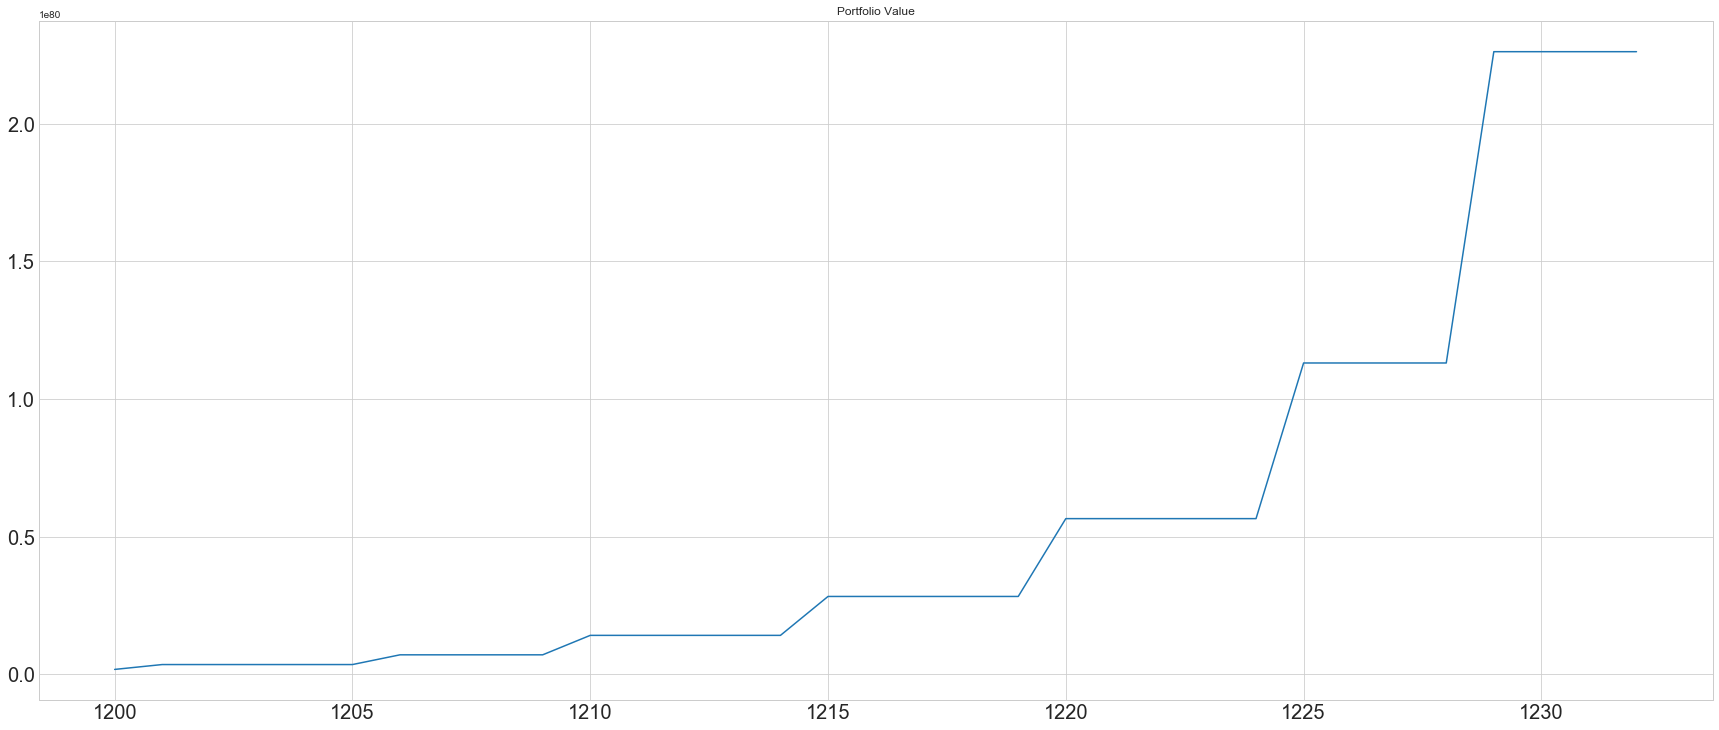

In [112]:
total_port_value.iloc[1200:, 0].plot(figsize= (30, 12.5), title = 'Portfolio Value', fontsize = 20, grid = True)

In [113]:
transaction_info = pd.DataFrame()
for symbol in transaction_history.keys():
    symbol_transaction = pd.DataFrame(transaction_history[symbol])
    symbol_transaction['symbol'] = symbol
    transaction_info = pd.concat([transaction_info, symbol_transaction])

transaction_info.reset_index(inplace = True)
transaction_info.drop('index', axis = 1, inplace = True)

In [119]:
transaction_info

,Action,Date,Fee,Option,Price,Quantity,Strike_Price,symbol
0,short,2014-01-01,0,6600_call,20.35,26954,6600,6600_call
1,short,2014-01-15,0,6600_call,4.30,379143,6600,6600_call
2,short,2014-01-22,0,6600_call,1.60,2424219,6600,6600_call
3,short,2014-03-05,0,6600_call,5.55,4620893,6600,6600_call
4,short,2014-01-01,0,6000_put,16.75,26954,6000,6000_put
5,short,2014-01-15,0,6000_put,6.25,379143,6000,6000_put
6,short,2014-01-22,0,6000_put,1.70,2424219,6000,6000_put
7,short,2014-03-05,0,6000_put,8.30,4620893,6000,6000_put
8,short,2014-01-08,0,6400_call,21.55,66777,6400,6400_call
9,short,2014-01-29,0,6400_call,0.25,22856922,6400,6400_call
